In [1]:
#### load libs

%matplotlib inline

import math, keras, datetime, pandas as pd, numpy as np, keras.backend as K
import matplotlib.pyplot as plt, operator, random, pickle
import os
import xgboost as xgb

from isoweek import Week
from pandas_summary import DataFrameSummary

C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
path = "F:/AV/AbInBev/"
train_folder = 'train_OwBvO8W'
test_folder = 'test_8uviCCm'
submit_folder = 'sample_submission_1'

In [3]:
for i in os.walk(path+train_folder):
    print(i)

('F:/AV/AbInBev/train_OwBvO8W', [], ['demographics.csv', 'event_calendar.csv', 'historical_volume.csv', 'industry_soda_sales.csv', 'industry_volume.csv', 'price_sales_promotion.csv', 'weather.csv'])


In [4]:
### functoin to get csvs within a folder

def get_csv(path,folder):
    for path,directory,files in os.walk(path+folder):
        return(path,directory,[path+"/"+file for file in files])

In [5]:
### train details
tr_path,_,tr_files=get_csv(path,train_folder)

In [6]:
#train_tables_csv
train_tables = [pd.read_csv(file,low_memory=False) for file in tr_files]

In [7]:
from IPython.display import HTML

In [8]:
### take a look at head of table
for t in train_tables: display(t.head())

Agency  Avg_Population_2017  Avg_Yearly_Household_Income_2017
0  Agency_05              3044268                            182944
1  Agency_02              3137874                            240809
2  Agency_55              2025793                            238553
3  Agency_53              1729177                            111048
4  Agency_50              2057678                            144594

YearMonth  Easter Day  Good Friday  New Year  Christmas  Labor Day  \
0     201301           0            0         1          0          0   
1     201302           0            0         0          0          0   
2     201303           1            1         0          0          0   
3     201304           0            0         0          0          0   
4     201305           0            0         0          0          1   

   Independence Day  Revolution Day Memorial  Regional Games   \
0                 0                        0                0   
1                 0                        0                0   
2                 0                        0                0   
3                 0                        0                0   
4                 0                        0                0   

   FIFA U-17 World Cup  Football Gold Cup  Beer Capital  Music Fest  
0                    0                  0             0           0  
1                    0                  0             0           0  
2                    0                  0             0           1  
3                    0                  0             0           0  
4                    0                  0             0           0

Agency     SKU  YearMonth    Volume
0  Agency_22  SKU_01     201301   52.2720
1  Agency_22  SKU_02     201301  110.7000
2  Agency_58  SKU_23     201301    0.0000
3  Agency_48  SKU_07     201301   28.3200
4  Agency_22  SKU_05     201301  238.5387

YearMonth  Soda_Volume
0     201301    718394219
1     201302    753938444
2     201303    892192092
3     201304    838099501
4     201305    864420003

YearMonth  Industry_Volume
0     201301        492612703
1     201302        431937346
2     201303        509281531
3     201304        532390389
4     201305        551755254

Agency     SKU  YearMonth        Price        Sales  Promotions
0  Agency_01  SKU_01     201301  1141.500000  1033.432731  108.067269
1  Agency_01  SKU_01     201302  1141.500000  1065.417195   76.082805
2  Agency_01  SKU_01     201303  1179.345820  1101.133633   78.212187
3  Agency_01  SKU_01     201304  1226.687500  1138.283357   88.404143
4  Agency_01  SKU_01     201305  1230.331104  1148.969634   81.361470

YearMonth     Agency  Avg_Max_Temp
0     201301  Agency_01        17.072
1     201302  Agency_01        19.984
2     201303  Agency_01        24.600
3     201304  Agency_01        27.532
4     201305  Agency_01        29.396

In [9]:
tr_files

['F:/AV/AbInBev/train_OwBvO8W/demographics.csv',
 'F:/AV/AbInBev/train_OwBvO8W/event_calendar.csv',
 'F:/AV/AbInBev/train_OwBvO8W/historical_volume.csv',
 'F:/AV/AbInBev/train_OwBvO8W/industry_soda_sales.csv',
 'F:/AV/AbInBev/train_OwBvO8W/industry_volume.csv',
 'F:/AV/AbInBev/train_OwBvO8W/price_sales_promotion.csv',
 'F:/AV/AbInBev/train_OwBvO8W/weather.csv']

In [10]:
#### lets check the summary for train tables

for t in train_tables: display(DataFrameSummary(t).summary())


Agency Avg_Population_2017 Avg_Yearly_Household_Income_2017
count            NaN                  60                               60
mean             NaN              936717                           148119
std              NaN              920764                          50604.6
min              NaN               12271                            90240
25%              NaN               50340                           106161
50%              NaN              647304                           129333
75%              NaN         1.71931e+06                           204561
max              NaN         3.13787e+06                           247220
counts            60                  60                               60
uniques           60                  60                               60
missing            0                   0                                0
missing_perc      0%                  0%                               0%
types         unique             numeric                          numeric

YearMonth Easter Day Good Friday   New Year  Christmas  \
count               61         61          61         61         61   
mean            201511  0.0819672   0.0819672  0.0983607  0.0819672   
std            146.403   0.276591    0.276591   0.300273   0.276591   
min             201301          0           0          0          0   
25%             201404          0           0          0          0   
50%             201507          0           0          0          0   
75%             201610          0           0          0          0   
max             201801          1           1          1          1   
counts              61         61          61         61         61   
uniques             61          2           2          2          2   
missing              0          0           0          0          0   
missing_perc        0%         0%          0%         0%         0%   
types          numeric       bool        bool       bool       bool   

              Labor Day Independence Day Revolution Day Memorial  \
count                61               61                      61   
mean          0.0819672        0.0819672               0.0819672   
std            0.276591         0.276591                0.276591   
min                   0                0                       0   
25%                   0                0                       0   
50%                   0                0                       0   
75%                   0                0                       0   
max                   1                1                       1   
counts               61               61                      61   
uniques               2                2                       2   
missing               0                0                       0   
missing_perc         0%               0%                      0%   
types              bool             bool                    bool   

             Regional Games  FIFA U-17 World Cup Football Gold Cup  \
count                     61                  61                61   
mean               0.0163934                   0                 0   
std                 0.128037                   0                 0   
min                        0                   0                 0   
25%                        0                   0                 0   
50%                        0                   0                 0   
75%                        0                   0                 0   
max                        1                   0                 0   
counts                    61                  61                61   
uniques                    2                   1                 1   
missing                    0                   0                 0   
missing_perc              0%                  0%                0%   
types                   bool            constant          constant   

             Beer Capital Music Fest  
count                  61         61  
mean            0.0819672  0.0819672  
std              0.276591   0.276591  
min                     0          0  
25%                     0          0  
50%                     0          0  
75%                     0          0  
max                     1          1  
counts                 61         61  
uniques                 2          2  
missing                 0          0  
missing_perc           0%         0%  
types                bool       bool

Agency          SKU YearMonth   Volume
count                 NaN          NaN     21000    21000
mean                  NaN          NaN    201506   1492.4
std                   NaN          NaN   141.467   2711.5
min                   NaN          NaN    201301        0
25%                   NaN          NaN    201404  8.27239
50%                   NaN          NaN    201506  158.436
75%                   NaN          NaN    201609  1774.79
max                   NaN          NaN    201712  22526.6
counts              21000        21000     21000    21000
uniques                58           25        60    14098
missing                 0            0         0        0
missing_perc           0%           0%        0%       0%
types         categorical  categorical   numeric  numeric

YearMonth  Soda_Volume
count               60           60
mean            201506    8.512e+08
std            142.657  7.89018e+07
min             201301  6.96401e+08
25%             201404  7.89088e+08
50%             201506   8.6492e+08
75%             201609  9.00555e+08
max             201712  1.04987e+09
counts              60           60
uniques             60           60
missing              0            0
missing_perc        0%           0%
types          numeric      numeric

YearMonth Industry_Volume
count               60              60
mean            201506     5.43921e+08
std            142.657     6.34094e+07
min             201301     4.13052e+08
25%             201404     5.09055e+08
50%             201506       5.512e+08
75%             201609     5.89372e+08
max             201712     6.70016e+08
counts              60              60
uniques             60              60
missing              0               0
missing_perc        0%              0%
types          numeric         numeric

Agency          SKU YearMonth    Price    Sales Promotions
count                 NaN          NaN     21000    21000    21000      21000
mean                  NaN          NaN    201506  1451.54  1267.35    184.374
std                   NaN          NaN   141.467  683.362  587.757     257.47
min                   NaN          NaN    201301        0 -3121.69          0
25%                   NaN          NaN    201404  1311.55  1178.37    54.9351
50%                   NaN          NaN    201506  1495.17   1324.7    138.307
75%                   NaN          NaN    201609  1725.65  1517.31    272.299
max                   NaN          NaN    201712  19166.6   4925.4    19166.6
counts              21000        21000     21000    21000    21000      21000
uniques                58           25        60    16727    17962      17511
missing                 0            0         0        0        0          0
missing_perc           0%           0%        0%       0%       0%         0%
types         categorical  categorical   numeric  numeric  numeric    numeric

YearMonth       Agency Avg_Max_Temp
count             3600          NaN         3600
mean            201506          NaN      28.7228
std            141.483          NaN      4.02113
min             201301          NaN       16.731
25%             201404          NaN      25.5811
50%             201506          NaN      28.6485
75%             201609          NaN      31.6767
max             201712          NaN      45.2905
counts            3600         3600         3600
uniques             60           60         1418
missing              0            0            0
missing_perc        0%           0%           0%
types          numeric  categorical      numeric

In [11]:
#### no missing values in any field

#### Data Cleaning/Feature engineering

In [12]:
### separate out into each individual table
demographics,event_cal,hist_volm,ind_soda_sales,ind_volm,promo,weather = train_tables

#### We will create multiple columns indicating which weeks had which kind of holiday/event and a combination of those

In [13]:
#### lets add more info to event_calendar dataframe based on state holidays, sports, music festivals, beer related stuff
state_hols = ['Easter Day','Good Friday','New Year','Christmas','Labor Day','Independence Day','Revolution Day Memorial']
sports = ['Regional Games ','FIFA U-17 World Cup','Football Gold Cup']

event_cal['National_Hol'] = np.where(np.sum(event_cal[state_hols],axis=1)>0,1,0) 
event_cal['Sports_Week'] = np.where(np.sum(event_cal[sports],axis=1)>0,1,0) 

event_cal['National_Hol_and_Sports_Week'] = np.where(np.sum(event_cal[['National_Hol','Sports_Week']],axis=1)>1,1,0) 
event_cal['Beer_Capital_and_Sports'] = np.where(np.sum(event_cal[['Beer Capital','Sports_Week']],axis=1)>1,1,0) 
event_cal['Beer_Capital_and_Music Fest'] = np.where(np.sum(event_cal[['Beer Capital','Music Fest']],axis=1)>1,1,0) 
event_cal['Sports_Week_and_Music Fest'] = np.where(np.sum(event_cal[['Sports_Week','Music Fest']],axis=1)>1,1,0) 
event_cal['National_Hol_and_Music Fest'] = np.where(np.sum(event_cal[['National_Hol','Music Fest']],axis=1)>1,1,0) 
event_cal.head()

YearMonth  Easter Day  Good Friday  New Year  Christmas  Labor Day  \
0     201301           0            0         1          0          0   
1     201302           0            0         0          0          0   
2     201303           1            1         0          0          0   
3     201304           0            0         0          0          0   
4     201305           0            0         0          0          1   

   Independence Day  Revolution Day Memorial  Regional Games   \
0                 0                        0                0   
1                 0                        0                0   
2                 0                        0                0   
3                 0                        0                0   
4                 0                        0                0   

   FIFA U-17 World Cup  Football Gold Cup  Beer Capital  Music Fest  \
0                    0                  0             0           0   
1                    0                  0             0           0   
2                    0                  0             0           1   
3                    0                  0             0           0   
4                    0                  0             0           0   

   National_Hol  Sports_Week  National_Hol_and_Sports_Week  \
0             1            0                             0   
1             0            0                             0   
2             1            0                             0   
3             0            0                             0   
4             1            0                             0   

   Beer_Capital_and_Sports  Beer_Capital_and_Music Fest  \
0                        0                            0   
1                        0                            0   
2                        0                            0   
3                        0                            0   
4                        0                            0   

   Sports_Week_and_Music Fest  National_Hol_and_Music Fest  
0                           0                            0  
1                           0                            0  
2                           0                            1  
3                           0                            0  
4                           0                            0

In [14]:
#### function to retrieve last event for all yearmonths

def prior_event_track(df,event):
    col = []
    last_YearMonth = 201301 #000000
    last_event_val = df.iloc[0,:][event]     
    
    for i in range(len(df)):
        if True:
            curr_val_event = df.iloc[i,:][event]        
            curr_YearMonth = df.iloc[i,:]['YearMonth']
#             print(curr_val_event)
#             print(curr_YearMonth)   
            
        if curr_val_event == 0 :
            mth_begin = str(curr_YearMonth)[4:]
            mth_end   = str(last_YearMonth)[4:]
            yr_begin = str(curr_YearMonth)[:4]
            yr_end   = str(last_YearMonth)[:4]
            
            mth_diff = int(mth_begin) - int(mth_end)
            yr_diff = int(yr_begin) - int(yr_end)
            
            if yr_diff>0:
                mth_diff += yr_diff*12
            if last_event_val == 0:
                col.append(99)
            if last_event_val != 0:
                col.append(mth_diff)
            
        if curr_val_event > 0 :
            last_YearMonth = curr_YearMonth
            last_event_val = curr_val_event
            col.append(0)
    
    df['time_since_'+event] = col        
    
    return (df)

In [15]:
### Add all prior event info to useful general columns

prior_event_track(event_cal,'National_Hol')
prior_event_track(event_cal,'Sports_Week')
prior_event_track(event_cal,'National_Hol_and_Sports_Week')
prior_event_track(event_cal,'Beer_Capital_and_Sports')
prior_event_track(event_cal,'Beer_Capital_and_Music Fest')
prior_event_track(event_cal,'Music Fest')
event_cal.head()

YearMonth  Easter Day  Good Friday  New Year  Christmas  Labor Day  \
0     201301           0            0         1          0          0   
1     201302           0            0         0          0          0   
2     201303           1            1         0          0          0   
3     201304           0            0         0          0          0   
4     201305           0            0         0          0          1   

   Independence Day  Revolution Day Memorial  Regional Games   \
0                 0                        0                0   
1                 0                        0                0   
2                 0                        0                0   
3                 0                        0                0   
4                 0                        0                0   

   FIFA U-17 World Cup          ...            Beer_Capital_and_Sports  \
0                    0          ...                                  0   
1                    0          ...                                  0   
2                    0          ...                                  0   
3                    0          ...                                  0   
4                    0          ...                                  0   

   Beer_Capital_and_Music Fest  Sports_Week_and_Music Fest  \
0                            0                           0   
1                            0                           0   
2                            0                           0   
3                            0                           0   
4                            0                           0   

   National_Hol_and_Music Fest  time_since_National_Hol  \
0                            0                        0   
1                            0                        1   
2                            1                        0   
3                            0                        1   
4                            0                        0   

   time_since_Sports_Week  time_since_National_Hol_and_Sports_Week  \
0                      99                                       99   
1                      99                                       99   
2                      99                                       99   
3                      99                                       99   
4                      99                                       99   

   time_since_Beer_Capital_and_Sports  time_since_Beer_Capital_and_Music Fest  \
0                                  99                                      99   
1                                  99                                      99   
2                                  99                                      99   
3                                  99                                      99   
4                                  99                                      99   

   time_since_Music Fest  
0                     99  
1                     99  
2                      0  
3                      1  
4                      2  

[5 rows x 26 columns]

In [16]:
#### Add per capita income to demographics table

demographics['Per_Capita'] = demographics['Avg_Yearly_Household_Income_2017']/demographics['Avg_Population_2017']

In [17]:
### lets also see how each row/Agency's demographcis relate to overall max and min for pop and income
def update_demographics_max_min(dataframe,columns):
    for column in columns:
        feat_max =  dataframe[column].max()
        feat_min =  dataframe[column].min()
        feat_avg =  dataframe[column].mean()
        dataframe[column+"_max_diff"] = feat_max - dataframe[column]
        dataframe[column+"_min_diff"] = feat_min - dataframe[column]
        dataframe[column+"_avg_diff"] = feat_avg - dataframe[column]
        del feat_max,feat_min,feat_avg
    return(dataframe)

In [18]:
demographics = update_demographics_max_min(demographics,['Avg_Population_2017','Avg_Yearly_Household_Income_2017','Per_Capita'])
demographics.head()

Agency  Avg_Population_2017  Avg_Yearly_Household_Income_2017  \
0  Agency_05              3044268                            182944   
1  Agency_02              3137874                            240809   
2  Agency_55              2025793                            238553   
3  Agency_53              1729177                            111048   
4  Agency_50              2057678                            144594   

   Per_Capita  Avg_Population_2017_max_diff  Avg_Population_2017_min_diff  \
0    0.060095                         93606                      -3031997   
1    0.076743                             0                      -3125603   
2    0.117758                       1112081                      -2013522   
3    0.064220                       1408697                      -1716906   
4    0.070270                       1080196                      -2045407   

   Avg_Population_2017_avg_diff  Avg_Yearly_Household_Income_2017_max_diff  \
0                 -2.107551e+06                                      64276   
1                 -2.201157e+06                                       6411   
2                 -1.089076e+06                                       8667   
3                 -7.924604e+05                                     136172   
4                 -1.120961e+06                                     102626   

   Avg_Yearly_Household_Income_2017_min_diff  \
0                                     -92704   
1                                    -150569   
2                                    -148313   
3                                     -20808   
4                                     -54354   

   Avg_Yearly_Household_Income_2017_avg_diff  Per_Capita_max_diff  \
0                              -34824.666667             7.862813   
1                              -92689.666667             7.846165   
2                              -90433.666667             7.805150   
3                               37071.333333             7.858688   
4                                3525.333333             7.852637   

   Per_Capita_min_diff  Per_Capita_avg_diff  
0            -0.004054             1.243267  
1            -0.020702             1.226619  
2            -0.061717             1.185604  
3            -0.008179             1.239142  
4            -0.014229             1.233091

In [19]:
#### lets try facebook's prophet forecasting lib
import datetime
from fbprophet import Prophet

### we need 2 columns for each agency: namely DS and Y (DS is date and Y is numeric)
weather['YearMonth'] = weather['YearMonth'].astype(str)+('01')
weather['ds'] = pd.to_datetime(weather['YearMonth'].astype(str), format='%Y%m%d')
weather['y'] = weather['Avg_Max_Temp']
weather.head()

YearMonth     Agency  Avg_Max_Temp         ds       y
0  20130101  Agency_01        17.072 2013-01-01  17.072
1  20130201  Agency_01        19.984 2013-02-01  19.984
2  20130301  Agency_01        24.600 2013-03-01  24.600
3  20130401  Agency_01        27.532 2013-04-01  27.532
4  20130501  Agency_01        29.396 2013-05-01  29.396

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprop

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonal

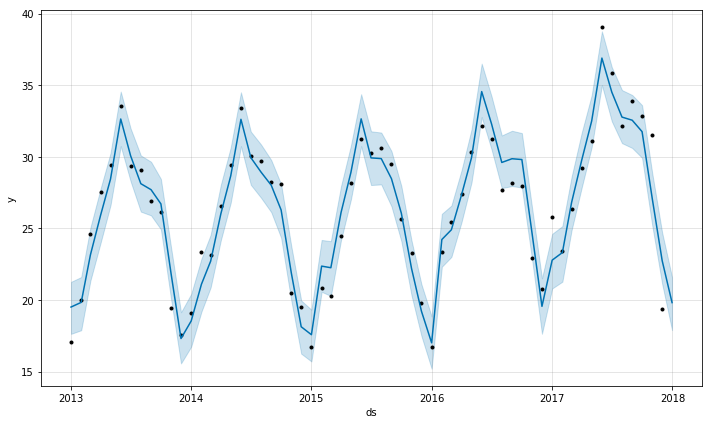

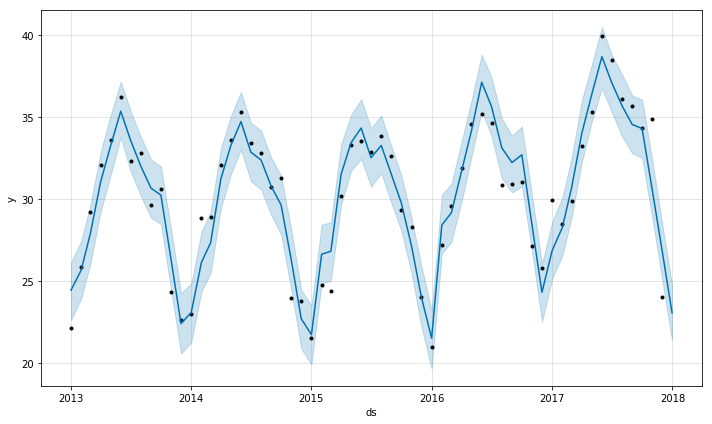

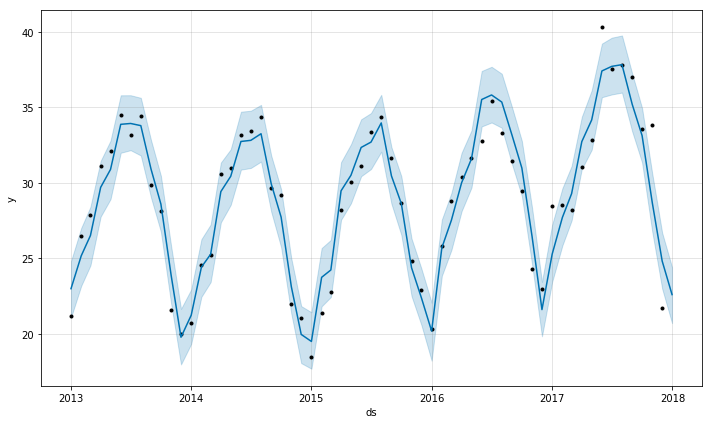

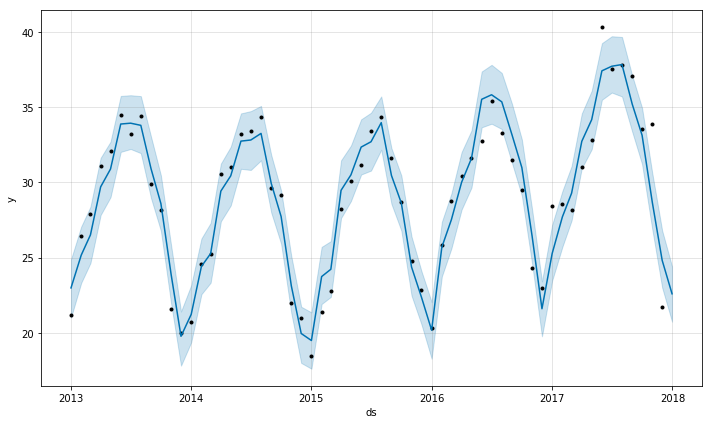

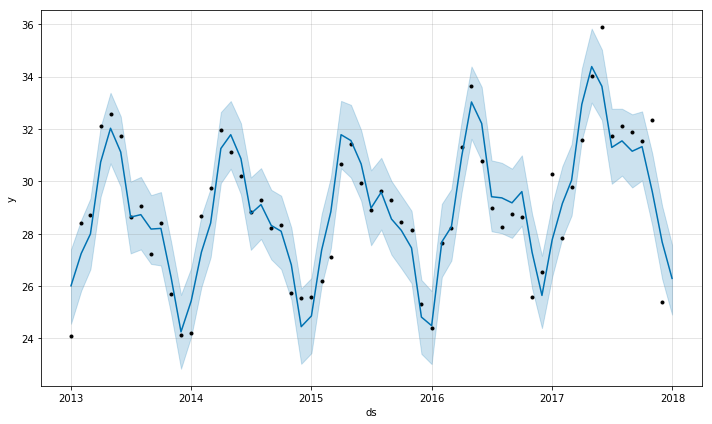

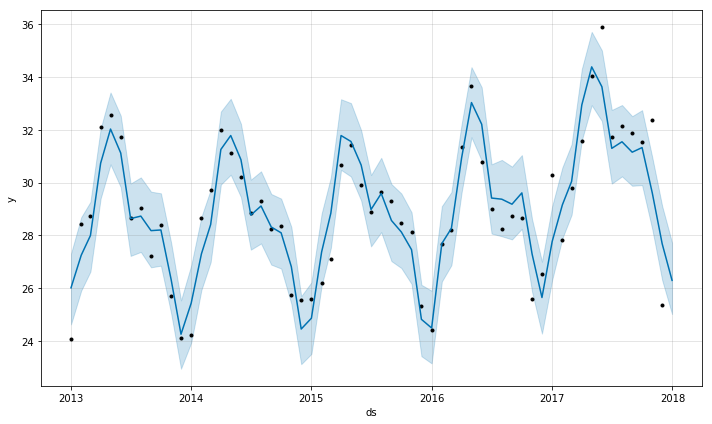

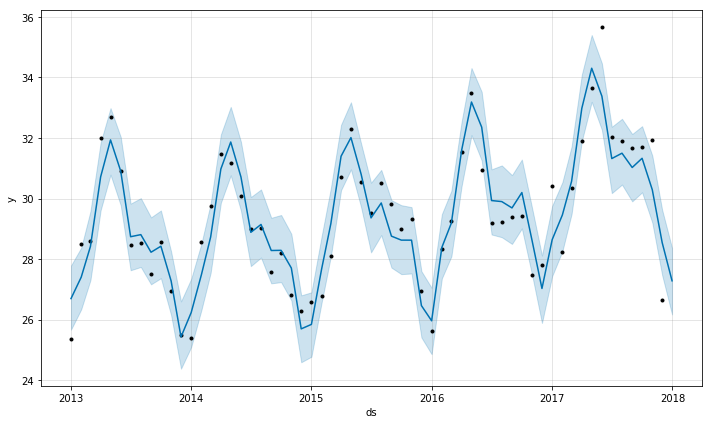

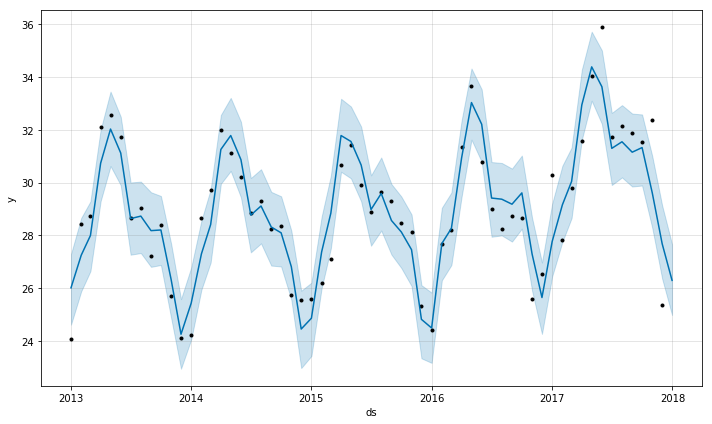

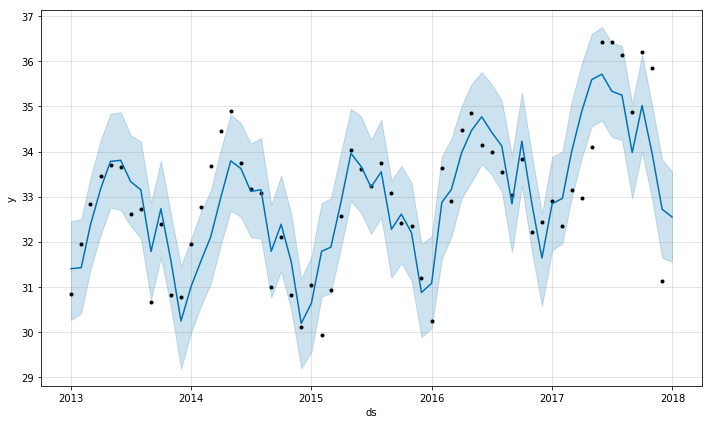

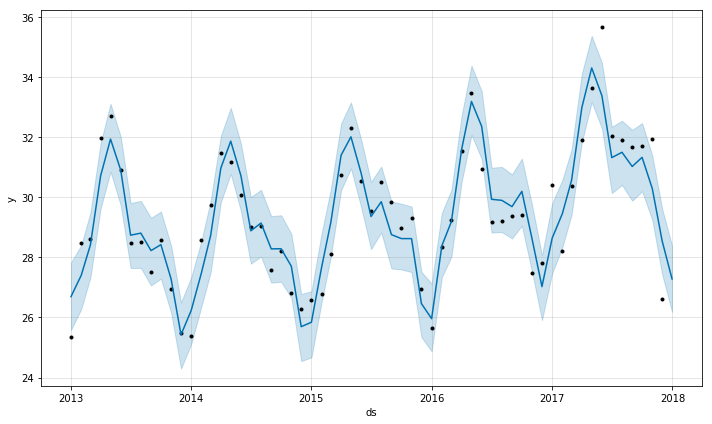

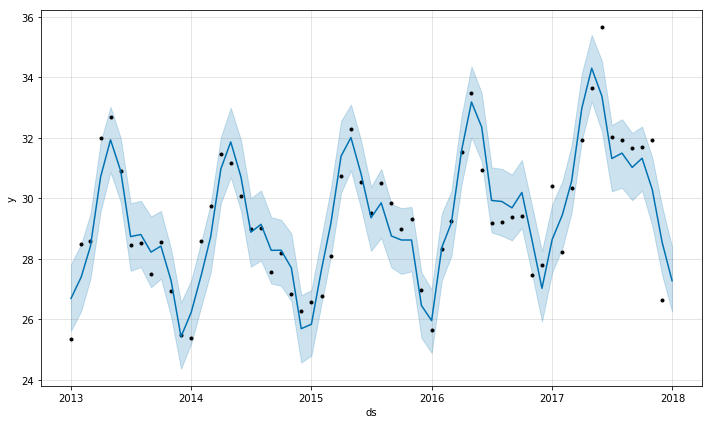

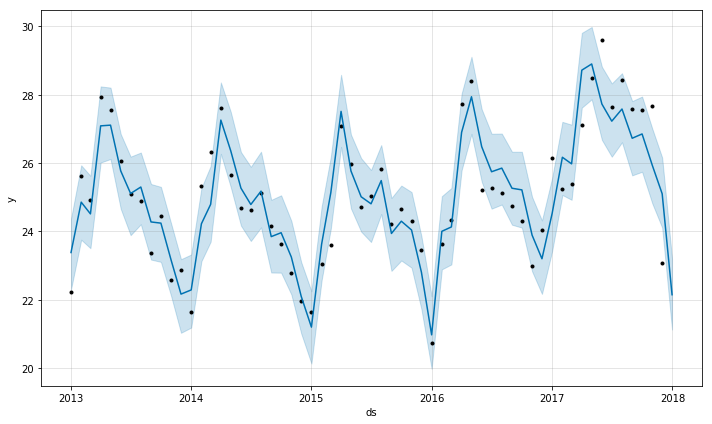

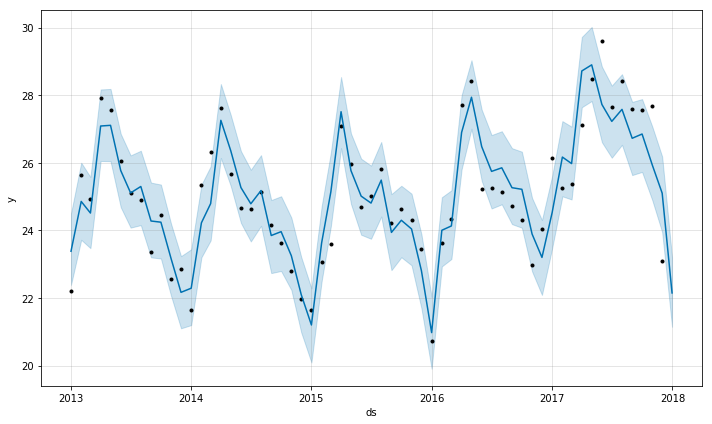

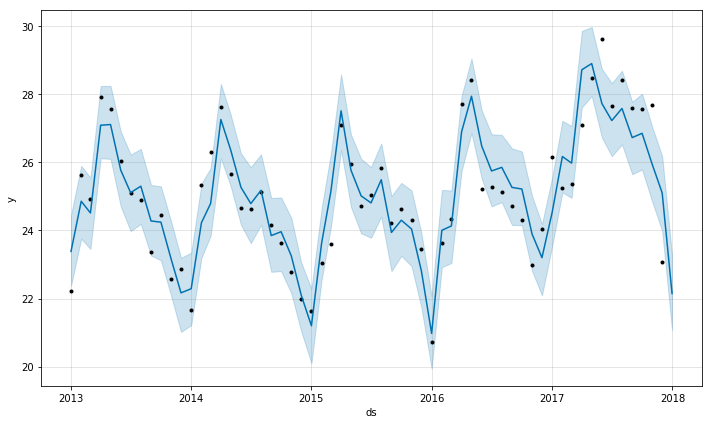

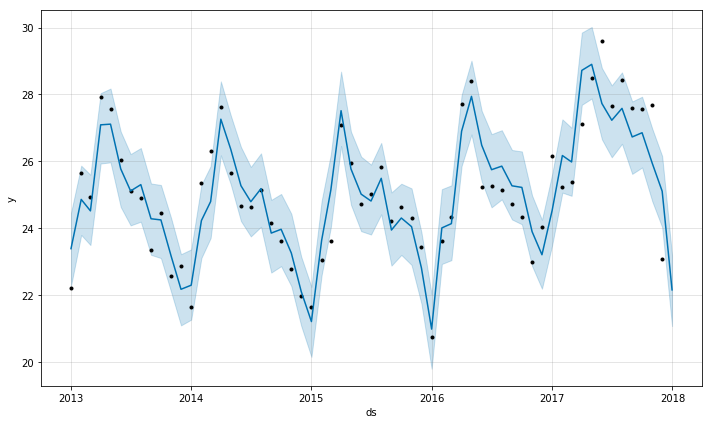

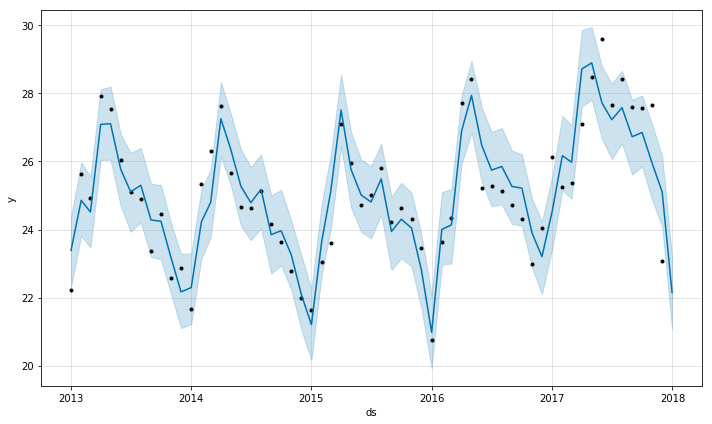

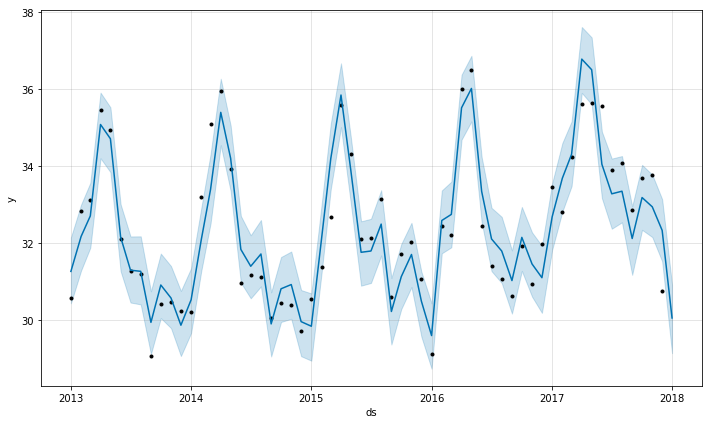

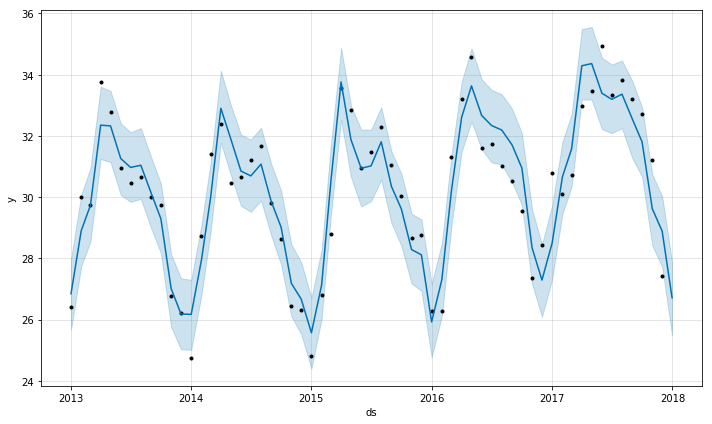

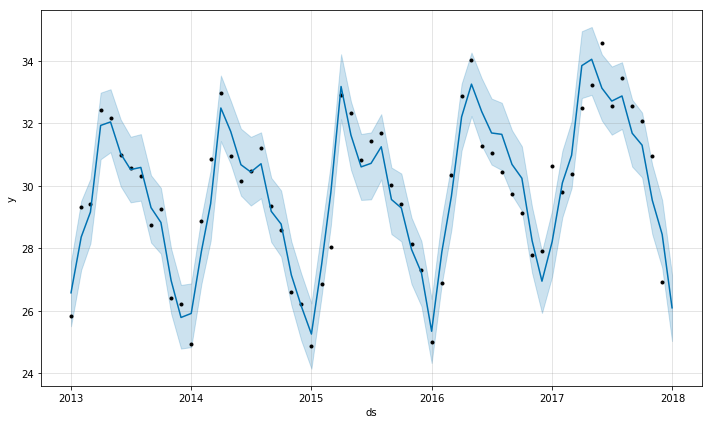

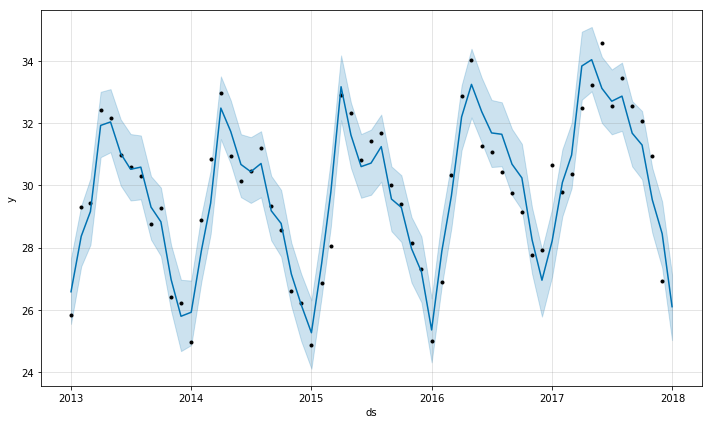

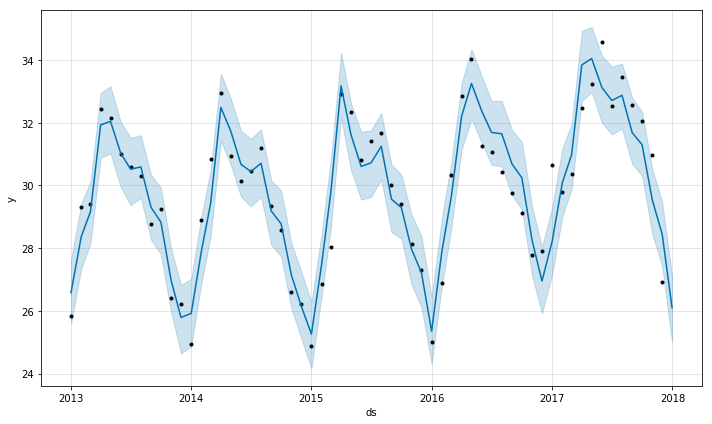

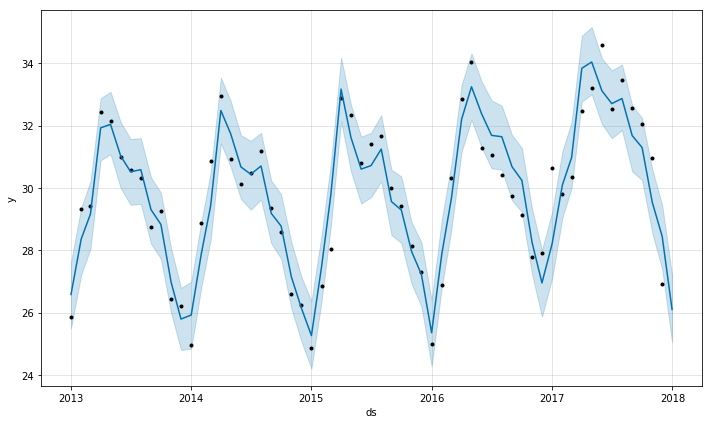

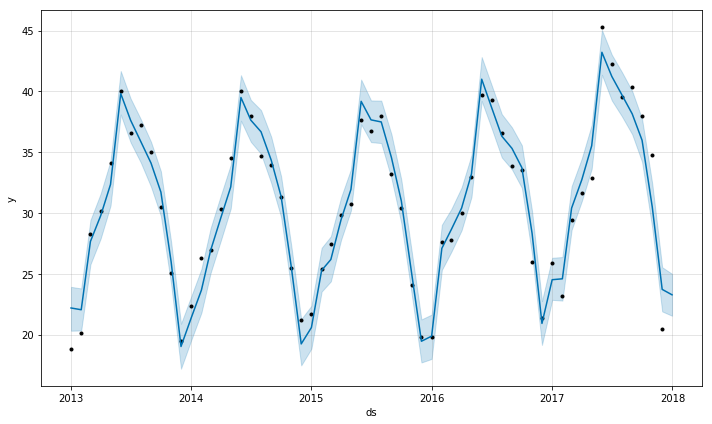

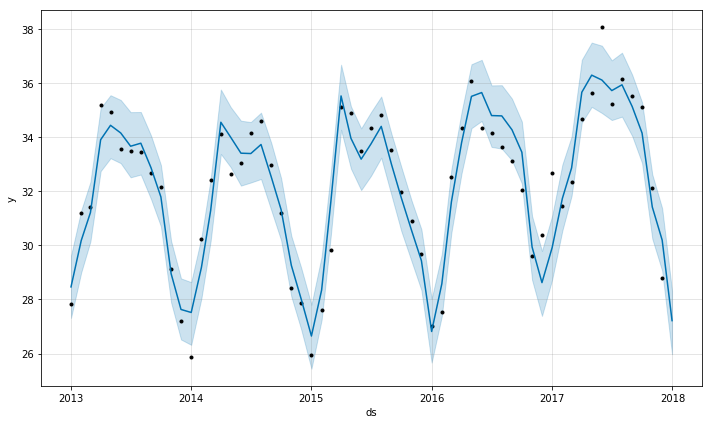

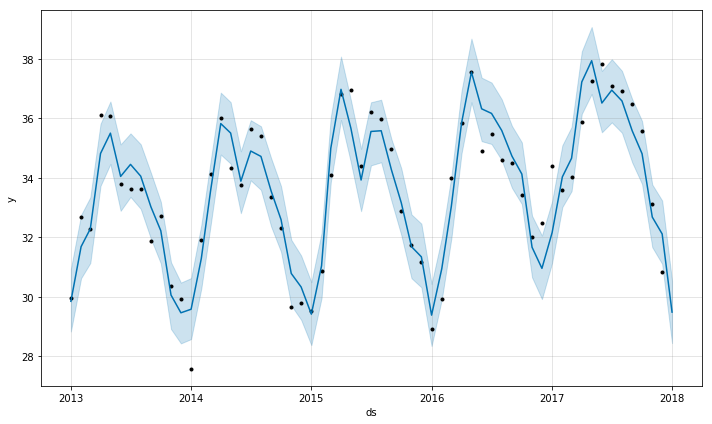

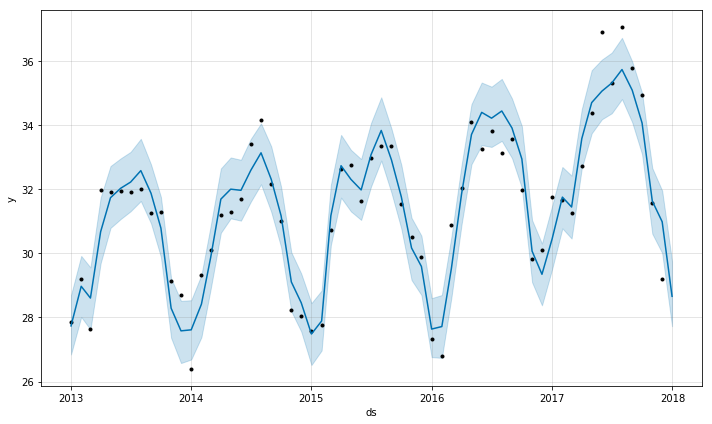

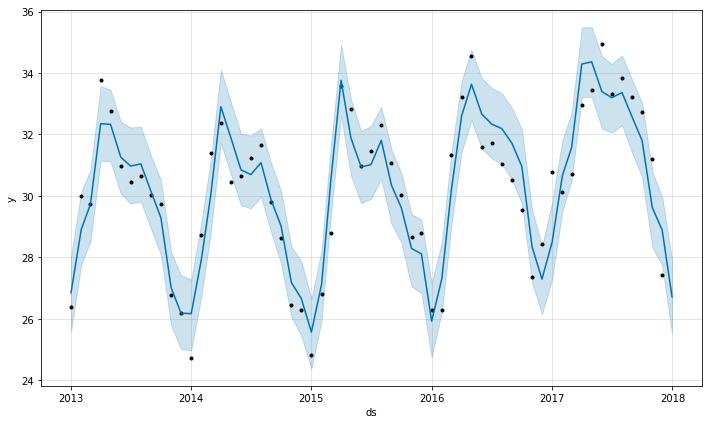

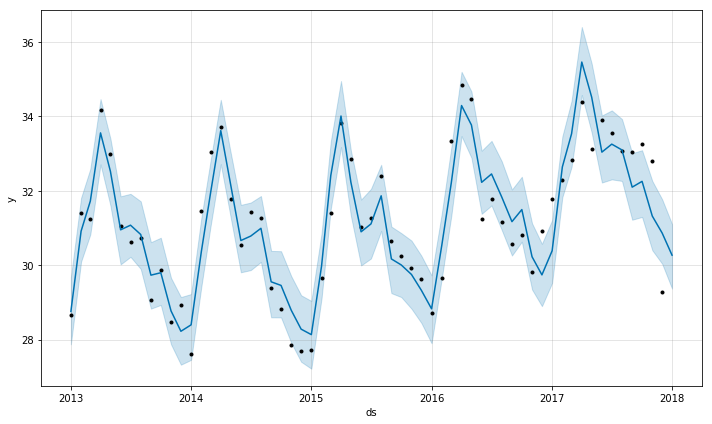

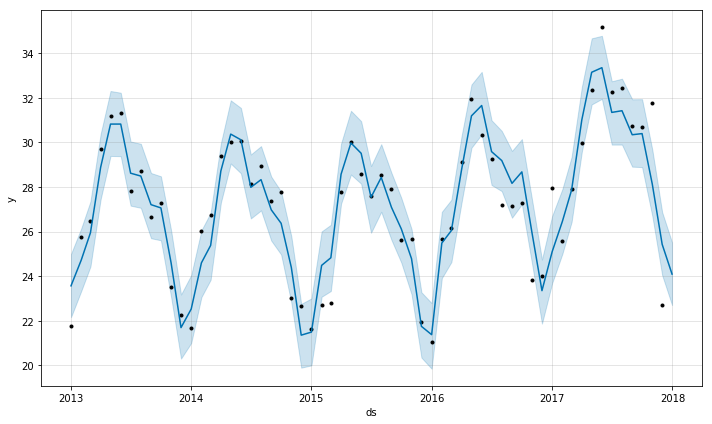

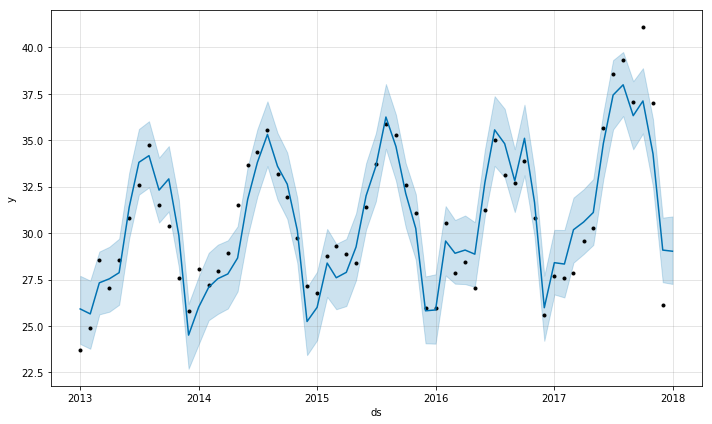

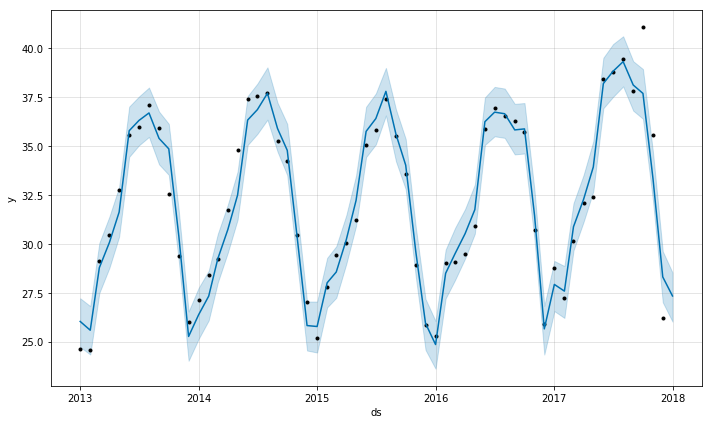

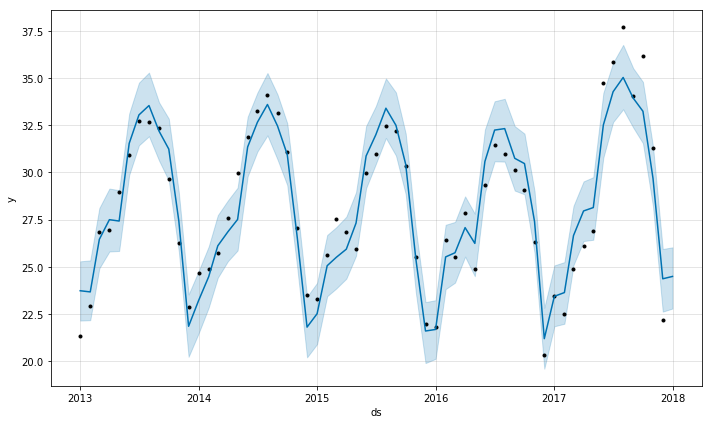

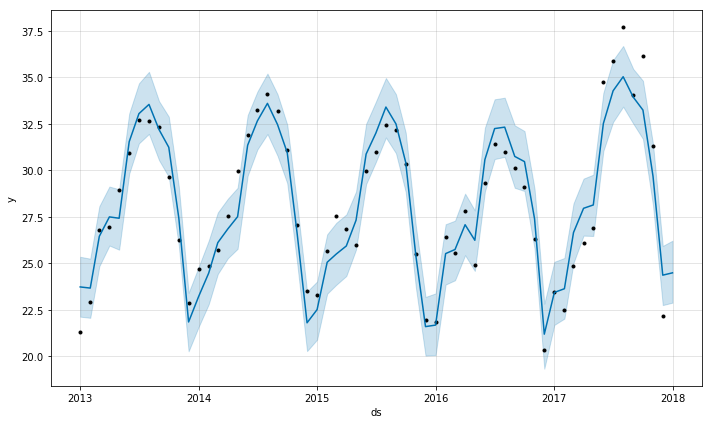

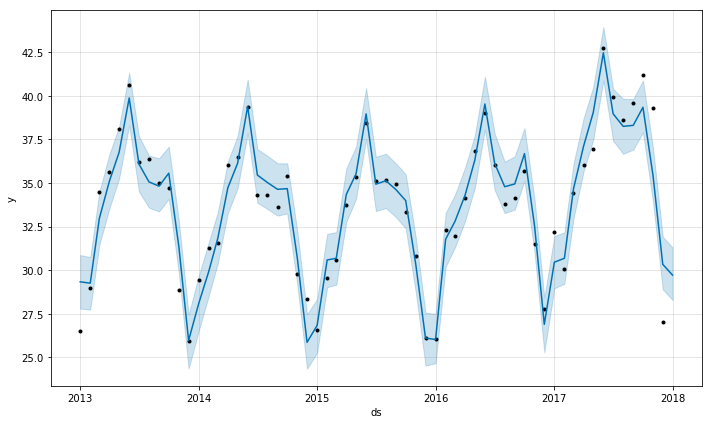

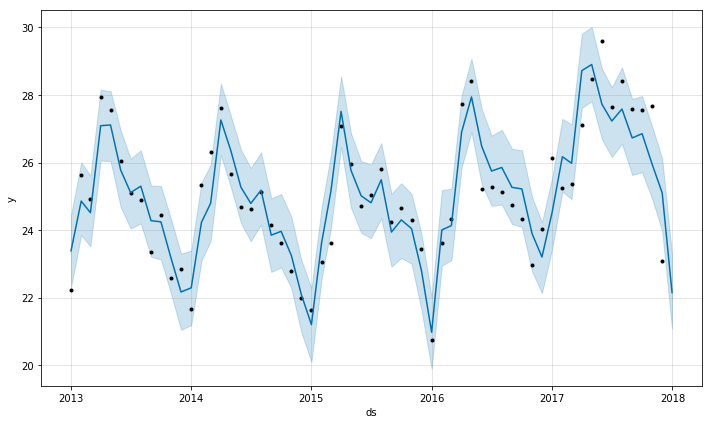

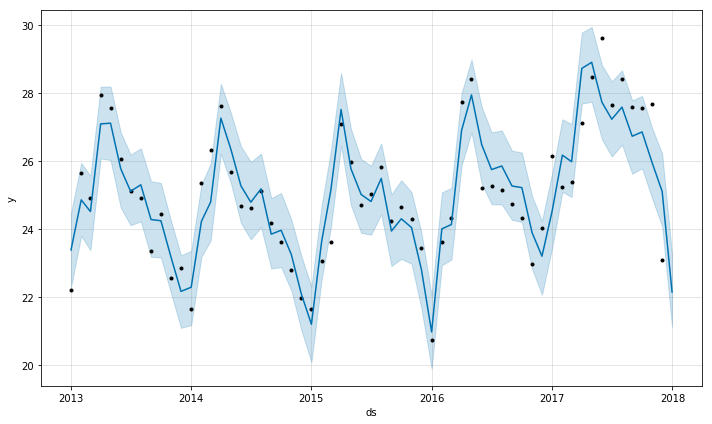

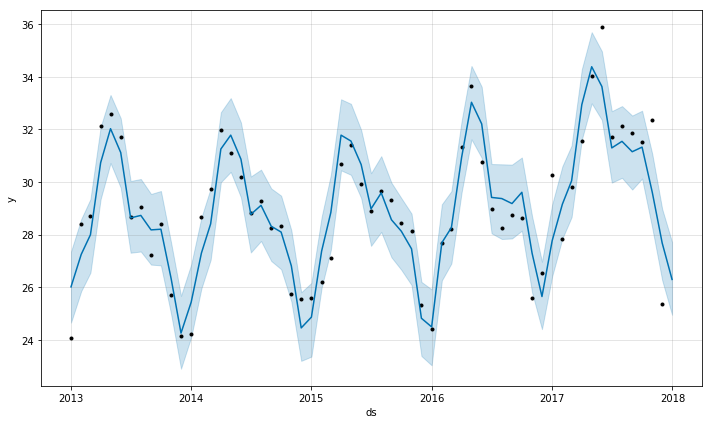

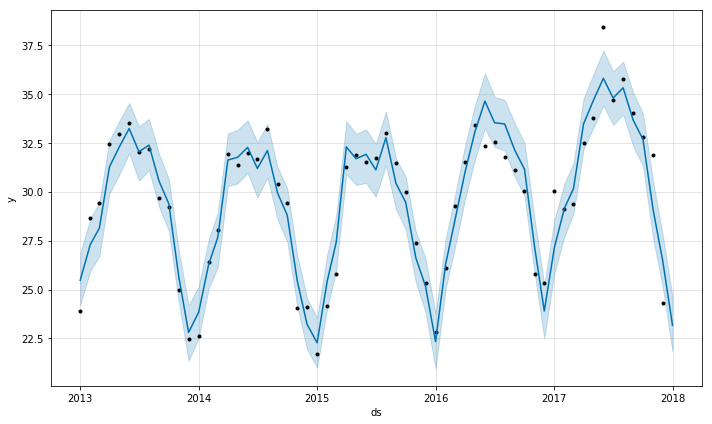

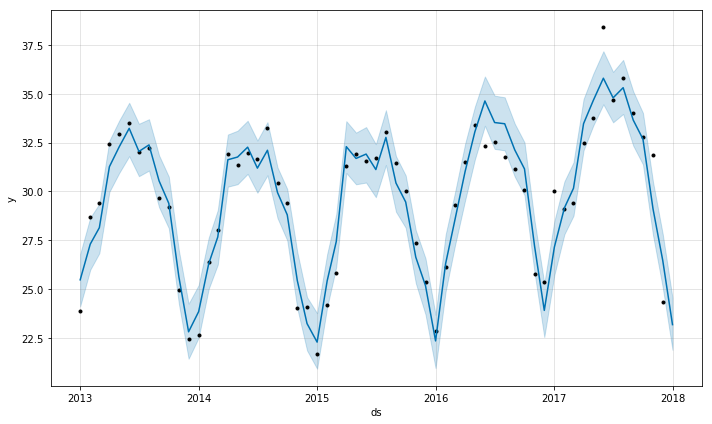

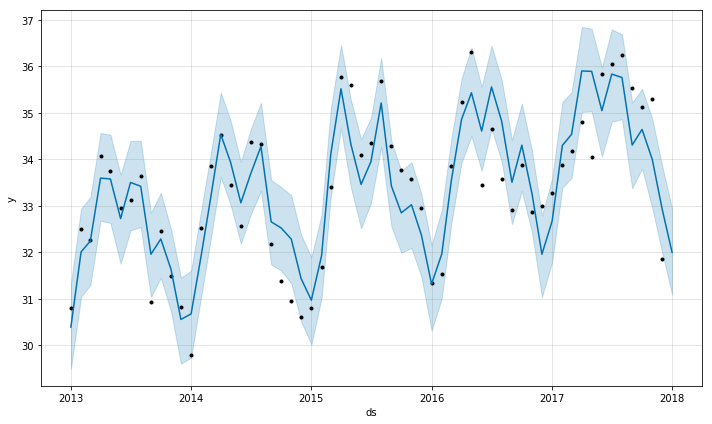

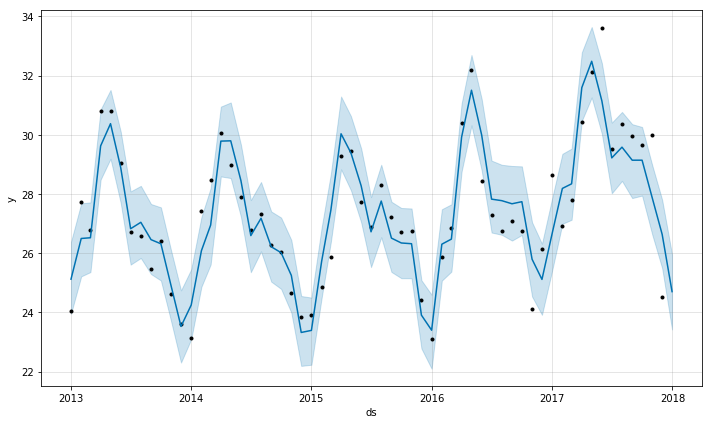

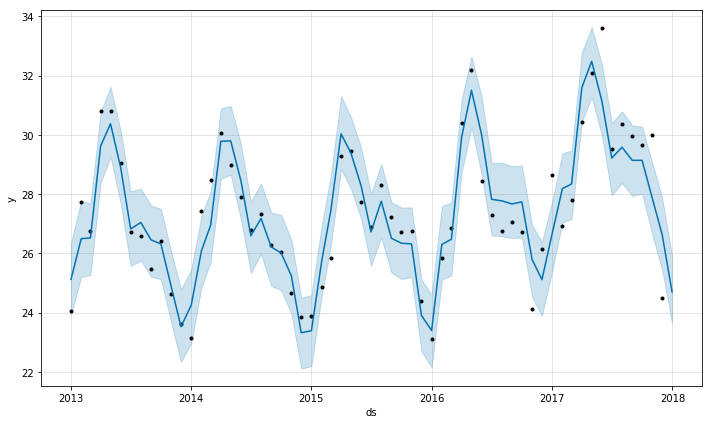

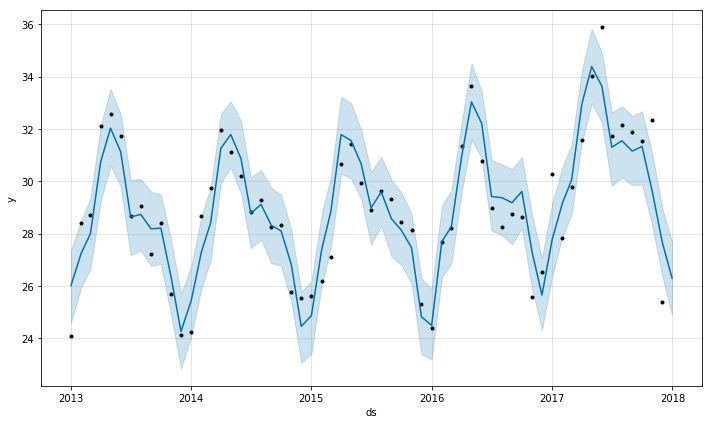

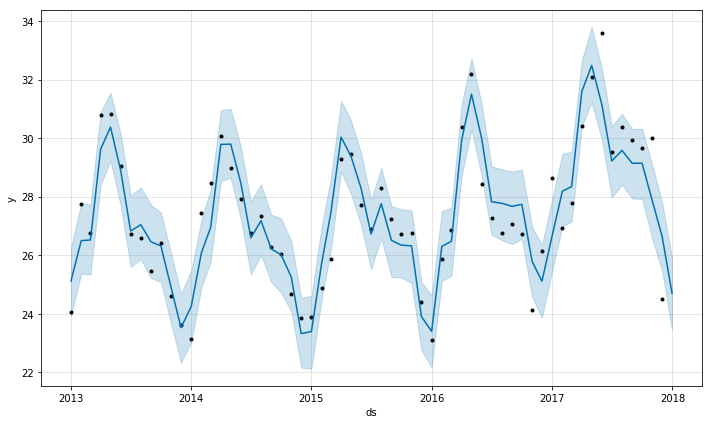

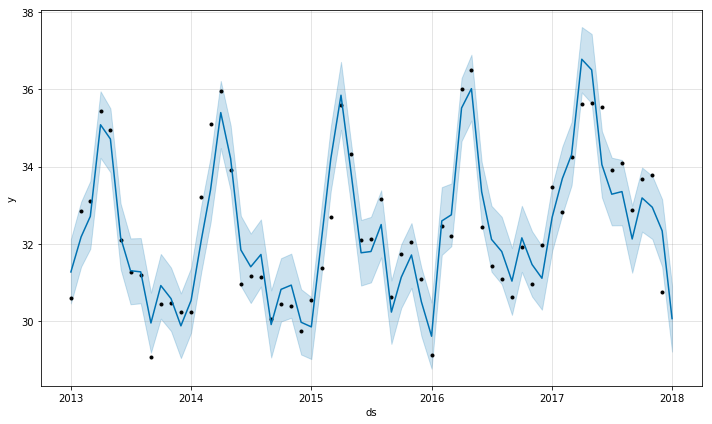

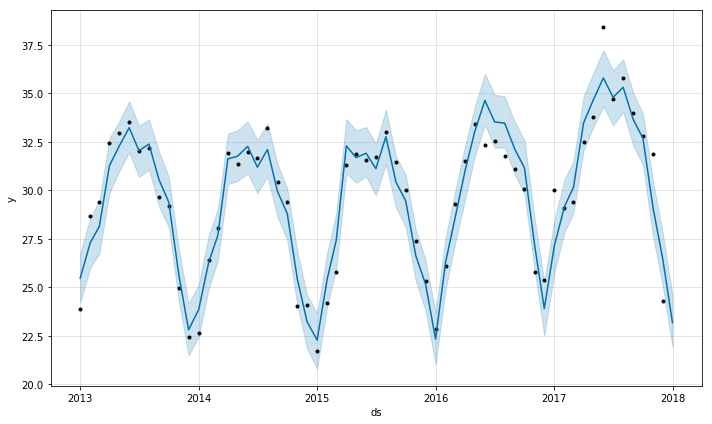

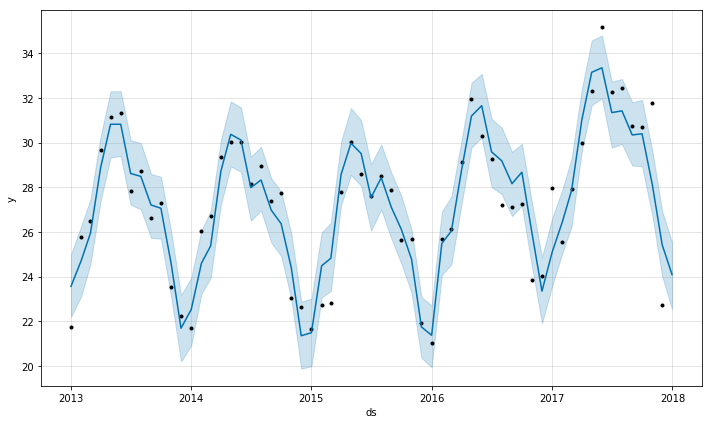

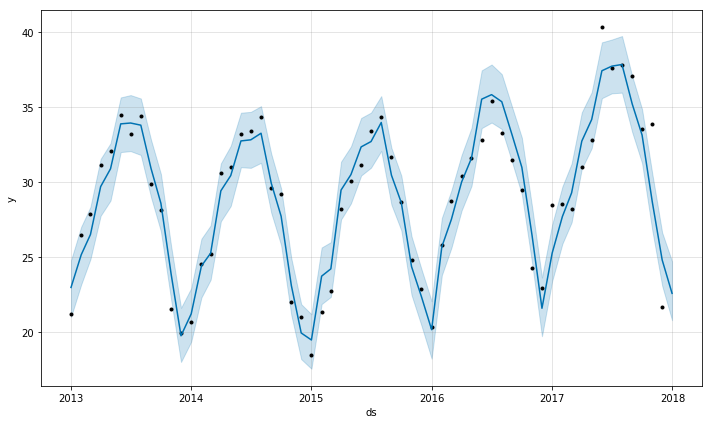

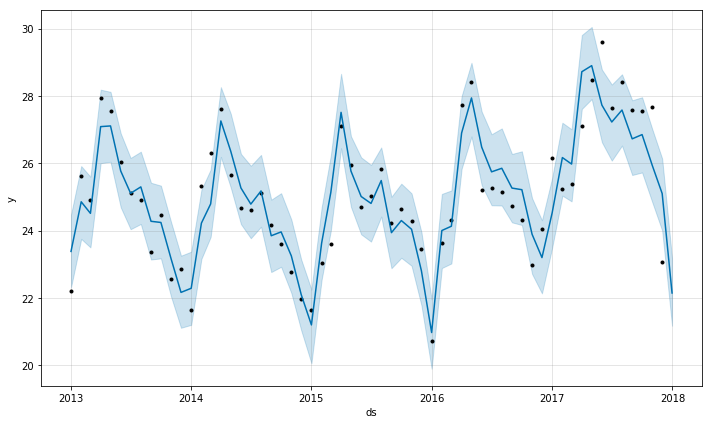

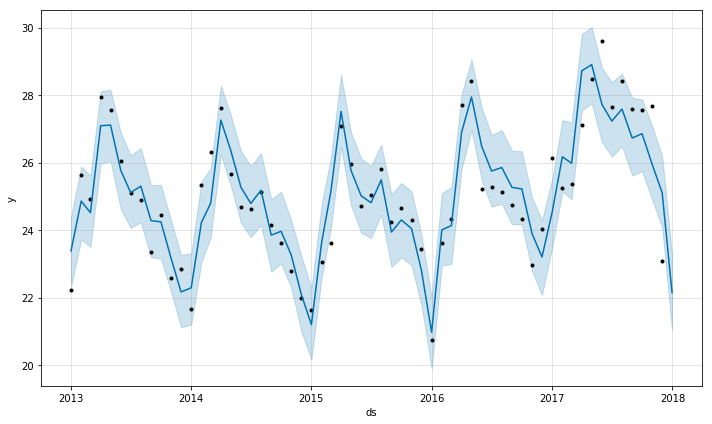

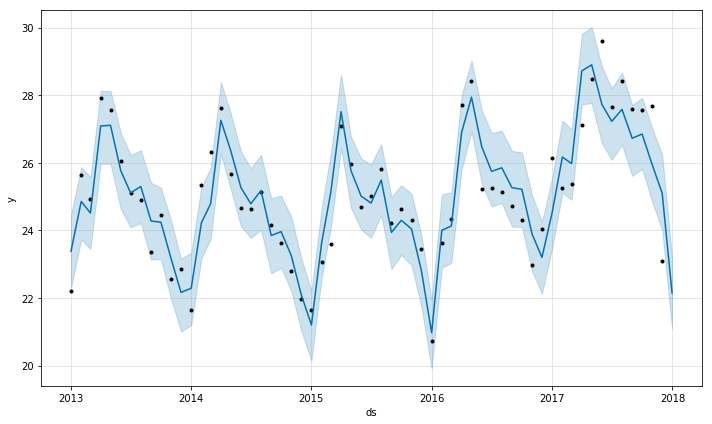

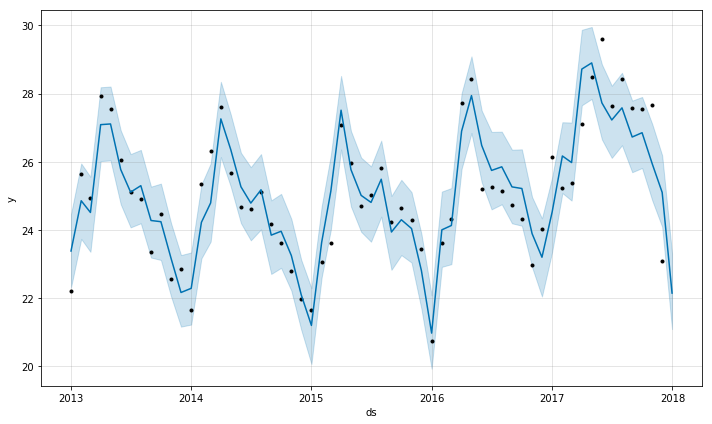

In [20]:
#### predict last data point for max temp for 201801 (takes a min or two)
pred_temp = []
for agency in np.unique(weather['Agency']):
    # agency = 'Agency_60'
    agency = agency
    Avg_Temp = weather.loc[weather['Agency']==agency]
    m= Prophet().fit(Avg_Temp)
    future = m.make_future_dataframe(periods=1,freq = 'M')
    fcst = m.predict(future)
    m.plot(fcst)
    pred = fcst.iloc[-1,-1]
    pred_temp.append({agency:pred})
    del m, Avg_Temp,fcst,future

In [21]:
#### Build am agency location dataframe
pred_temp_df = pd.DataFrame(np.zeros((len(pred_temp), 2)))
pred_temp_df.columns = ['Agency',"Avg_Max_Temp"]
idx = 0
for i in pred_temp:
    #print(i)
    for k,v in i.items():
        #print(k,v)
        pred_temp_df.iloc[idx,0] = k
        pred_temp_df.iloc[idx,1] = v
    idx += 1

pred_temp_df['YearMonth'] = '20180101'
pred_temp_df = pred_temp_df[['YearMonth','Agency','Avg_Max_Temp']]
pred_temp_df.head()

### Seems like some agencies are in the same location, lets add that info 


YearMonth     Agency  Avg_Max_Temp
0  20180101  Agency_01     19.818835
1  20180101  Agency_02     23.062572
2  20180101  Agency_03     22.595719
3  20180101  Agency_04     22.595719
4  20180101  Agency_05     26.294108

In [22]:
#### merge the 201801 prediction with actual file

weather.drop(['ds','y'],inplace=True,axis=1)
weather = pd.concat([weather,pred_temp_df])
weather['YearMonth'] = weather['YearMonth'].astype(str).str[:-2].astype(np.int64)
weather.head()
### this file has original data and prediction for final month

YearMonth     Agency  Avg_Max_Temp
0     201301  Agency_01        17.072
1     201302  Agency_01        19.984
2     201303  Agency_01        24.600
3     201304  Agency_01        27.532
4     201305  Agency_01        29.396

In [23]:
#### from https://stackoverflow.com/questions/20672238/find-dictionary-keys-with-duplicate-values

### output: list with unqiue next month temp pred value and the respective agency

flipped = {}
for i in pred_temp:
    for key, value in i.items():
        if value not in flipped:
            flipped[value] = [key]
        else:
            flipped[value].append(key)

In [24]:
agency_location = []
i = 0
for k,v in flipped.items():
    for item in v:
        agency_location.append({item:"location"+str(i)})
        #print(v)
    i += 1

In [25]:
#### build an agency location dataframe --- this is only a hypothesis

Agency_Location_DF = pd.DataFrame(np.zeros((len(agency_location), 2)))
Agency_Location_DF.columns = ['Agency',"Location"]
idx = 0
for i in agency_location:
    print(i)
    for k,v in i.items():
        print(k,v)
        Agency_Location_DF.iloc[idx,0] = k
        Agency_Location_DF.iloc[idx,1] = v
    idx += 1

{'Agency_01': 'location0'}
Agency_01 location0
{'Agency_02': 'location1'}
Agency_02 location1
{'Agency_03': 'location2'}
Agency_03 location2
{'Agency_04': 'location2'}
Agency_04 location2
{'Agency_55': 'location2'}
Agency_55 location2
{'Agency_56': 'location2'}
Agency_56 location2
{'Agency_05': 'location3'}
Agency_05 location3
{'Agency_06': 'location3'}
Agency_06 location3
{'Agency_08': 'location3'}
Agency_08 location3
{'Agency_40': 'location3'}
Agency_40 location3
{'Agency_50': 'location3'}
Agency_50 location3
{'Agency_07': 'location4'}
Agency_07 location4
{'Agency_10': 'location4'}
Agency_10 location4
{'Agency_11': 'location4'}
Agency_11 location4
{'Agency_09': 'location5'}
Agency_09 location5
{'Agency_47': 'location5'}
Agency_47 location5
{'Agency_12': 'location6'}
Agency_12 location6
{'Agency_13': 'location6'}
Agency_13 location6
{'Agency_14': 'location6'}
Agency_14 location6
{'Agency_15': 'location6'}
Agency_15 location6
{'Agency_16': 'location6'}
Agency_16 location6
{'Agency_17':

In [26]:
Agency_Location_DF.head()

Agency   Location
0  Agency_01  location0
1  Agency_02  location1
2  Agency_03  location2
3  Agency_04  location2
4  Agency_55  location2

In [27]:
### lets merge the weather and location dataframes
Weather_Location_merge = weather.merge(Agency_Location_DF,how='left',on="Agency")

### We will not look into other files such a soda vol, industry volume but will work on the below:

- Agency_Location_DF
- weather
- demographics
- event_cal
- hist_volm

In [28]:
hist_volm.head()

Agency     SKU  YearMonth    Volume
0  Agency_22  SKU_01     201301   52.2720
1  Agency_22  SKU_02     201301  110.7000
2  Agency_58  SKU_23     201301    0.0000
3  Agency_48  SKU_07     201301   28.3200
4  Agency_22  SKU_05     201301  238.5387

### Lets merge all files and also make time variables -- month, year etc


In [29]:
hist_volm_upd = hist_volm.copy()

In [30]:
hist_volm_upd.head()

Agency     SKU  YearMonth    Volume
0  Agency_22  SKU_01     201301   52.2720
1  Agency_22  SKU_02     201301  110.7000
2  Agency_58  SKU_23     201301    0.0000
3  Agency_48  SKU_07     201301   28.3200
4  Agency_22  SKU_05     201301  238.5387

In [31]:
### we need 2 columns for each agency: namely DS and Y (DS is date and Y is numeric)
hist_volm_upd['Retain'] = hist_volm_upd['YearMonth'].astype(str)
hist_volm_upd['YearMonth'] = hist_volm_upd['YearMonth'].astype(str)+('01')
hist_volm_upd['YearMonth'] = pd.to_datetime(hist_volm_upd['YearMonth'].astype(str), format='%Y%m%d')
Mth = hist_volm_upd.YearMonth
hist_volm_upd['Month'] = pd.DatetimeIndex(hist_volm_upd['YearMonth']).month
hist_volm_upd.head()

Agency     SKU  YearMonth    Volume  Retain  Month
0  Agency_22  SKU_01 2013-01-01   52.2720  201301      1
1  Agency_22  SKU_02 2013-01-01  110.7000  201301      1
2  Agency_58  SKU_23 2013-01-01    0.0000  201301      1
3  Agency_48  SKU_07 2013-01-01   28.3200  201301      1
4  Agency_22  SKU_05 2013-01-01  238.5387  201301      1

In [32]:
hist_volm_upd['Agency_SKU'] = hist_volm_upd['Agency']+"-"+hist_volm_upd['SKU']
hist_volm_upd.head()

Agency     SKU  YearMonth    Volume  Retain  Month        Agency_SKU
0  Agency_22  SKU_01 2013-01-01   52.2720  201301      1  Agency_22-SKU_01
1  Agency_22  SKU_02 2013-01-01  110.7000  201301      1  Agency_22-SKU_02
2  Agency_58  SKU_23 2013-01-01    0.0000  201301      1  Agency_58-SKU_23
3  Agency_48  SKU_07 2013-01-01   28.3200  201301      1  Agency_48-SKU_07
4  Agency_22  SKU_05 2013-01-01  238.5387  201301      1  Agency_22-SKU_05

In [33]:
#hist_volm_upd.drop(['Agency','SKU'],inplace=True,axis=1)

### Not using volume, sales or promotion data as we don't have those for 201801

In [34]:
Agency_Location_DF.head()

Agency   Location
0  Agency_01  location0
1  Agency_02  location1
2  Agency_03  location2
3  Agency_04  location2
4  Agency_55  location2

In [35]:
weather.head()

YearMonth     Agency  Avg_Max_Temp
0     201301  Agency_01        17.072
1     201302  Agency_01        19.984
2     201303  Agency_01        24.600
3     201304  Agency_01        27.532
4     201305  Agency_01        29.396

In [36]:
merge1 = Agency_Location_DF.merge(weather,how="left",on='Agency')
merge1.head()

Agency   Location  YearMonth  Avg_Max_Temp
0  Agency_01  location0     201301        17.072
1  Agency_01  location0     201302        19.984
2  Agency_01  location0     201303        24.600
3  Agency_01  location0     201304        27.532
4  Agency_01  location0     201305        29.396

In [37]:
demographics.head()

Agency  Avg_Population_2017  Avg_Yearly_Household_Income_2017  \
0  Agency_05              3044268                            182944   
1  Agency_02              3137874                            240809   
2  Agency_55              2025793                            238553   
3  Agency_53              1729177                            111048   
4  Agency_50              2057678                            144594   

   Per_Capita  Avg_Population_2017_max_diff  Avg_Population_2017_min_diff  \
0    0.060095                         93606                      -3031997   
1    0.076743                             0                      -3125603   
2    0.117758                       1112081                      -2013522   
3    0.064220                       1408697                      -1716906   
4    0.070270                       1080196                      -2045407   

   Avg_Population_2017_avg_diff  Avg_Yearly_Household_Income_2017_max_diff  \
0                 -2.107551e+06                                      64276   
1                 -2.201157e+06                                       6411   
2                 -1.089076e+06                                       8667   
3                 -7.924604e+05                                     136172   
4                 -1.120961e+06                                     102626   

   Avg_Yearly_Household_Income_2017_min_diff  \
0                                     -92704   
1                                    -150569   
2                                    -148313   
3                                     -20808   
4                                     -54354   

   Avg_Yearly_Household_Income_2017_avg_diff  Per_Capita_max_diff  \
0                              -34824.666667             7.862813   
1                              -92689.666667             7.846165   
2                              -90433.666667             7.805150   
3                               37071.333333             7.858688   
4                                3525.333333             7.852637   

   Per_Capita_min_diff  Per_Capita_avg_diff  
0            -0.004054             1.243267  
1            -0.020702             1.226619  
2            -0.061717             1.185604  
3            -0.008179             1.239142  
4            -0.014229             1.233091

In [38]:
merge2 = merge1.merge(demographics,how="left",on='Agency')
merge2.tail()

Agency    Location  YearMonth  Avg_Max_Temp  Avg_Population_2017  \
3655  Agency_51  location23     201709     29.951000              1750152   
3656  Agency_51  location23     201710     29.651515              1750152   
3657  Agency_51  location23     201711     29.990909              1750152   
3658  Agency_51  location23     201712     24.503584              1750152   
3659  Agency_51  location23     201801     24.701446              1750152   

      Avg_Yearly_Household_Income_2017  Per_Capita  \
3655                            238870    0.136485   
3656                            238870    0.136485   
3657                            238870    0.136485   
3658                            238870    0.136485   
3659                            238870    0.136485   

      Avg_Population_2017_max_diff  Avg_Population_2017_min_diff  \
3655                       1387722                      -1737881   
3656                       1387722                      -1737881   
3657                       1387722                      -1737881   
3658                       1387722                      -1737881   
3659                       1387722                      -1737881   

      Avg_Population_2017_avg_diff  Avg_Yearly_Household_Income_2017_max_diff  \
3655                -813435.383333                                       8350   
3656                -813435.383333                                       8350   
3657                -813435.383333                                       8350   
3658                -813435.383333                                       8350   
3659                -813435.383333                                       8350   

      Avg_Yearly_Household_Income_2017_min_diff  \
3655                                    -148630   
3656                                    -148630   
3657                                    -148630   
3658                                    -148630   
3659                                    -148630   

      Avg_Yearly_Household_Income_2017_avg_diff  Per_Capita_max_diff  \
3655                              -90750.666667             7.786422   
3656                              -90750.666667             7.786422   
3657                              -90750.666667             7.786422   
3658                              -90750.666667             7.786422   
3659                              -90750.666667             7.786422   

      Per_Capita_min_diff  Per_Capita_avg_diff  
3655            -0.080444             1.166877  
3656            -0.080444             1.166877  
3657            -0.080444             1.166877  
3658            -0.080444             1.166877  
3659            -0.080444             1.166877

In [39]:
event_cal.tail()

YearMonth  Easter Day  Good Friday  New Year  Christmas  Labor Day  \
56     201709           0            0         0          0          0   
57     201710           0            0         0          0          0   
58     201711           0            0         0          0          0   
59     201712           0            0         0          1          0   
60     201801           0            0         1          0          0   

    Independence Day  Revolution Day Memorial  Regional Games   \
56                 1                        0                0   
57                 0                        0                0   
58                 0                        1                0   
59                 0                        0                0   
60                 0                        0                0   

    FIFA U-17 World Cup          ...            Beer_Capital_and_Sports  \
56                    0          ...                                  0   
57                    0          ...                                  0   
58                    0          ...                                  0   
59                    0          ...                                  0   
60                    0          ...                                  0   

    Beer_Capital_and_Music Fest  Sports_Week_and_Music Fest  \
56                            0                           0   
57                            0                           0   
58                            0                           0   
59                            0                           0   
60                            0                           0   

    National_Hol_and_Music Fest  time_since_National_Hol  \
56                            0                        0   
57                            0                        1   
58                            0                        0   
59                            0                        0   
60                            0                        0   

    time_since_Sports_Week  time_since_National_Hol_and_Sports_Week  \
56                      34                                       34   
57                      35                                       35   
58                      36                                       36   
59                      37                                       37   
60                      38                                       38   

    time_since_Beer_Capital_and_Sports  \
56                                  99   
57                                  99   
58                                  99   
59                                  99   
60                                  99   

    time_since_Beer_Capital_and_Music Fest  time_since_Music Fest  
56                                      99                      6  
57                                      99                      7  
58                                      99                      8  
59                                      99                      9  
60                                      99                     10  

[5 rows x 26 columns]

In [40]:
merge3 = merge2.merge(event_cal,how="left",on='YearMonth')
merge3.tail()

Agency    Location  YearMonth  Avg_Max_Temp  Avg_Population_2017  \
3655  Agency_51  location23     201709     29.951000              1750152   
3656  Agency_51  location23     201710     29.651515              1750152   
3657  Agency_51  location23     201711     29.990909              1750152   
3658  Agency_51  location23     201712     24.503584              1750152   
3659  Agency_51  location23     201801     24.701446              1750152   

      Avg_Yearly_Household_Income_2017  Per_Capita  \
3655                            238870    0.136485   
3656                            238870    0.136485   
3657                            238870    0.136485   
3658                            238870    0.136485   
3659                            238870    0.136485   

      Avg_Population_2017_max_diff  Avg_Population_2017_min_diff  \
3655                       1387722                      -1737881   
3656                       1387722                      -1737881   
3657                       1387722                      -1737881   
3658                       1387722                      -1737881   
3659                       1387722                      -1737881   

      Avg_Population_2017_avg_diff          ...            \
3655                -813435.383333          ...             
3656                -813435.383333          ...             
3657                -813435.383333          ...             
3658                -813435.383333          ...             
3659                -813435.383333          ...             

      Beer_Capital_and_Sports  Beer_Capital_and_Music Fest  \
3655                        0                            0   
3656                        0                            0   
3657                        0                            0   
3658                        0                            0   
3659                        0                            0   

      Sports_Week_and_Music Fest  National_Hol_and_Music Fest  \
3655                           0                            0   
3656                           0                            0   
3657                           0                            0   
3658                           0                            0   
3659                           0                            0   

      time_since_National_Hol  time_since_Sports_Week  \
3655                        0                      34   
3656                        1                      35   
3657                        0                      36   
3658                        0                      37   
3659                        0                      38   

      time_since_National_Hol_and_Sports_Week  \
3655                                       34   
3656                                       35   
3657                                       36   
3658                                       37   
3659                                       38   

      time_since_Beer_Capital_and_Sports  \
3655                                  99   
3656                                  99   
3657                                  99   
3658                                  99   
3659                                  99   

      time_since_Beer_Capital_and_Music Fest  time_since_Music Fest  
3655                                      99                      6  
3656                                      99                      7  
3657                                      99                      8  
3658                                      99                      9  
3659                                      99                     10  

[5 rows x 41 columns]

In [41]:
merge3['Agency_Month'] = merge3['Agency']+"-"+merge3['YearMonth'].astype(str)
merge3.tail()

Agency    Location  YearMonth  Avg_Max_Temp  Avg_Population_2017  \
3655  Agency_51  location23     201709     29.951000              1750152   
3656  Agency_51  location23     201710     29.651515              1750152   
3657  Agency_51  location23     201711     29.990909              1750152   
3658  Agency_51  location23     201712     24.503584              1750152   
3659  Agency_51  location23     201801     24.701446              1750152   

      Avg_Yearly_Household_Income_2017  Per_Capita  \
3655                            238870    0.136485   
3656                            238870    0.136485   
3657                            238870    0.136485   
3658                            238870    0.136485   
3659                            238870    0.136485   

      Avg_Population_2017_max_diff  Avg_Population_2017_min_diff  \
3655                       1387722                      -1737881   
3656                       1387722                      -1737881   
3657                       1387722                      -1737881   
3658                       1387722                      -1737881   
3659                       1387722                      -1737881   

      Avg_Population_2017_avg_diff        ...         \
3655                -813435.383333        ...          
3656                -813435.383333        ...          
3657                -813435.383333        ...          
3658                -813435.383333        ...          
3659                -813435.383333        ...          

      Beer_Capital_and_Music Fest  Sports_Week_and_Music Fest  \
3655                            0                           0   
3656                            0                           0   
3657                            0                           0   
3658                            0                           0   
3659                            0                           0   

      National_Hol_and_Music Fest  time_since_National_Hol  \
3655                            0                        0   
3656                            0                        1   
3657                            0                        0   
3658                            0                        0   
3659                            0                        0   

      time_since_Sports_Week  time_since_National_Hol_and_Sports_Week  \
3655                      34                                       34   
3656                      35                                       35   
3657                      36                                       36   
3658                      37                                       37   
3659                      38                                       38   

      time_since_Beer_Capital_and_Sports  \
3655                                  99   
3656                                  99   
3657                                  99   
3658                                  99   
3659                                  99   

      time_since_Beer_Capital_and_Music Fest  time_since_Music Fest  \
3655                                      99                      6   
3656                                      99                      7   
3657                                      99                      8   
3658                                      99                      9   
3659                                      99                     10   

          Agency_Month  
3655  Agency_51-201709  
3656  Agency_51-201710  
3657  Agency_51-201711  
3658  Agency_51-201712  
3659  Agency_51-201801  

[5 rows x 42 columns]

In [42]:
#### prepare the test file with all combinations on agency-sku
import tqdm
temp = []

for agency in (np.unique(hist_volm_upd['Agency'])):
    for sku in np.unique(hist_volm_upd['SKU']):
        tp = agency+"-"+sku
        temp.append({tp:0})


In [43]:
#### Build the test set
pred_temp_test = pd.DataFrame(np.zeros((len(temp), 3)))
pred_temp_test.columns = ['Agency','SKU','YearMonth']
idx = 0
for i in temp:
    for k,v in i.items():
        print(k,v)
        a,b=(k.split('-'))
        pred_temp_test.iloc[idx,0] = a
        pred_temp_test.iloc[idx,1] = b
        idx += 1

pred_temp_test['YearMonth'] = '20180101'
#pred_temp_df = pred_temp_df[['YearMonth','Agency','Avg_Max_Temp']]
pred_temp_test.head()

Agency_01-SKU_01 0
Agency_01-SKU_02 0
Agency_01-SKU_03 0
Agency_01-SKU_04 0
Agency_01-SKU_05 0
Agency_01-SKU_06 0
Agency_01-SKU_07 0
Agency_01-SKU_08 0
Agency_01-SKU_11 0
Agency_01-SKU_12 0
Agency_01-SKU_14 0
Agency_01-SKU_15 0
Agency_01-SKU_17 0
Agency_01-SKU_18 0
Agency_01-SKU_20 0
Agency_01-SKU_21 0
Agency_01-SKU_22 0
Agency_01-SKU_23 0
Agency_01-SKU_24 0
Agency_01-SKU_26 0
Agency_01-SKU_27 0
Agency_01-SKU_28 0
Agency_01-SKU_31 0
Agency_01-SKU_32 0
Agency_01-SKU_34 0
Agency_02-SKU_01 0
Agency_02-SKU_02 0
Agency_02-SKU_03 0
Agency_02-SKU_04 0
Agency_02-SKU_05 0
Agency_02-SKU_06 0
Agency_02-SKU_07 0
Agency_02-SKU_08 0
Agency_02-SKU_11 0
Agency_02-SKU_12 0
Agency_02-SKU_14 0
Agency_02-SKU_15 0
Agency_02-SKU_17 0
Agency_02-SKU_18 0
Agency_02-SKU_20 0
Agency_02-SKU_21 0
Agency_02-SKU_22 0
Agency_02-SKU_23 0
Agency_02-SKU_24 0
Agency_02-SKU_26 0
Agency_02-SKU_27 0
Agency_02-SKU_28 0
Agency_02-SKU_31 0
Agency_02-SKU_32 0
Agency_02-SKU_34 0
Agency_03-SKU_01 0
Agency_03-SKU_02 0
Agency_03-SK

Agency_20-SKU_07 0
Agency_20-SKU_08 0
Agency_20-SKU_11 0
Agency_20-SKU_12 0
Agency_20-SKU_14 0
Agency_20-SKU_15 0
Agency_20-SKU_17 0
Agency_20-SKU_18 0
Agency_20-SKU_20 0
Agency_20-SKU_21 0
Agency_20-SKU_22 0
Agency_20-SKU_23 0
Agency_20-SKU_24 0
Agency_20-SKU_26 0
Agency_20-SKU_27 0
Agency_20-SKU_28 0
Agency_20-SKU_31 0
Agency_20-SKU_32 0
Agency_20-SKU_34 0
Agency_21-SKU_01 0
Agency_21-SKU_02 0
Agency_21-SKU_03 0
Agency_21-SKU_04 0
Agency_21-SKU_05 0
Agency_21-SKU_06 0
Agency_21-SKU_07 0
Agency_21-SKU_08 0
Agency_21-SKU_11 0
Agency_21-SKU_12 0
Agency_21-SKU_14 0
Agency_21-SKU_15 0
Agency_21-SKU_17 0
Agency_21-SKU_18 0
Agency_21-SKU_20 0
Agency_21-SKU_21 0
Agency_21-SKU_22 0
Agency_21-SKU_23 0
Agency_21-SKU_24 0
Agency_21-SKU_26 0
Agency_21-SKU_27 0
Agency_21-SKU_28 0
Agency_21-SKU_31 0
Agency_21-SKU_32 0
Agency_21-SKU_34 0
Agency_22-SKU_01 0
Agency_22-SKU_02 0
Agency_22-SKU_03 0
Agency_22-SKU_04 0
Agency_22-SKU_05 0
Agency_22-SKU_06 0
Agency_22-SKU_07 0
Agency_22-SKU_08 0
Agency_22-SK

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 0
Agency_49-SKU_03 0
Agency_49-SKU_04 0
Agency_49-SKU_05 0
Agency_49-SKU_06 0
Agency_49-SKU_07 0
Agency_49-SKU_08 0
Agency_49-SKU_11 0
Agency_49-SKU_12 0
Agency_49-SKU_14 0
Agency_49-SKU_15 0
Agency_49-SKU_17 0
Agency_49-SKU_18 0
Agency_49-SKU_20 0
Agency_49-SKU_21 0
Agency_49-SKU_22 0
Agency_49-SKU_23 0
Agency_49-SKU_24 0
Agency_49-SKU_26 0
Agency_49-SKU_27 0
Agency_49-SKU_28 0
Agency_49-SKU_31 0
Agency_49-SKU_32 0
Agency_49-SKU_34 0
Agency_50-SKU_01 0
Agency_50-SKU_02 0
Agency_50-SKU_03 0
Agency_50-SKU_04 0
Agency_50-SKU_05 0
Agency_50-SKU_06 0
Agency_50-SKU_07 0
Agency_50-SKU_08 0
Agency_50-SKU_11 0
Agency_50-SKU_12 0
Agency_50-SKU_14 0
Agency_50-SKU_15 0
Agency_50-SKU_17 0
Agency_50-SKU_18 0
Agency_50-SKU_20 0
Agency_50-SKU_21 0
Agency_50-SKU_22 0
Agency_50-SKU_23 0
Agency_50-SKU_24 0
Agency_50-SKU_26 0
Agency_50-SKU_27 0
Agency_50-SKU_28 0
Agency_50-SKU_31 0
Agency_50-SKU_32 0
Agency_50-SKU_34 0
Agency_51-SKU_01 0
Agency_51-SKU_02 0
Agency_51-SKU_03 0
Agency_51-SKU_04 0
Agency_51

Agency     SKU YearMonth
0  Agency_01  SKU_01  20180101
1  Agency_01  SKU_02  20180101
2  Agency_01  SKU_03  20180101
3  Agency_01  SKU_04  20180101
4  Agency_01  SKU_05  20180101

In [44]:
hist_volm_upd.tail()

Agency     SKU  YearMonth      Volume  Retain  Month  \
20995  Agency_60  SKU_05 2017-09-01  1776.99525  201709      9   
20996  Agency_60  SKU_23 2017-09-01     1.26000  201709      9   
20997  Agency_60  SKU_04 2017-09-01  1142.59575  201709      9   
20998  Agency_32  SKU_02 2017-09-01  3456.43200  201709      9   
20999  Agency_32  SKU_05 2017-09-01  4174.97025  201709      9   

             Agency_SKU  
20995  Agency_60-SKU_05  
20996  Agency_60-SKU_23  
20997  Agency_60-SKU_04  
20998  Agency_32-SKU_02  
20999  Agency_32-SKU_05

In [45]:
hist_volm_upd['Agency_Month'] = hist_volm_upd['Agency']+"-"+hist_volm_upd['Retain']

In [46]:
hist_volm_upd.tail()

Agency     SKU  YearMonth      Volume  Retain  Month  \
20995  Agency_60  SKU_05 2017-09-01  1776.99525  201709      9   
20996  Agency_60  SKU_23 2017-09-01     1.26000  201709      9   
20997  Agency_60  SKU_04 2017-09-01  1142.59575  201709      9   
20998  Agency_32  SKU_02 2017-09-01  3456.43200  201709      9   
20999  Agency_32  SKU_05 2017-09-01  4174.97025  201709      9   

             Agency_SKU      Agency_Month  
20995  Agency_60-SKU_05  Agency_60-201709  
20996  Agency_60-SKU_23  Agency_60-201709  
20997  Agency_60-SKU_04  Agency_60-201709  
20998  Agency_32-SKU_02  Agency_32-201709  
20999  Agency_32-SKU_05  Agency_32-201709

In [47]:
merge31 = merge3[merge3['YearMonth'] != 201801]
print(len(merge31)-len(merge3))

-60


In [48]:
merge4=merge31.merge(hist_volm_upd,on="Agency_Month",how='left')
merge4 = merge4.dropna(axis=0, how='any')
merge4.tail()

Agency_x    Location  YearMonth_x  Avg_Max_Temp  Avg_Population_2017  \
21115  Agency_51  location23       201712     24.503584              1750152   
21116  Agency_51  location23       201712     24.503584              1750152   
21117  Agency_51  location23       201712     24.503584              1750152   
21118  Agency_51  location23       201712     24.503584              1750152   
21119  Agency_51  location23       201712     24.503584              1750152   

       Avg_Yearly_Household_Income_2017  Per_Capita  \
21115                            238870    0.136485   
21116                            238870    0.136485   
21117                            238870    0.136485   
21118                            238870    0.136485   
21119                            238870    0.136485   

       Avg_Population_2017_max_diff  Avg_Population_2017_min_diff  \
21115                       1387722                      -1737881   
21116                       1387722                      -1737881   
21117                       1387722                      -1737881   
21118                       1387722                      -1737881   
21119                       1387722                      -1737881   

       Avg_Population_2017_avg_diff        ...         \
21115                -813435.383333        ...          
21116                -813435.383333        ...          
21117                -813435.383333        ...          
21118                -813435.383333        ...          
21119                -813435.383333        ...          

       time_since_Beer_Capital_and_Music Fest  time_since_Music Fest  \
21115                                      99                      9   
21116                                      99                      9   
21117                                      99                      9   
21118                                      99                      9   
21119                                      99                      9   

           Agency_Month   Agency_y     SKU  YearMonth_y     Volume  Retain  \
21115  Agency_51-201712  Agency_51  SKU_03   2017-12-01  5572.1790  201712   
21116  Agency_51-201712  Agency_51  SKU_01   2017-12-01  4550.0400  201712   
21117  Agency_51-201712  Agency_51  SKU_07   2017-12-01     0.4425  201712   
21118  Agency_51-201712  Agency_51  SKU_02   2017-12-01  5249.6640  201712   
21119  Agency_51-201712  Agency_51  SKU_05   2017-12-01  2692.9380  201712   

       Month        Agency_SKU  
21115   12.0  Agency_51-SKU_03  
21116   12.0  Agency_51-SKU_01  
21117   12.0  Agency_51-SKU_07  
21118   12.0  Agency_51-SKU_02  
21119   12.0  Agency_51-SKU_05  

[5 rows x 49 columns]

In [49]:
merge4.dtypes
merge4['Month'] = merge4['Month'].astype(np.int64)
merge4.dtypes

Agency_x                                             object
Location                                             object
YearMonth_x                                           int64
Avg_Max_Temp                                        float64
Avg_Population_2017                                   int64
Avg_Yearly_Household_Income_2017                      int64
Per_Capita                                          float64
Avg_Population_2017_max_diff                          int64
Avg_Population_2017_min_diff                          int64
Avg_Population_2017_avg_diff                        float64
Avg_Yearly_Household_Income_2017_max_diff             int64
Avg_Yearly_Household_Income_2017_min_diff             int64
Avg_Yearly_Household_Income_2017_avg_diff           float64
Per_Capita_max_diff                                 float64
Per_Capita_min_diff                                 float64
Per_Capita_avg_diff                                 float64
Easter Day                              

In [50]:
pred_temp_test['Agency_Month'] = pred_temp_test['Agency']+"-"+'201801'
test_file = pred_temp_test.merge(merge3,on="Agency_Month",how='left')
test_file.head()

Agency_x     SKU YearMonth_x      Agency_Month   Agency_y   Location  \
0  Agency_01  SKU_01    20180101  Agency_01-201801  Agency_01  location0   
1  Agency_01  SKU_02    20180101  Agency_01-201801  Agency_01  location0   
2  Agency_01  SKU_03    20180101  Agency_01-201801  Agency_01  location0   
3  Agency_01  SKU_04    20180101  Agency_01-201801  Agency_01  location0   
4  Agency_01  SKU_05    20180101  Agency_01-201801  Agency_01  location0   

   YearMonth_y  Avg_Max_Temp  Avg_Population_2017  \
0       201801     19.818835               153733   
1       201801     19.818835               153733   
2       201801     19.818835               153733   
3       201801     19.818835               153733   
4       201801     19.818835               153733   

   Avg_Yearly_Household_Income_2017          ...            \
0                            120207          ...             
1                            120207          ...             
2                            120207          ...             
3                            120207          ...             
4                            120207          ...             

   Beer_Capital_and_Sports  Beer_Capital_and_Music Fest  \
0                        0                            0   
1                        0                            0   
2                        0                            0   
3                        0                            0   
4                        0                            0   

   Sports_Week_and_Music Fest  National_Hol_and_Music Fest  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   time_since_National_Hol  time_since_Sports_Week  \
0                        0                      38   
1                        0                      38   
2                        0                      38   
3                        0                      38   
4                        0                      38   

   time_since_National_Hol_and_Sports_Week  \
0                                       38   
1                                       38   
2                                       38   
3                                       38   
4                                       38   

   time_since_Beer_Capital_and_Sports  time_since_Beer_Capital_and_Music Fest  \
0                                  99                                      99   
1                                  99                                      99   
2                                  99                                      99   
3                                  99                                      99   
4                                  99                                      99   

   time_since_Music Fest  
0                     10  
1                     10  
2                     10  
3                     10  
4                     10  

[5 rows x 45 columns]

In [51]:
categorical = ['Location','Easter Day',
       'Good Friday', 'New Year', 'Christmas', 'Labor Day', 'Independence Day',
       'Revolution Day Memorial', 'Regional Games ', 'FIFA U-17 World Cup',
       'Football Gold Cup', 'Beer Capital', 'Music Fest', 'National_Hol',
       'Sports_Week', 'National_Hol_and_Sports_Week',
       'Beer_Capital_and_Sports', 'Beer_Capital_and_Music Fest',
       'Sports_Week_and_Music Fest', 'National_Hol_and_Music Fest','SKU','Month']

In [52]:
drop = ['Agency_y','YearMonth_x','Agency_Month','Retain','Agency_SKU']
train_file = merge4.drop(drop,inplace=False,axis=1)
train_file.head()

Agency_x   Location  Avg_Max_Temp  Avg_Population_2017  \
0  Agency_01  location0        17.072               153733   
1  Agency_01  location0        17.072               153733   
2  Agency_01  location0        17.072               153733   
3  Agency_01  location0        17.072               153733   
4  Agency_01  location0        17.072               153733   

   Avg_Yearly_Household_Income_2017  Per_Capita  Avg_Population_2017_max_diff  \
0                            120207    0.781921                       2984141   
1                            120207    0.781921                       2984141   
2                            120207    0.781921                       2984141   
3                            120207    0.781921                       2984141   
4                            120207    0.781921                       2984141   

   Avg_Population_2017_min_diff  Avg_Population_2017_avg_diff  \
0                       -141462                 782983.616667   
1                       -141462                 782983.616667   
2                       -141462                 782983.616667   
3                       -141462                 782983.616667   
4                       -141462                 782983.616667   

   Avg_Yearly_Household_Income_2017_max_diff  ...    time_since_National_Hol  \
0                                     127013  ...                          0   
1                                     127013  ...                          0   
2                                     127013  ...                          0   
3                                     127013  ...                          0   
4                                     127013  ...                          0   

   time_since_Sports_Week  time_since_National_Hol_and_Sports_Week  \
0                      99                                       99   
1                      99                                       99   
2                      99                                       99   
3                      99                                       99   
4                      99                                       99   

   time_since_Beer_Capital_and_Sports  time_since_Beer_Capital_and_Music Fest  \
0                                  99                                      99   
1                                  99                                      99   
2                                  99                                      99   
3                                  99                                      99   
4                                  99                                      99   

   time_since_Music Fest     SKU  YearMonth_y    Volume  Month  
0                     99  SKU_01   2013-01-01   80.6760      1  
1                     99  SKU_02   2013-01-01   78.4080      1  
2                     99  SKU_05   2013-01-01   15.9750      1  
3                     99  SKU_11   2013-01-01    7.6680      1  
4                     99  SKU_04   2013-01-01  230.2956      1  

[5 rows x 44 columns]

In [53]:
test_file['YearMonth_x'] = pd.to_datetime(test_file['YearMonth_x'].astype(str), format='%Y%m%d')
Mth = test_file.YearMonth_x
test_file['Month'] = pd.DatetimeIndex(test_file['YearMonth_x']).month
test_file.head()

Agency_x     SKU YearMonth_x      Agency_Month   Agency_y   Location  \
0  Agency_01  SKU_01  2018-01-01  Agency_01-201801  Agency_01  location0   
1  Agency_01  SKU_02  2018-01-01  Agency_01-201801  Agency_01  location0   
2  Agency_01  SKU_03  2018-01-01  Agency_01-201801  Agency_01  location0   
3  Agency_01  SKU_04  2018-01-01  Agency_01-201801  Agency_01  location0   
4  Agency_01  SKU_05  2018-01-01  Agency_01-201801  Agency_01  location0   

   YearMonth_y  Avg_Max_Temp  Avg_Population_2017  \
0       201801     19.818835               153733   
1       201801     19.818835               153733   
2       201801     19.818835               153733   
3       201801     19.818835               153733   
4       201801     19.818835               153733   

   Avg_Yearly_Household_Income_2017  ...    Beer_Capital_and_Music Fest  \
0                            120207  ...                              0   
1                            120207  ...                              0   
2                            120207  ...                              0   
3                            120207  ...                              0   
4                            120207  ...                              0   

   Sports_Week_and_Music Fest  National_Hol_and_Music Fest  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   time_since_National_Hol  time_since_Sports_Week  \
0                        0                      38   
1                        0                      38   
2                        0                      38   
3                        0                      38   
4                        0                      38   

   time_since_National_Hol_and_Sports_Week  \
0                                       38   
1                                       38   
2                                       38   
3                                       38   
4                                       38   

   time_since_Beer_Capital_and_Sports  time_since_Beer_Capital_and_Music Fest  \
0                                  99                                      99   
1                                  99                                      99   
2                                  99                                      99   
3                                  99                                      99   
4                                  99                                      99   

   time_since_Music Fest  Month  
0                     10      1  
1                     10      1  
2                     10      1  
3                     10      1  
4                     10      1  

[5 rows x 46 columns]

In [54]:
Common_cols  = [i for i in test_file.columns if i in train_file.columns]
Not_common = 'Volume'

In [55]:
train_file[categorical] = train_file[categorical].astype(str)
test_file[categorical] = test_file[categorical].astype(str)

In [56]:
(train_file.columns.values)[0] = "Agency"

In [57]:
Drop_test = ['YearMonth_x','Agency_Month','YearMonth_y']
Drop_train = ['YearMonth_y','Volume']

test_file.drop(Drop_test, inplace=True,axis=1)
Y_tr = train_file.Volume
X_tr = train_file.drop(['YearMonth_y','Volume'],axis=1)
X_tr.iloc[:,0] = train_file.iloc[:,0]

In [58]:
test_file = test_file.drop('Agency_y',inplace=False,axis=1)
(test_file.columns.values)[0] = "Agency"
test_file.head()

Agency     SKU   Location  Avg_Max_Temp  Avg_Population_2017  \
0  Agency_01  SKU_01  location0     19.818835               153733   
1  Agency_01  SKU_02  location0     19.818835               153733   
2  Agency_01  SKU_03  location0     19.818835               153733   
3  Agency_01  SKU_04  location0     19.818835               153733   
4  Agency_01  SKU_05  location0     19.818835               153733   

   Avg_Yearly_Household_Income_2017  Per_Capita  Avg_Population_2017_max_diff  \
0                            120207    0.781921                       2984141   
1                            120207    0.781921                       2984141   
2                            120207    0.781921                       2984141   
3                            120207    0.781921                       2984141   
4                            120207    0.781921                       2984141   

   Avg_Population_2017_min_diff  Avg_Population_2017_avg_diff  ...   \
0                       -141462                 782983.616667  ...    
1                       -141462                 782983.616667  ...    
2                       -141462                 782983.616667  ...    
3                       -141462                 782983.616667  ...    
4                       -141462                 782983.616667  ...    

   Beer_Capital_and_Music Fest  Sports_Week_and_Music Fest  \
0                            0                           0   
1                            0                           0   
2                            0                           0   
3                            0                           0   
4                            0                           0   

   National_Hol_and_Music Fest  time_since_National_Hol  \
0                            0                        0   
1                            0                        0   
2                            0                        0   
3                            0                        0   
4                            0                        0   

   time_since_Sports_Week  time_since_National_Hol_and_Sports_Week  \
0                      38                                       38   
1                      38                                       38   
2                      38                                       38   
3                      38                                       38   
4                      38                                       38   

  time_since_Beer_Capital_and_Sports time_since_Beer_Capital_and_Music Fest  \
0                                 99                                     99   
1                                 99                                     99   
2                                 99                                     99   
3                                 99                                     99   
4                                 99                                     99   

  time_since_Music Fest Month  
0                    10     1  
1                    10     1  
2                    10     1  
3                    10     1  
4                    10     1  

[5 rows x 42 columns]

In [59]:
X_tr[categorical] = X_tr[categorical].astype(str)
test_file[categorical] = test_file[categorical].astype(str)

In [60]:
categorical_features_indices = np.where(X_tr.dtypes == np.object)[0]
categorical_features_indices

array([ 0,  1, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
       30, 31, 32, 33, 40, 41], dtype=int64)

In [61]:
X_tr.fillna(-999, inplace=True)
test_file.fillna(-999,inplace=True)
X_tr = X_tr[[col for col in test_file.columns]]
X_tr['Month'] = pd.to_numeric(X_tr['Month'])

In [62]:
#### Label encoder and one hot

X_tr['label'] = 'Train'
test_file['label'] = 'Test'
consol = pd.concat([X_tr,test_file],axis=0)
consol['Month'] = consol['Month'].astype(str)
consol.head()

Agency     SKU   Location  Avg_Max_Temp  Avg_Population_2017  \
0  Agency_01  SKU_01  location0        17.072               153733   
1  Agency_01  SKU_02  location0        17.072               153733   
2  Agency_01  SKU_05  location0        17.072               153733   
3  Agency_01  SKU_11  location0        17.072               153733   
4  Agency_01  SKU_04  location0        17.072               153733   

   Avg_Yearly_Household_Income_2017  Per_Capita  Avg_Population_2017_max_diff  \
0                            120207    0.781921                       2984141   
1                            120207    0.781921                       2984141   
2                            120207    0.781921                       2984141   
3                            120207    0.781921                       2984141   
4                            120207    0.781921                       2984141   

   Avg_Population_2017_min_diff  Avg_Population_2017_avg_diff  ...    \
0                       -141462                 782983.616667  ...     
1                       -141462                 782983.616667  ...     
2                       -141462                 782983.616667  ...     
3                       -141462                 782983.616667  ...     
4                       -141462                 782983.616667  ...     

   Sports_Week_and_Music Fest  National_Hol_and_Music Fest  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   time_since_National_Hol  time_since_Sports_Week  \
0                        0                      99   
1                        0                      99   
2                        0                      99   
3                        0                      99   
4                        0                      99   

   time_since_National_Hol_and_Sports_Week  \
0                                       99   
1                                       99   
2                                       99   
3                                       99   
4                                       99   

   time_since_Beer_Capital_and_Sports time_since_Beer_Capital_and_Music Fest  \
0                                  99                                     99   
1                                  99                                     99   
2                                  99                                     99   
3                                  99                                     99   
4                                  99                                     99   

  time_since_Music Fest Month  label  
0                    99     1  Train  
1                    99     1  Train  
2                    99     1  Train  
3                    99     1  Train  
4                    99     1  Train  

[5 rows x 43 columns]

In [63]:
consol['AgencySKU'] = consol['Agency']+"-"+consol['SKU']
consol.drop(['Agency','SKU'],inplace=True,axis=1)
consol.head()

Location  Avg_Max_Temp  Avg_Population_2017  \
0  location0        17.072               153733   
1  location0        17.072               153733   
2  location0        17.072               153733   
3  location0        17.072               153733   
4  location0        17.072               153733   

   Avg_Yearly_Household_Income_2017  Per_Capita  Avg_Population_2017_max_diff  \
0                            120207    0.781921                       2984141   
1                            120207    0.781921                       2984141   
2                            120207    0.781921                       2984141   
3                            120207    0.781921                       2984141   
4                            120207    0.781921                       2984141   

   Avg_Population_2017_min_diff  Avg_Population_2017_avg_diff  \
0                       -141462                 782983.616667   
1                       -141462                 782983.616667   
2                       -141462                 782983.616667   
3                       -141462                 782983.616667   
4                       -141462                 782983.616667   

   Avg_Yearly_Household_Income_2017_max_diff  \
0                                     127013   
1                                     127013   
2                                     127013   
3                                     127013   
4                                     127013   

   Avg_Yearly_Household_Income_2017_min_diff        ...         \
0                                     -29967        ...          
1                                     -29967        ...          
2                                     -29967        ...          
3                                     -29967        ...          
4                                     -29967        ...          

   National_Hol_and_Music Fest  time_since_National_Hol  \
0                            0                        0   
1                            0                        0   
2                            0                        0   
3                            0                        0   
4                            0                        0   

   time_since_Sports_Week  time_since_National_Hol_and_Sports_Week  \
0                      99                                       99   
1                      99                                       99   
2                      99                                       99   
3                      99                                       99   
4                      99                                       99   

  time_since_Beer_Capital_and_Sports time_since_Beer_Capital_and_Music Fest  \
0                                 99                                     99   
1                                 99                                     99   
2                                 99                                     99   
3                                 99                                     99   
4                                 99                                     99   

  time_since_Music Fest Month  label         AgencySKU  
0                    99     1  Train  Agency_01-SKU_01  
1                    99     1  Train  Agency_01-SKU_02  
2                    99     1  Train  Agency_01-SKU_05  
3                    99     1  Train  Agency_01-SKU_11  
4                    99     1  Train  Agency_01-SKU_04  

[5 rows x 42 columns]

In [64]:
Consol_dummies = pd.get_dummies(consol[[col for col in consol if consol[col].dtypes==np.object and col not in ['label','AgencySKU']]])
Consol_dummies = Consol_dummies.astype(np.object)

In [65]:
Consol_dummies.dtypes

Location_location0                object
Location_location1                object
Location_location10               object
Location_location11               object
Location_location12               object
Location_location13               object
Location_location14               object
Location_location15               object
Location_location16               object
Location_location17               object
Location_location18               object
Location_location19               object
Location_location2                object
Location_location20               object
Location_location21               object
Location_location22               object
Location_location23               object
Location_location3                object
Location_location4                object
Location_location5                object
Location_location6                object
Location_location7                object
Location_location8                object
Location_location9                object
Easter Day_0    

In [66]:
Consol_numeric =consol[[col for col in consol if consol[col].dtypes !=np.object or col in ['label','AgencySKU']]]
Consol_numeric.dtypes 

Avg_Max_Temp                                 float64
Avg_Population_2017                            int64
Avg_Yearly_Household_Income_2017               int64
Per_Capita                                   float64
Avg_Population_2017_max_diff                   int64
Avg_Population_2017_min_diff                   int64
Avg_Population_2017_avg_diff                 float64
Avg_Yearly_Household_Income_2017_max_diff      int64
Avg_Yearly_Household_Income_2017_min_diff      int64
Avg_Yearly_Household_Income_2017_avg_diff    float64
Per_Capita_max_diff                          float64
Per_Capita_min_diff                          float64
Per_Capita_avg_diff                          float64
time_since_National_Hol                        int64
time_since_Sports_Week                         int64
time_since_National_Hol_and_Sports_Week        int64
time_since_Beer_Capital_and_Sports             int64
time_since_Beer_Capital_and_Music Fest         int64
time_since_Music Fest                         

In [67]:
#### Time to merge both

In [68]:
Consol_upd = pd.concat([Consol_numeric, Consol_dummies], axis=1)
Consol_upd.head()

Avg_Max_Temp  Avg_Population_2017  Avg_Yearly_Household_Income_2017  \
0        17.072               153733                            120207   
1        17.072               153733                            120207   
2        17.072               153733                            120207   
3        17.072               153733                            120207   
4        17.072               153733                            120207   

   Per_Capita  Avg_Population_2017_max_diff  Avg_Population_2017_min_diff  \
0    0.781921                       2984141                       -141462   
1    0.781921                       2984141                       -141462   
2    0.781921                       2984141                       -141462   
3    0.781921                       2984141                       -141462   
4    0.781921                       2984141                       -141462   

   Avg_Population_2017_avg_diff  Avg_Yearly_Household_Income_2017_max_diff  \
0                 782983.616667                                     127013   
1                 782983.616667                                     127013   
2                 782983.616667                                     127013   
3                 782983.616667                                     127013   
4                 782983.616667                                     127013   

   Avg_Yearly_Household_Income_2017_min_diff  \
0                                     -29967   
1                                     -29967   
2                                     -29967   
3                                     -29967   
4                                     -29967   

   Avg_Yearly_Household_Income_2017_avg_diff   ...    Month_11  Month_12  \
0                               27912.333333   ...           0         0   
1                               27912.333333   ...           0         0   
2                               27912.333333   ...           0         0   
3                               27912.333333   ...           0         0   
4                               27912.333333   ...           0         0   

   Month_2  Month_3  Month_4  Month_5  Month_6  Month_7  Month_8 Month_9  
0        0        0        0        0        0        0        0       0  
1        0        0        0        0        0        0        0       0  
2        0        0        0        0        0        0        0       0  
3        0        0        0        0        0        0        0       0  
4        0        0        0        0        0        0        0       0  

[5 rows x 90 columns]

In [69]:
for i in Consol_upd.columns:
    print(i)

Avg_Max_Temp
Avg_Population_2017
Avg_Yearly_Household_Income_2017
Per_Capita
Avg_Population_2017_max_diff
Avg_Population_2017_min_diff
Avg_Population_2017_avg_diff
Avg_Yearly_Household_Income_2017_max_diff
Avg_Yearly_Household_Income_2017_min_diff
Avg_Yearly_Household_Income_2017_avg_diff
Per_Capita_max_diff
Per_Capita_min_diff
Per_Capita_avg_diff
time_since_National_Hol
time_since_Sports_Week
time_since_National_Hol_and_Sports_Week
time_since_Beer_Capital_and_Sports
time_since_Beer_Capital_and_Music Fest
time_since_Music Fest
label
AgencySKU
Location_location0
Location_location1
Location_location10
Location_location11
Location_location12
Location_location13
Location_location14
Location_location15
Location_location16
Location_location17
Location_location18
Location_location19
Location_location2
Location_location20
Location_location21
Location_location22
Location_location23
Location_location3
Location_location4
Location_location5
Location_location6
Location_location7
Location_location8


In [70]:
train_final = Consol_upd.loc[Consol_upd['label'] == 'Train']
test_final = Consol_upd.loc[Consol_upd['label'] == 'Test']
train_final.drop('label', inplace = True, axis=1)
test_final.drop('label', inplace = True, axis=1)
print(len(train_final)+len(test_final))
assert((len(train_final)+len(test_final)) == len(Consol_upd))

C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


22450


In [71]:
len([i for i in train_final['AgencySKU'].unique() if i in test_final['AgencySKU'].unique()])==len(train_final['AgencySKU'].unique())

True

In [97]:
for i in train_final.columns:
    print(i)

Avg_Max_Temp
Avg_Population_2017
Avg_Yearly_Household_Income_2017
Per_Capita
Avg_Population_2017_max_diff
Avg_Population_2017_min_diff
Avg_Population_2017_avg_diff
Avg_Yearly_Household_Income_2017_max_diff
Avg_Yearly_Household_Income_2017_min_diff
Avg_Yearly_Household_Income_2017_avg_diff
Per_Capita_max_diff
Per_Capita_min_diff
Per_Capita_avg_diff
time_since_National_Hol
time_since_Sports_Week
time_since_National_Hol_and_Sports_Week
time_since_Beer_Capital_and_Sports
time_since_Beer_Capital_and_Music Fest
time_since_Music Fest
AgencySKU
Location_location0
Location_location1
Location_location10
Location_location11
Location_location12
Location_location13
Location_location14
Location_location15
Location_location16
Location_location17
Location_location18
Location_location19
Location_location2
Location_location20
Location_location21
Location_location22
Location_location23
Location_location3
Location_location4
Location_location5
Location_location6
Location_location7
Location_location8
Locati

In [101]:
#train_final =train_final[[col for col in consol if train_final[col].dtypes !=np.object or col in ['label','AgencySKU']]]
train_final[[col for col in train_final.columns if train_final[col].dtype == np.object and col not in 'AgencySKU']] = train_final[[col for col in train_final.columns if train_final[col].dtype == np.object and col not in 'AgencySKU']].astype(str).astype(int)

test_final[[col for col in test_final.columns if test_final[col].dtype == np.object and col not in 'AgencySKU']] = test_final[[col for col in test_final.columns if test_final[col].dtype == np.object and col not in 'AgencySKU']].astype(str).astype(int)

C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\pandas\core\frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [102]:
test_final.dtypes

Avg_Max_Temp                                 float64
Avg_Population_2017                            int64
Avg_Yearly_Household_Income_2017               int64
Per_Capita                                   float64
Avg_Population_2017_max_diff                   int64
Avg_Population_2017_min_diff                   int64
Avg_Population_2017_avg_diff                 float64
Avg_Yearly_Household_Income_2017_max_diff      int64
Avg_Yearly_Household_Income_2017_min_diff      int64
Avg_Yearly_Household_Income_2017_avg_diff    float64
Per_Capita_max_diff                          float64
Per_Capita_min_diff                          float64
Per_Capita_avg_diff                          float64
time_since_National_Hol                        int64
time_since_Sports_Week                         int64
time_since_National_Hol_and_Sports_Week        int64
time_since_Beer_Capital_and_Sports             int64
time_since_Beer_Capital_and_Music Fest         int64
time_since_Music Fest                         

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from catboost import Pool, CatBoostRegressor
from tqdm import tqdm
import gc

prediction = []

for i in tqdm(train_final['AgencySKU'].unique()):
    train_temp = train_final.loc[train_final['AgencySKU']==i]
    test_temp = test_final.loc[test_final['AgencySKU']==i]
    train_temp.drop('AgencySKU', inplace=True, axis=1)
    test_temp.drop('AgencySKU', inplace=True, axis=1)
    tr_ix = train_temp.index
    Y_temp = Y_tr[tr_ix]
    train_temp = train_temp.reset_index(drop=True)
    Y_temp = Y_temp.reset_index(drop=True)
    test_temp = test_temp.reset_index(drop=True)
      
    kf = KFold(n_splits = 3, random_state=1234)
    kf.get_n_splits(train_temp)
    pred_score = []
    
    for train_index, test_index in kf.split(train_temp):
        #print("TRAIN:", train_index, "TEST:", test_index, 'overall',[i for i in train_temp.index])
        X_train, X_test = train_temp.iloc[train_index], train_temp.iloc[test_index]
        y_train, y_test = Y_temp.iloc[train_index], Y_temp.iloc[test_index]
        categorical_features_indices = np.where(train_temp.dtypes == np.object)[0]
        
        our_params={'n_estimators':500,'eta':0.1,'seed':0,'subsample':0.9,'colsample_bytree':0.6,'objective':'reg:linear','max_depth':10,'min_child_weight':1}
        model = xgb.XGBRegressor()
        print(y_train.head())
        model.fit(X_train, y_train)
        
        #model=CatBoostRegressor(iterations=200, depth=10, learning_rate=0.01,l2_leaf_reg = 5, loss_function='MAE')
#        model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test),plot=False)
        p_ = model.predict(test_temp)
        pred_score.append(p_)
    
    print("for agencysku",i, "intermediate is",[j for j in pred_score])
    mean_ = np.mean([k for k in pred_score])
    print("for agencysku",i, "final is",mean_)
    prediction.append({i:mean_})
    #print('pred',prediction)
    del pred_score,train_temp,test_temp,tr_ix,Y_temp
    gc.collect()

  0%|          | 0/350 [00:00<?, ?it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    100.872
21    113.292
22     68.148
23     75.492
24     41.580
Name: Volume, dtype: float64
0     80.676
1     98.064
2    133.704
3    147.312
4    175.608
Name: Volume, dtype: float64
0     80.676
1     98.064
2    133.704
3    147.312
4    175.608
Name: Volume, dtype: float64
for agencysku Agency_01-SKU_01 intermediate is [array([44.33138], dtype=float32), array([36.1981], dtype=float32), array([65.92522], dtype=float32)]
for agencysku Agency_01-SKU_01 final is 48.818233


  0%|          | 1/350 [00:00<01:52,  3.11it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    92.124
21    78.408
22    74.088
23    67.608
24    59.076
Name: Volume, dtype: float64
0     78.408
1     99.252
2    137.268
3    135.864
4    167.832
Name: Volume, dtype: float64
0     78.408
1     99.252
2    137.268
3    135.864
4    167.832
Name: Volume, dtype: float64
for agencysku Agency_01-SKU_02 intermediate is [array([13.7394705], dtype=float32), array([16.711218], dtype=float32), array([36.21978], dtype=float32)]
for agencysku Agency_01-SKU_02 final is 22.22349


  1%|          | 2/350 [00:00<01:50,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    17.2530
21    17.8281
22    12.8439
23    20.3202
24    15.0165
Name: Volume, dtype: float64
0    15.9750
1    16.4223
2    30.6720
3    26.5185
4    27.4131
Name: Volume, dtype: float64
0    15.9750
1    16.4223
2    30.6720
3    26.5185
4    27.4131
Name: Volume, dtype: float64
for agencysku Agency_01-SKU_05 intermediate is [array([14.999721], dtype=float32), array([15.570717], dtype=float32), array([15.1872225], dtype=float32)]
for agencysku Agency_01-SKU_05 final is 15.252553


  1%|          | 3/350 [00:00<01:49,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    13.7172
21     0.0000
22    20.0220
23     7.2420
24     5.1120
Name: Volume, dtype: float64
0     7.6680
1    10.3092
2    16.5288
3    13.3764
4    20.2776
Name: Volume, dtype: float64
0     7.6680
1    10.3092
2    16.5288
3    13.3764
4    20.2776
Name: Volume, dtype: float64
for agencysku Agency_01-SKU_11 intermediate is [array([18.89259], dtype=float32), array([18.575079], dtype=float32), array([15.720282], dtype=float32)]
for agencysku Agency_01-SKU_11 final is 17.729317


  1%|          | 4/350 [00:01<01:49,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    170.8686
21    190.1025
22    152.2098
23    189.5913
24    113.8059
Name: Volume, dtype: float64
0    230.2956
1    270.4887
2    411.4521
3    396.5634
4    498.0366
Name: Volume, dtype: float64
0    230.2956
1    270.4887
2    411.4521
3    396.5634
4    498.0366
Name: Volume, dtype: float64
for agencysku Agency_01-SKU_04 intermediate is [array([81.390625], dtype=float32), array([68.697014], dtype=float32), array([116.66235], dtype=float32)]
for agencysku Agency_01-SKU_04 final is 88.916664


  1%|▏         | 5/350 [00:01<01:49,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    48.8142
21    55.6668
22    38.2392
23    34.4322
24    32.2326
Name: Volume, dtype: float64
0    35.9550
1    45.6840
2    53.2980
3    61.8426
4    65.1420
Name: Volume, dtype: float64
0    35.9550
1    45.6840
2    53.2980
3    61.8426
4    65.1420
Name: Volume, dtype: float64
for agencysku Agency_01-SKU_03 intermediate is [array([11.305562], dtype=float32), array([10.619415], dtype=float32), array([31.126217], dtype=float32)]
for agencysku Agency_01-SKU_03 final is 17.683731


  2%|▏         | 6/350 [00:01<01:49,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     9533.055
21    11093.328
22     6267.348
23     8533.515
24     6082.992
Name: Volume, dtype: float64
0    6512.940
1    7408.476
2    8948.235
3    8987.115
4    9450.105
Name: Volume, dtype: float64
0    6512.940
1    7408.476
2    8948.235
3    8987.115
4    9450.105
Name: Volume, dtype: float64
for agencysku Agency_02-SKU_01 intermediate is [array([4103.625], dtype=float32), array([4205.0273], dtype=float32), array([5250.8447], dtype=float32)]
for agencysku Agency_02-SKU_01 final is 4519.8325


  2%|▏         | 7/350 [00:02<01:49,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    9110.5575
21    8153.2440
22    6822.2520
23    9184.3200
24    5544.2880
Name: Volume, dtype: float64
0     8422.1640
1     9546.4425
2    11509.5600
3    11712.8175
4    13031.4975
Name: Volume, dtype: float64
0     8422.1640
1     9546.4425
2    11509.5600
3    11712.8175
4    13031.4975
Name: Volume, dtype: float64
for agencysku Agency_02-SKU_02 intermediate is [array([3829.7554], dtype=float32), array([3702.7927], dtype=float32), array([5619.8716], dtype=float32)]
for agencysku Agency_02-SKU_02 final is 4384.14


  2%|▏         | 8/350 [00:02<01:48,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1869.77775
21    1923.83730
22    1376.78940
23    2439.57450
24    1451.87190
Name: Volume, dtype: float64
0    2629.2933
1    2916.3960
2    3625.1745
3    3678.4035
4    4264.0470
Name: Volume, dtype: float64
0    2629.2933
1    2916.3960
2    3625.1745
3    3678.4035
4    4264.0470
Name: Volume, dtype: float64
for agencysku Agency_02-SKU_05 intermediate is [array([1312.2407], dtype=float32), array([1302.0209], dtype=float32), array([1556.088], dtype=float32)]
for agencysku Agency_02-SKU_05 final is 1390.1166


  3%|▎         | 9/350 [00:02<01:48,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_02-SKU_11 intermediate is [array([2.2578716], dtype=float32), array([1.0943315], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_02-SKU_11 final is 1.1174068


  3%|▎         | 10/350 [00:03<01:47,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    27.525
21    23.925
22    24.000
23     0.000
24     6.000
Name: Volume, dtype: float64
0     69.825
1     82.050
2     83.550
3    109.350
4     83.175
Name: Volume, dtype: float64
0     69.825
1     82.050
2     83.550
3    109.350
4     83.175
Name: Volume, dtype: float64
for agencysku Agency_02-SKU_12 intermediate is [array([24.705095], dtype=float32), array([39.62715], dtype=float32), array([26.937132], dtype=float32)]
for agencysku Agency_02-SKU_12 final is 30.423126


  3%|▎         | 11/350 [00:03<01:47,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    141.60
21     49.56
22     42.48
23      0.00
24     14.16
Name: Volume, dtype: float64
0     92.4825
1     91.1550
2     70.8000
3    145.1400
4    108.4125
Name: Volume, dtype: float64
0     92.4825
1     91.1550
2     70.8000
3    145.1400
4    108.4125
Name: Volume, dtype: float64
for agencysku Agency_02-SKU_31 intermediate is [array([1.7177521], dtype=float32), array([21.211748], dtype=float32), array([33.22684], dtype=float32)]
for agencysku Agency_02-SKU_31 final is 18.71878


  3%|▎         | 12/350 [00:03<01:46,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    77.88
21    56.64
22    42.48
23     0.00
24     0.00
Name: Volume, dtype: float64
0    106.6425
1    107.9700
2    113.2800
3    237.1800
4    123.0150
Name: Volume, dtype: float64
0    106.6425
1    107.9700
2    113.2800
3    237.1800
4    123.0150
Name: Volume, dtype: float64
for agencysku Agency_02-SKU_34 intermediate is [array([25.317589], dtype=float32), array([48.325172], dtype=float32), array([35.47226], dtype=float32)]
for agencysku Agency_02-SKU_34 final is 36.371674


  4%|▎         | 13/350 [00:04<01:46,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3268.22925
21    3356.21970
22    2693.32110
23    4452.67950
24    1782.81000
Name: Volume, dtype: float64
0    6256.38510
1    6435.43275
2    8190.51000
3    6938.26200
4    8250.89250
Name: Volume, dtype: float64
0    6256.38510
1    6435.43275
2    8190.51000
3    6938.26200
4    8250.89250
Name: Volume, dtype: float64
for agencysku Agency_02-SKU_04 intermediate is [array([2592.507], dtype=float32), array([2367.136], dtype=float32), array([2484.0195], dtype=float32)]
for agencysku Agency_02-SKU_04 final is 2481.221


  4%|▍         | 14/350 [00:04<01:46,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    10665.8625
21    11538.5940
22     9542.9646
23    16438.2000
24    10304.4492
Name: Volume, dtype: float64
0     7332.0282
1     8306.1975
2     9720.7125
3    10325.5125
4    12091.2000
Name: Volume, dtype: float64
0     7332.0282
1     8306.1975
2     9720.7125
3    10325.5125
4    12091.2000
Name: Volume, dtype: float64
for agencysku Agency_02-SKU_03 intermediate is [array([12348.296], dtype=float32), array([10608.464], dtype=float32), array([14528.974], dtype=float32)]
for agencysku Agency_02-SKU_03 final is 12495.245


  4%|▍         | 15/350 [00:04<01:46,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    10.5435
21     0.3834
22     5.1759
23     1.4697
24     1.4697
Name: Volume, dtype: float64
0    10.0323
1    13.5468
2    22.4928
3    12.7800
4    17.0613
Name: Volume, dtype: float64
0    10.0323
1    13.5468
2    22.4928
3    12.7800
4    17.0613
Name: Volume, dtype: float64
for agencysku Agency_03-SKU_32 intermediate is [array([0.49423793], dtype=float32), array([1.402214], dtype=float32), array([2.1827803], dtype=float32)]
for agencysku Agency_03-SKU_32 final is 1.3597441


  5%|▍         | 16/350 [00:05<01:45,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1439.7945
21    1563.1218
22    1134.4167
23    2005.6290
24    1250.1396
Name: Volume, dtype: float64
0    2332.22220
1    2593.82850
2    3441.39825
3    2693.12925
4    3442.10100
Name: Volume, dtype: float64
0    2332.22220
1    2593.82850
2    3441.39825
3    2693.12925
4    3442.10100
Name: Volume, dtype: float64
for agencysku Agency_03-SKU_04 intermediate is [array([1074.1234], dtype=float32), array([1035.8789], dtype=float32), array([1094.2009], dtype=float32)]
for agencysku Agency_03-SKU_04 final is 1068.0677


  5%|▍         | 17/350 [00:05<01:45,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     8409.9150
21     9186.9678
22     7051.0716
23    11579.9625
24     7246.4130
Name: Volume, dtype: float64
0     6899.7222
1     7428.4725
2     8412.7950
3     9355.4100
4    10914.5025
Name: Volume, dtype: float64
0     6899.7222
1     7428.4725
2     8412.7950
3     9355.4100
4    10914.5025
Name: Volume, dtype: float64
for agencysku Agency_03-SKU_03 intermediate is [array([6974.362], dtype=float32), array([7845.574], dtype=float32), array([7949.2056], dtype=float32)]
for agencysku Agency_03-SKU_03 final is 7589.7134


  5%|▌         | 18/350 [00:05<01:45,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    646.41240
21    674.08110
22    523.53270
23    759.70725
24    595.16460
Name: Volume, dtype: float64
0     854.0235
1     831.5310
2     920.2875
3     942.3975
4    1039.4610
Name: Volume, dtype: float64
0     854.0235
1     831.5310
2     920.2875
3     942.3975
4    1039.4610
Name: Volume, dtype: float64
for agencysku Agency_03-SKU_05 intermediate is [array([618.57947], dtype=float32), array([689.4109], dtype=float32), array([666.067], dtype=float32)]
for agencysku Agency_03-SKU_05 final is 658.0191


  5%|▌         | 19/350 [00:06<01:44,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    966.924
21    636.012
22    897.480
23    713.124
24    650.484
Name: Volume, dtype: float64
0     972.324
1    1110.132
2    1248.696
3    1339.956
4    1557.684
Name: Volume, dtype: float64
0     972.324
1    1110.132
2    1248.696
3    1339.956
4    1557.684
Name: Volume, dtype: float64
for agencysku Agency_03-SKU_02 intermediate is [array([318.01196], dtype=float32), array([351.43036], dtype=float32), array([474.86884], dtype=float32)]
for agencysku Agency_03-SKU_02 final is 381.43704


  6%|▌         | 20/350 [00:06<01:44,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3643.596
21    3877.524
22    2554.092
23    3034.044
24    2289.816
Name: Volume, dtype: float64
0    3546.720
1    3937.464
2    4275.828
3    4609.440
4    4968.216
Name: Volume, dtype: float64
0    3546.720
1    3937.464
2    4275.828
3    4609.440
4    4968.216
Name: Volume, dtype: float64
for agencysku Agency_03-SKU_01 intermediate is [array([717.4143], dtype=float32), array([773.5545], dtype=float32), array([1208.7698], dtype=float32)]
for agencysku Agency_03-SKU_01 final is 899.91284


  6%|▌         | 21/350 [00:06<01:44,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     94.1247
21    111.0582
22     93.1023
23    184.6071
24     92.8467
Name: Volume, dtype: float64
0    101.4093
1    133.0398
2    271.5750
3    143.5833
4    141.7302
Name: Volume, dtype: float64
0    101.4093
1    133.0398
2    271.5750
3    143.5833
4    141.7302
Name: Volume, dtype: float64
for agencysku Agency_04-SKU_04 intermediate is [array([36.317078], dtype=float32), array([69.27474], dtype=float32), array([78.46386], dtype=float32)]
for agencysku Agency_04-SKU_04 final is 61.351894


  6%|▋         | 22/350 [00:06<01:44,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    687.9672
21    759.3696
22    702.6030
23    938.6370
24    443.5578
Name: Volume, dtype: float64
0    389.6676
1    478.2438
2    758.1855
3    538.6482
4    604.2978
Name: Volume, dtype: float64
0    389.6676
1    478.2438
2    758.1855
3    538.6482
4    604.2978
Name: Volume, dtype: float64
for agencysku Agency_04-SKU_03 intermediate is [array([411.37695], dtype=float32), array([446.09625], dtype=float32), array([416.98712], dtype=float32)]
for agencysku Agency_04-SKU_03 final is 424.8201


  7%|▋         | 23/350 [00:07<01:43,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    11.016
21     7.452
22     4.428
23     6.156
24     3.780
Name: Volume, dtype: float64
0    71.496
1    68.904
2    15.228
3     5.616
4     8.424
Name: Volume, dtype: float64
0    71.496
1    68.904
2    15.228
3     5.616
4     8.424
Name: Volume, dtype: float64
for agencysku Agency_04-SKU_02 intermediate is [array([2.4605865], dtype=float32), array([0.4904452], dtype=float32), array([2.3682861], dtype=float32)]
for agencysku Agency_04-SKU_02 final is 1.773106


  7%|▋         | 24/350 [00:07<01:43,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1.4058
21    1.2141
22    1.7892
23    1.6614
24    0.7029
Name: Volume, dtype: float64
0    14.2497
1    11.8854
2     6.1983
3     1.5975
4     7.6041
Name: Volume, dtype: float64
0    14.2497
1    11.8854
2     6.1983
3     1.5975
4     7.6041
Name: Volume, dtype: float64
for agencysku Agency_04-SKU_05 intermediate is [array([0.8177098], dtype=float32), array([0.39114195], dtype=float32), array([0.85688436], dtype=float32)]
for agencysku Agency_04-SKU_05 final is 0.6885788


  7%|▋         | 25/350 [00:07<01:43,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    62.856
21    55.620
22    33.372
23    40.824
24    24.840
Name: Volume, dtype: float64
0    21.816
1    29.592
2    45.144
3    32.292
4    32.400
Name: Volume, dtype: float64
0    21.816
1    29.592
2    45.144
3    32.292
4    32.400
Name: Volume, dtype: float64
for agencysku Agency_04-SKU_01 intermediate is [array([10.192017], dtype=float32), array([13.48545], dtype=float32), array([18.265251], dtype=float32)]
for agencysku Agency_04-SKU_01 final is 13.9809065


  7%|▋         | 26/350 [00:08<01:42,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    7190.640
21    7093.656
22    5324.400
23    6379.452
24    2700.648
Name: Volume, dtype: float64
0    3777.300
1    4594.968
2    5020.488
3    5019.300
4    5851.008
Name: Volume, dtype: float64
0    3777.300
1    4594.968
2    5020.488
3    5019.300
4    5851.008
Name: Volume, dtype: float64
for agencysku Agency_55-SKU_01 intermediate is [array([2906.9866], dtype=float32), array([3218.5527], dtype=float32), array([3547.9636], dtype=float32)]
for agencysku Agency_55-SKU_01 final is 3224.501


  8%|▊         | 27/350 [00:08<01:42,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1767.960
21    1555.416
22    1438.020
23    1378.296
24     527.904
Name: Volume, dtype: float64
0     824.364
1    1443.960
2    1203.444
3    1174.068
4    1242.216
Name: Volume, dtype: float64
0     824.364
1    1443.960
2    1203.444
3    1174.068
4    1242.216
Name: Volume, dtype: float64
for agencysku Agency_55-SKU_02 intermediate is [array([1113.6586], dtype=float32), array([963.58704], dtype=float32), array([1396.8214], dtype=float32)]
for agencysku Agency_55-SKU_02 final is 1158.0223


  8%|▊         | 28/350 [00:08<01:42,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    162.4338
21    152.8488
22     89.0766
23    130.3560
24     85.9455
Name: Volume, dtype: float64
0    201.0294
1    296.8155
2    279.0513
3    320.8419
4    280.3932
Name: Volume, dtype: float64
0    201.0294
1    296.8155
2    279.0513
3    320.8419
4    280.3932
Name: Volume, dtype: float64
for agencysku Agency_55-SKU_05 intermediate is [array([685.8849], dtype=float32), array([776.55774], dtype=float32), array([485.53952], dtype=float32)]
for agencysku Agency_55-SKU_05 final is 649.3274


  8%|▊         | 29/350 [00:09<01:42,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1352.76300
21    2112.27840
22    1871.18370
23    1782.42675
24    1198.63620
Name: Volume, dtype: float64
0    1958.59890
1    2305.95900
2    2755.11225
3    2514.20925
4    2767.38150
Name: Volume, dtype: float64
0    1958.59890
1    2305.95900
2    2755.11225
3    2514.20925
4    2767.38150
Name: Volume, dtype: float64
for agencysku Agency_55-SKU_04 intermediate is [array([2276.4526], dtype=float32), array([3067.229], dtype=float32), array([2226.9336], dtype=float32)]
for agencysku Agency_55-SKU_04 final is 2523.5383


  9%|▊         | 30/350 [00:09<01:41,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    4158.59775
21    4789.62900
22    4134.23280
23    4364.59875
24    4160.03580
Name: Volume, dtype: float64
0    3990.2436
1    4582.3590
2    4808.9175
3    5374.3845
4    6457.6875
Name: Volume, dtype: float64
0    3990.2436
1    4582.3590
2    4808.9175
3    5374.3845
4    6457.6875
Name: Volume, dtype: float64
for agencysku Agency_55-SKU_03 intermediate is [array([6262.2725], dtype=float32), array([5695.154], dtype=float32), array([4605.998], dtype=float32)]
for agencysku Agency_55-SKU_03 final is 5521.141


  9%|▉         | 31/350 [00:09<01:41,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    5801.7600
21    7353.9360
22    7117.0920
23    8405.8575
24    6488.1000
Name: Volume, dtype: float64
0    2999.160
1    3541.212
2    4057.992
3    4152.276
4    4885.488
Name: Volume, dtype: float64
0    2999.160
1    3541.212
2    4057.992
3    4152.276
4    4885.488
Name: Volume, dtype: float64
for agencysku Agency_56-SKU_01 intermediate is [array([3134.718], dtype=float32), array([2815.3093], dtype=float32), array([3784.0688], dtype=float32)]
for agencysku Agency_56-SKU_01 final is 3244.6985


  9%|▉         | 32/350 [00:10<01:41,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1399.140
21    2156.436
22    2184.732
23    3012.228
24    2408.508
Name: Volume, dtype: float64
0    692.928
1    990.144
2    955.260
3    882.036
4    895.212
Name: Volume, dtype: float64
0    692.928
1    990.144
2    955.260
3    882.036
4    895.212
Name: Volume, dtype: float64
for agencysku Agency_56-SKU_02 intermediate is [array([405.39252], dtype=float32), array([647.92017], dtype=float32), array([496.84756], dtype=float32)]
for agencysku Agency_56-SKU_02 final is 516.7201


  9%|▉         | 33/350 [00:10<01:41,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    52.7814
21    69.2676
22    39.8736
23    60.5772
24    33.8670
Name: Volume, dtype: float64
0     76.5522
1     87.8625
2     89.9073
3     99.5562
4    114.1893
Name: Volume, dtype: float64
0     76.5522
1     87.8625
2     89.9073
3     99.5562
4    114.1893
Name: Volume, dtype: float64
for agencysku Agency_56-SKU_05 intermediate is [array([789.3167], dtype=float32), array([771.2398], dtype=float32), array([141.9163], dtype=float32)]
for agencysku Agency_56-SKU_05 final is 567.4909


 10%|▉         | 34/350 [00:10<01:41,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2343.78825
21    2956.78080
22    2310.94350
23    2743.41900
24    1345.47840
Name: Volume, dtype: float64
0    1683.89280
1    1919.17275
2    2227.17075
3    2089.72200
4    2299.76100
Name: Volume, dtype: float64
0    1683.89280
1    1919.17275
2    2227.17075
3    2089.72200
4    2299.76100
Name: Volume, dtype: float64
for agencysku Agency_56-SKU_04 intermediate is [array([3598.974], dtype=float32), array([3843.2852], dtype=float32), array([1989.7081], dtype=float32)]
for agencysku Agency_56-SKU_04 final is 3143.9893


 10%|█         | 35/350 [00:11<01:40,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    6643.55325
21    6323.25780
22    5857.36560
23    6962.49525
24    5858.21160
Name: Volume, dtype: float64
0    3647.52900
1    3988.29750
2    4403.09175
3    4636.58775
4    5300.52825
Name: Volume, dtype: float64
0    3647.52900
1    3988.29750
2    4403.09175
3    4636.58775
4    5300.52825
Name: Volume, dtype: float64
for agencysku Agency_56-SKU_03 intermediate is [array([7325.3633], dtype=float32), array([7070.1006], dtype=float32), array([4940.103], dtype=float32)]
for agencysku Agency_56-SKU_03 final is 6445.189


 10%|█         | 36/350 [00:11<01:40,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3340.11675
21    2853.13500
22    3526.76880
23    6848.99400
24    4080.01500
Name: Volume, dtype: float64
0    4036.17960
1    3565.74750
2    5017.49175
3    4792.81950
4    5493.73875
Name: Volume, dtype: float64
0    4036.17960
1    3565.74750
2    5017.49175
3    4792.81950
4    5493.73875
Name: Volume, dtype: float64
for agencysku Agency_05-SKU_04 intermediate is [array([2604.4658], dtype=float32), array([2238.808], dtype=float32), array([2948.414], dtype=float32)]
for agencysku Agency_05-SKU_04 final is 2597.2292


 11%|█         | 37/350 [00:11<01:40,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    12716.4600
21    13049.9640
22    11499.3000
23    13299.4425
24     9026.9640
Name: Volume, dtype: float64
0     8780.5080
1    10379.2350
2    10969.5600
3    13924.2225
4    15168.1650
Name: Volume, dtype: float64
0     8780.5080
1    10379.2350
2    10969.5600
3    13924.2225
4    15168.1650
Name: Volume, dtype: float64
for agencysku Agency_05-SKU_01 intermediate is [array([4211.3755], dtype=float32), array([5818.4917], dtype=float32), array([8428.814], dtype=float32)]
for agencysku Agency_05-SKU_01 final is 6152.894


 11%|█         | 38/350 [00:12<01:39,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1085.832
21    1240.380
22    1129.788
23    1256.688
24     955.260
Name: Volume, dtype: float64
0     876.528
1     976.968
2    1053.216
3    1318.140
4    1442.772
Name: Volume, dtype: float64
0     876.528
1     976.968
2    1053.216
3    1318.140
4    1442.772
Name: Volume, dtype: float64
for agencysku Agency_05-SKU_02 intermediate is [array([710.72266], dtype=float32), array([891.5302], dtype=float32), array([913.3711], dtype=float32)]
for agencysku Agency_05-SKU_02 final is 838.5413


 11%|█         | 39/350 [00:12<01:39,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    392.6016
21    409.1517
22    389.1510
23    505.3851
24    380.2689
Name: Volume, dtype: float64
0    420.9093
1    407.8098
2    432.9864
3    507.6216
4    552.9267
Name: Volume, dtype: float64
0    420.9093
1    407.8098
2    432.9864
3    507.6216
4    552.9267
Name: Volume, dtype: float64
for agencysku Agency_05-SKU_05 intermediate is [array([288.53192], dtype=float32), array([339.78723], dtype=float32), array([360.59772], dtype=float32)]
for agencysku Agency_05-SKU_05 final is 329.63895


 11%|█▏        | 40/350 [00:12<01:39,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1020.36075
21    1096.16220
22     883.81620
23     872.31075
24    1049.54760
Name: Volume, dtype: float64
0     632.04660
1     673.50060
2     707.50980
3     848.87625
4    1038.21150
Name: Volume, dtype: float64
0     632.04660
1     673.50060
2     707.50980
3     848.87625
4    1038.21150
Name: Volume, dtype: float64
for agencysku Agency_05-SKU_03 intermediate is [array([835.70935], dtype=float32), array([781.41846], dtype=float32), array([1239.5331], dtype=float32)]
for agencysku Agency_05-SKU_03 final is 952.2203


 12%|█▏        | 41/350 [00:13<01:38,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     0.0000
21     0.0000
22     0.2556
23    16.5288
24     0.5964
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_05-SKU_14 intermediate is [array([-0.00078762], dtype=float32), array([0.2105119], dtype=float32), array([0.48238918], dtype=float32)]
for agencysku Agency_05-SKU_14 final is 0.23070449


 12%|█▏        | 42/350 [00:13<01:38,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_05-SKU_26 intermediate is [array([0.00011963], dtype=float32), array([0.01910487], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_05-SKU_26 final is 0.0064139664


 12%|█▏        | 43/350 [00:13<01:38,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_05-SKU_23 intermediate is [array([0.07009172], dtype=float32), array([-0.06025428], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_05-SKU_23 final is 0.003284951


 13%|█▎        | 44/350 [00:14<01:37,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_05-SKU_21 intermediate is [array([0.89454615], dtype=float32), array([0.22680992], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_05-SKU_21 final is 0.37379113


 13%|█▎        | 45/350 [00:14<01:37,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    166.860
21    173.880
22    139.104
23    161.136
24    154.224
Name: Volume, dtype: float64
0    128.304
1    135.324
2    144.180
3    185.976
4    191.592
Name: Volume, dtype: float64
0    128.304
1    135.324
2    144.180
3    185.976
4    191.592
Name: Volume, dtype: float64
for agencysku Agency_08-SKU_01 intermediate is [array([163.72366], dtype=float32), array([156.51855], dtype=float32), array([169.66777], dtype=float32)]
for agencysku Agency_08-SKU_01 final is 163.30333


 13%|█▎        | 46/350 [00:14<01:37,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2.916
21    3.456
22    4.104
23    3.780
24    3.672
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_08-SKU_02 intermediate is [array([1.8999958], dtype=float32), array([1.5885816], dtype=float32), array([2.2649803], dtype=float32)]
for agencysku Agency_08-SKU_02 final is 1.9178525


 13%|█▎        | 47/350 [00:15<01:36,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    4.1535
21    6.9012
22    5.6232
23    5.8788
24    5.9427
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_08-SKU_05 intermediate is [array([6.2866473], dtype=float32), array([5.6655188], dtype=float32), array([9.741279], dtype=float32)]
for agencysku Agency_08-SKU_05 final is 7.231148


 14%|█▎        | 48/350 [00:15<01:36,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    192.7863
21    187.3548
22    121.1544
23    178.6644
24    149.5260
Name: Volume, dtype: float64
0    192.3390
1    187.0353
2    234.0657
3    224.7363
4    272.4696
Name: Volume, dtype: float64
0    192.3390
1    187.0353
2    234.0657
3    224.7363
4    272.4696
Name: Volume, dtype: float64
for agencysku Agency_08-SKU_04 intermediate is [array([176.34589], dtype=float32), array([169.81535], dtype=float32), array([158.56879], dtype=float32)]
for agencysku Agency_08-SKU_04 final is 168.24335


 14%|█▍        | 49/350 [00:15<01:36,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    10.5750
21    10.4904
22     7.3602
23    14.0436
24     8.9676
Name: Volume, dtype: float64
0     7.5294
1    10.2366
2     8.0370
3     9.4752
4    10.2366
Name: Volume, dtype: float64
0     7.5294
1    10.2366
2     8.0370
3     9.4752
4    10.2366
Name: Volume, dtype: float64
for agencysku Agency_08-SKU_03 intermediate is [array([10.289849], dtype=float32), array([12.744504], dtype=float32), array([13.146237], dtype=float32)]
for agencysku Agency_08-SKU_03 final is 12.060197


 14%|█▍        | 50/350 [00:16<01:36,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3.1311
21    0.3834
22    0.3834
23    4.7925
24    0.0000
Name: Volume, dtype: float64
0    1.1502
1    1.4058
2    1.7253
3    1.7253
4    1.0863
Name: Volume, dtype: float64
0    1.1502
1    1.4058
2    1.7253
3    1.7253
4    1.0863
Name: Volume, dtype: float64
for agencysku Agency_40-SKU_04 intermediate is [array([773.3519], dtype=float32), array([533.93866], dtype=float32), array([0.22682354], dtype=float32)]
for agencysku Agency_40-SKU_04 final is 435.8391


 15%|█▍        | 51/350 [00:16<01:35,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    18.2736
21    20.6424
22    15.6510
23    20.8116
24    15.3126
Name: Volume, dtype: float64
0     4.0608
1     5.0760
2     7.7832
3     8.9676
4    12.3516
Name: Volume, dtype: float64
0     4.0608
1     5.0760
2     7.7832
3     8.9676
4    12.3516
Name: Volume, dtype: float64
for agencysku Agency_40-SKU_03 intermediate is [array([15.719352], dtype=float32), array([14.760232], dtype=float32), array([18.940228], dtype=float32)]
for agencysku Agency_40-SKU_03 final is 16.47327


 15%|█▍        | 52/350 [00:16<01:35,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    1.0998
1    0.5922
2    0.2538
3    0.9306
4    0.6768
Name: Volume, dtype: float64
0    1.0998
1    0.5922
2    0.2538
3    0.9306
4    0.6768
Name: Volume, dtype: float64
for agencysku Agency_40-SKU_18 intermediate is [array([0.6621449], dtype=float32), array([0.8617807], dtype=float32), array([0.16632965], dtype=float32)]
for agencysku Agency_40-SKU_18 final is 0.5634184


 15%|█▌        | 53/350 [00:17<01:35,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1582.524
21    1488.024
22    1363.932
23    2220.372
24    1563.624
Name: Volume, dtype: float64
0    1144.800
1    1315.656
2    1502.172
3    1788.372
4    1731.024
Name: Volume, dtype: float64
0    1144.800
1    1315.656
2    1502.172
3    1788.372
4    1731.024
Name: Volume, dtype: float64
for agencysku Agency_50-SKU_01 intermediate is [array([1093.5922], dtype=float32), array([1030.3683], dtype=float32), array([1163.0024], dtype=float32)]
for agencysku Agency_50-SKU_01 final is 1095.6543


 15%|█▌        | 54/350 [00:17<01:34,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    14237.745
21    12922.956
22    12940.560
23    13900.680
24     8351.208
Name: Volume, dtype: float64
0    10098.432
1    11390.115
2    13140.255
3    15311.805
4    17173.080
Name: Volume, dtype: float64
0    10098.432
1    11390.115
2    13140.255
3    15311.805
4    17173.080
Name: Volume, dtype: float64
for agencysku Agency_50-SKU_02 intermediate is [array([7084.568], dtype=float32), array([6399.4775], dtype=float32), array([9610.128], dtype=float32)]
for agencysku Agency_50-SKU_02 final is 7698.057


 16%|█▌        | 55/350 [00:17<01:34,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3460.63200
21    3466.31940
22    3142.85760
23    5029.18575
24    3260.17800
Name: Volume, dtype: float64
0    4190.56200
1    3975.02700
2    4621.63125
3    4910.13975
4    5279.80125
Name: Volume, dtype: float64
0    4190.56200
1    3975.02700
2    4621.63125
3    4910.13975
4    5279.80125
Name: Volume, dtype: float64
for agencysku Agency_50-SKU_05 intermediate is [array([3227.8486], dtype=float32), array([4062.4875], dtype=float32), array([3400.495], dtype=float32)]
for agencysku Agency_50-SKU_05 final is 3563.6104


 16%|█▌        | 56/350 [00:17<01:34,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2636.6415
21    2334.8421
22    2211.9624
23    4029.0870
24    2760.6078
Name: Volume, dtype: float64
0    1871.05590
1    1651.36800
2    4190.05050
3    4201.80825
4    4643.99625
Name: Volume, dtype: float64
0    1871.05590
1    1651.36800
2    4190.05050
3    4201.80825
4    4643.99625
Name: Volume, dtype: float64
for agencysku Agency_50-SKU_04 intermediate is [array([2117.888], dtype=float32), array([2275.8242], dtype=float32), array([2675.413], dtype=float32)]
for agencysku Agency_50-SKU_04 final is 2356.375


 16%|█▋        | 57/350 [00:18<01:33,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    370.8018
21    405.3186
22    358.1118
23    490.0032
24    422.9154
Name: Volume, dtype: float64
0    400.2426
1    413.4402
2    451.0872
3    488.1420
4    561.1518
Name: Volume, dtype: float64
0    400.2426
1    413.4402
2    451.0872
3    488.1420
4    561.1518
Name: Volume, dtype: float64
for agencysku Agency_50-SKU_03 intermediate is [array([340.68814], dtype=float32), array([408.84595], dtype=float32), array([780.15], dtype=float32)]
for agencysku Agency_50-SKU_03 final is 509.89468


 17%|█▋        | 58/350 [00:18<01:33,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_50-SKU_17 intermediate is [array([0.08209029], dtype=float32), array([-0.00670469], dtype=float32), array([1.8715858e-05], dtype=float32)]
for agencysku Agency_50-SKU_17 final is 0.025134772


 17%|█▋        | 59/350 [00:18<01:33,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    8306.0625
21    7956.2520
22    7207.7040
23    8043.6225
24    6665.4360
Name: Volume, dtype: float64
0     6841.0440
1     7647.9150
2     8216.3175
3     9935.2425
4    10617.9150
Name: Volume, dtype: float64
0     6841.0440
1     7647.9150
2     8216.3175
3     9935.2425
4    10617.9150
Name: Volume, dtype: float64
for agencysku Agency_07-SKU_01 intermediate is [array([6175.5107], dtype=float32), array([7354.699], dtype=float32), array([9423.782], dtype=float32)]
for agencysku Agency_07-SKU_01 final is 7651.3306


 17%|█▋        | 60/350 [00:19<01:33,  3.11it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    621.432
21    702.756
22    618.840
23    672.948
24    565.812
Name: Volume, dtype: float64
0    514.512
1    606.204
2    619.812
3    762.696
4    788.616
Name: Volume, dtype: float64
0    514.512
1    606.204
2    619.812
3    762.696
4    788.616
Name: Volume, dtype: float64
for agencysku Agency_07-SKU_02 intermediate is [array([983.9602], dtype=float32), array([1046.0283], dtype=float32), array([1039.9198], dtype=float32)]
for agencysku Agency_07-SKU_02 final is 1023.30273


 17%|█▋        | 61/350 [00:19<01:32,  3.11it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    73.6767
21    78.7887
22    64.8585
23    89.3961
24    66.9672
Name: Volume, dtype: float64
0     94.2525
1     99.7479
2    108.3105
3    117.8955
4    136.7460
Name: Volume, dtype: float64
0     94.2525
1     99.7479
2    108.3105
3    117.8955
4    136.7460
Name: Volume, dtype: float64
for agencysku Agency_07-SKU_05 intermediate is [array([31.175241], dtype=float32), array([97.17213], dtype=float32), array([72.333916], dtype=float32)]
for agencysku Agency_07-SKU_05 final is 66.89376


 18%|█▊        | 62/350 [00:19<01:32,  3.11it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1858.72350
21    1574.81550
22    1872.20610
23    2089.46625
24    1600.05600
Name: Volume, dtype: float64
0    2338.74000
1    2176.81725
2    2839.39650
3    2960.16750
4    3305.93025
Name: Volume, dtype: float64
0    2338.74000
1    2176.81725
2    2839.39650
3    2960.16750
4    3305.93025
Name: Volume, dtype: float64
for agencysku Agency_07-SKU_04 intermediate is [array([1888.4357], dtype=float32), array([2045.9845], dtype=float32), array([1318.3384], dtype=float32)]
for agencysku Agency_07-SKU_04 final is 1750.9196


 18%|█▊        | 63/350 [00:20<01:32,  3.11it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_07-SKU_21 intermediate is [array([0.2816695], dtype=float32), array([0.08642805], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_07-SKU_21 final is 0.12270498


 18%|█▊        | 64/350 [00:20<01:32,  3.11it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    570.8808
21    661.9950
22    541.5246
23    463.8618
24    715.3776
Name: Volume, dtype: float64
0    356.6736
1    387.8910
2    404.0496
3    465.0462
4    543.8088
Name: Volume, dtype: float64
0    356.6736
1    387.8910
2    404.0496
3    465.0462
4    543.8088
Name: Volume, dtype: float64
for agencysku Agency_07-SKU_03 intermediate is [array([489.08984], dtype=float32), array([508.1997], dtype=float32), array([700.46014], dtype=float32)]
for agencysku Agency_07-SKU_03 final is 565.91656


 19%|█▊        | 65/350 [00:20<01:31,  3.10it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2681.748
21    2868.264
22    2635.848
23    3113.316
24    2424.384
Name: Volume, dtype: float64
0    2767.500
1    2586.816
2    3003.156
3    3109.752
4    3325.968
Name: Volume, dtype: float64
0    2767.500
1    2586.816
2    3003.156
3    3109.752
4    3325.968
Name: Volume, dtype: float64
for agencysku Agency_10-SKU_01 intermediate is [array([1303.6375], dtype=float32), array([1284.789], dtype=float32), array([2038.644], dtype=float32)]
for agencysku Agency_10-SKU_01 final is 1542.3568


 19%|█▉        | 66/350 [00:21<01:31,  3.10it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    242.568
21    241.920
22    221.940
23    257.256
24    215.460
Name: Volume, dtype: float64
0    104.436
1    105.084
2    136.728
3    127.980
4    146.448
Name: Volume, dtype: float64
0    104.436
1    105.084
2    136.728
3    127.980
4    146.448
Name: Volume, dtype: float64
for agencysku Agency_10-SKU_02 intermediate is [array([173.58067], dtype=float32), array([172.4802], dtype=float32), array([225.01134], dtype=float32)]
for agencysku Agency_10-SKU_02 final is 190.3574


 19%|█▉        | 67/350 [00:21<01:31,  3.10it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     65.4336
21     83.2617
22    118.0872
23    178.0893
24    131.4423
Name: Volume, dtype: float64
0    29.7135
1    26.1990
2    33.9309
3    30.6081
4    28.6272
Name: Volume, dtype: float64
0    29.7135
1    26.1990
2    33.9309
3    30.6081
4    28.6272
Name: Volume, dtype: float64
for agencysku Agency_10-SKU_05 intermediate is [array([205.79681], dtype=float32), array([218.10745], dtype=float32), array([189.16028], dtype=float32)]
for agencysku Agency_10-SKU_05 final is 204.35486


 19%|█▉        | 68/350 [00:21<01:30,  3.10it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     896.51700
21     891.98010
22    1049.30190
23    1348.22625
24    1113.77700
Name: Volume, dtype: float64
0    1824.08940
1    1882.68600
2    2427.43350
3    1823.64225
4    1958.91825
Name: Volume, dtype: float64
0    1824.08940
1    1882.68600
2    2427.43350
3    1823.64225
4    1958.91825
Name: Volume, dtype: float64
for agencysku Agency_10-SKU_04 intermediate is [array([1169.8403], dtype=float32), array([1263.3694], dtype=float32), array([809.55273], dtype=float32)]
for agencysku Agency_10-SKU_04 final is 1080.9208


 20%|█▉        | 69/350 [00:22<01:30,  3.10it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     70.5456
21    105.4350
22     90.5463
23    166.6512
24    126.7137
Name: Volume, dtype: float64
0    111.1221
1    102.3039
2    207.3555
3     41.5350
4     87.4152
Name: Volume, dtype: float64
0    111.1221
1    102.3039
2    207.3555
3     41.5350
4     87.4152
Name: Volume, dtype: float64
for agencysku Agency_10-SKU_32 intermediate is [array([51.239], dtype=float32), array([51.96568], dtype=float32), array([43.742268], dtype=float32)]
for agencysku Agency_10-SKU_32 final is 48.982315


 20%|██        | 70/350 [00:22<01:30,  3.10it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2800.76775
21    3074.53320
22    2608.72560
23    3162.34800
24    3869.43480
Name: Volume, dtype: float64
0    1907.39160
1    1777.36125
2    2057.47200
3    2112.96975
4    2439.52575
Name: Volume, dtype: float64
0    1907.39160
1    1777.36125
2    2057.47200
3    2112.96975
4    2439.52575
Name: Volume, dtype: float64
for agencysku Agency_10-SKU_03 intermediate is [array([3052.7344], dtype=float32), array([2630.2583], dtype=float32), array([3505.5317], dtype=float32)]
for agencysku Agency_10-SKU_03 final is 3062.8416


 20%|██        | 71/350 [00:22<01:29,  3.10it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_10-SKU_23 intermediate is [array([-0.00293064], dtype=float32), array([-0.01986569], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_10-SKU_23 final is -0.007592976


 21%|██        | 72/350 [00:23<01:29,  3.10it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_10-SKU_21 intermediate is [array([1.7499671], dtype=float32), array([1.6308864], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_10-SKU_21 final is 1.126957


 21%|██        | 73/350 [00:23<01:29,  3.11it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    131.9760
21    157.1022
22    126.1386
23    159.8940
24    210.4848
Name: Volume, dtype: float64
0     74.9556
1     71.4870
2     82.4850
3     96.1902
4    115.5636
Name: Volume, dtype: float64
0     74.9556
1     71.4870
2     82.4850
3     96.1902
4    115.5636
Name: Volume, dtype: float64
for agencysku Agency_11-SKU_03 intermediate is [array([172.937], dtype=float32), array([168.92815], dtype=float32), array([168.79292], dtype=float32)]
for agencysku Agency_11-SKU_03 final is 170.21936


 21%|██        | 74/350 [00:23<01:28,  3.11it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    333.828
21    380.808
22    334.692
23    429.624
24    304.344
Name: Volume, dtype: float64
0    316.440
1    292.896
2    374.868
3    367.632
4    403.488
Name: Volume, dtype: float64
0    316.440
1    292.896
2    374.868
3    367.632
4    403.488
Name: Volume, dtype: float64
for agencysku Agency_11-SKU_01 intermediate is [array([260.683], dtype=float32), array([258.12573], dtype=float32), array([284.88678], dtype=float32)]
for agencysku Agency_11-SKU_01 final is 267.8985


 21%|██▏       | 75/350 [00:24<01:28,  3.11it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     5.616
21     6.588
22     5.076
23    10.692
24     5.616
Name: Volume, dtype: float64
0     6.696
1     4.428
2    11.664
3    12.636
4     6.588
Name: Volume, dtype: float64
0     6.696
1     4.428
2    11.664
3    12.636
4     6.588
Name: Volume, dtype: float64
for agencysku Agency_11-SKU_02 intermediate is [array([4.5871286], dtype=float32), array([4.3900456], dtype=float32), array([20.504932], dtype=float32)]
for agencysku Agency_11-SKU_02 final is 9.827369


 22%|██▏       | 76/350 [00:24<01:28,  3.11it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3.3867
21    3.2589
22    3.1311
23    9.5211
24    4.6647
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_11-SKU_05 intermediate is [array([4.9166694], dtype=float32), array([5.6360307], dtype=float32), array([6.483717], dtype=float32)]
for agencysku Agency_11-SKU_05 final is 5.678806


 22%|██▏       | 77/350 [00:24<01:27,  3.11it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    108.8856
21    107.2881
22    106.9686
23    152.3376
24    105.6267
Name: Volume, dtype: float64
0    230.3595
1    225.6948
2    404.9982
3    295.7931
4    292.4703
Name: Volume, dtype: float64
0    230.3595
1    225.6948
2    404.9982
3    295.7931
4    292.4703
Name: Volume, dtype: float64
for agencysku Agency_11-SKU_04 intermediate is [array([98.381935], dtype=float32), array([84.49542], dtype=float32), array([100.02996], dtype=float32)]
for agencysku Agency_11-SKU_04 final is 94.30244


 22%|██▏       | 78/350 [00:25<01:27,  3.10it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    4110.156
21    4152.816
22    3831.516
23    4907.952
24    3751.920
Name: Volume, dtype: float64
0    4272.048
1    4326.048
2    5103.000
3    5320.080
4    5256.468
Name: Volume, dtype: float64
0    4272.048
1    4326.048
2    5103.000
3    5320.080
4    5256.468
Name: Volume, dtype: float64
for agencysku Agency_09-SKU_01 intermediate is [array([2876.2722], dtype=float32), array([3006.02], dtype=float32), array([3710.8562], dtype=float32)]
for agencysku Agency_09-SKU_01 final is 3197.716


 23%|██▎       | 79/350 [00:25<01:27,  3.10it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1365.984
21    1500.012
22    1359.612
23    1699.056
24    1286.280
Name: Volume, dtype: float64
0    1362.636
1    1404.324
2    1625.292
3    1701.108
4    2005.236
Name: Volume, dtype: float64
0    1362.636
1    1404.324
2    1625.292
3    1701.108
4    2005.236
Name: Volume, dtype: float64
for agencysku Agency_09-SKU_02 intermediate is [array([1096.8691], dtype=float32), array([1289.4082], dtype=float32), array([1327.2543], dtype=float32)]
for agencysku Agency_09-SKU_02 final is 1237.8439


 23%|██▎       | 80/350 [00:25<01:26,  3.11it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1161.12675
21    1219.46760
22    1107.13140
23    1942.75200
24    1139.78430
Name: Volume, dtype: float64
0    1435.96080
1    1415.51250
2    1851.31050
3    1721.01900
4    1877.63775
Name: Volume, dtype: float64
0    1435.96080
1    1415.51250
2    1851.31050
3    1721.01900
4    1877.63775
Name: Volume, dtype: float64
for agencysku Agency_09-SKU_05 intermediate is [array([1129.8779], dtype=float32), array([1453.7229], dtype=float32), array([1276.8575], dtype=float32)]
for agencysku Agency_09-SKU_05 final is 1286.8195


 23%|██▎       | 81/350 [00:26<01:26,  3.11it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1987.4820
21    1315.3815
22    1604.0817
23    2370.2430
24    1488.0393
Name: Volume, dtype: float64
0    3270.08250
1    2842.39950
2    3880.64700
3    3542.42400
4    3861.41325
Name: Volume, dtype: float64
0    3270.08250
1    2842.39950
2    3880.64700
3    3542.42400
4    3861.41325
Name: Volume, dtype: float64
for agencysku Agency_09-SKU_04 intermediate is [array([1290.3232], dtype=float32), array([1626.7201], dtype=float32), array([1379.2406], dtype=float32)]
for agencysku Agency_09-SKU_04 final is 1432.0947


 23%|██▎       | 82/350 [00:26<01:26,  3.10it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_09-SKU_27 intermediate is [array([0.7579722], dtype=float32), array([0.12630907], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_09-SKU_27 final is 0.29476622


 24%|██▎       | 83/350 [00:26<01:25,  3.11it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    5857.19625
21    6582.04920
22    5755.59180
23    7893.18000
24    6024.45060
Name: Volume, dtype: float64
0    4792.7592
1    4869.9990
2    5773.6965
3    5901.2730
4    6317.3355
Name: Volume, dtype: float64
0    4792.7592
1    4869.9990
2    5773.6965
3    5901.2730
4    6317.3355
Name: Volume, dtype: float64
for agencysku Agency_09-SKU_03 intermediate is [array([5739.081], dtype=float32), array([4913.265], dtype=float32), array([6421.7617], dtype=float32)]
for agencysku Agency_09-SKU_03 final is 5691.369


 24%|██▍       | 84/350 [00:27<01:25,  3.11it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_09-SKU_21 intermediate is [array([0.8156657], dtype=float32), array([0.7882313], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_09-SKU_21 final is 0.53463817


 24%|██▍       | 85/350 [00:27<01:25,  3.11it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.324
21    0.432
22    0.108
23    0.216
24    0.432
Name: Volume, dtype: float64
0    0.432
1    0.540
2    0.324
3    0.648
4    0.648
Name: Volume, dtype: float64
0    0.432
1    0.540
2    0.324
3    0.648
4    0.648
Name: Volume, dtype: float64
for agencysku Agency_47-SKU_02 intermediate is [array([0.53058493], dtype=float32), array([0.87819445], dtype=float32), array([1.0689706], dtype=float32)]
for agencysku Agency_47-SKU_02 final is 0.8259166


 25%|██▍       | 86/350 [00:27<01:24,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.2556
21    0.0639
22    0.1917
23    0.1278
24    0.0000
Name: Volume, dtype: float64
0    0.0000
1    0.0000
2    0.0000
3    0.0000
4    0.1278
Name: Volume, dtype: float64
0    0.0000
1    0.0000
2    0.0000
3    0.0000
4    0.1278
Name: Volume, dtype: float64
for agencysku Agency_47-SKU_05 intermediate is [array([0.14475265], dtype=float32), array([0.22757289], dtype=float32), array([0.39420187], dtype=float32)]
for agencysku Agency_47-SKU_05 final is 0.25550914


 25%|██▍       | 87/350 [00:27<01:24,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     45.1773
21     51.4395
22     91.1853
23    108.1188
24     67.3506
Name: Volume, dtype: float64
0     80.6418
1     85.1148
2    160.0695
3    123.9660
4    171.3159
Name: Volume, dtype: float64
0     80.6418
1     85.1148
2    160.0695
3    123.9660
4    171.3159
Name: Volume, dtype: float64
for agencysku Agency_47-SKU_04 intermediate is [array([38.646233], dtype=float32), array([62.811882], dtype=float32), array([63.70486], dtype=float32)]
for agencysku Agency_47-SKU_04 final is 55.054325


 25%|██▌       | 88/350 [00:28<01:23,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    203.0400
21    223.9362
22    233.1576
23    276.5574
24    250.0776
Name: Volume, dtype: float64
0    237.5568
1    224.9514
2    296.8614
3    308.8746
4    341.1072
Name: Volume, dtype: float64
0    237.5568
1    224.9514
2    296.8614
3    308.8746
4    341.1072
Name: Volume, dtype: float64
for agencysku Agency_47-SKU_03 intermediate is [array([227.09875], dtype=float32), array([259.95966], dtype=float32), array([304.8065], dtype=float32)]
for agencysku Agency_47-SKU_03 final is 263.95496


 25%|██▌       | 89/350 [00:28<01:23,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    5.940
21    8.748
22    7.452
23    9.828
24    9.396
Name: Volume, dtype: float64
0     6.480
1     8.856
2    12.744
3     8.856
4     9.612
Name: Volume, dtype: float64
0     6.480
1     8.856
2    12.744
3     8.856
4     9.612
Name: Volume, dtype: float64
for agencysku Agency_47-SKU_01 intermediate is [array([5.113815], dtype=float32), array([5.1511383], dtype=float32), array([10.990953], dtype=float32)]
for agencysku Agency_47-SKU_01 final is 7.0853024


 26%|██▌       | 90/350 [00:28<01:23,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_47-SKU_17 intermediate is [array([0.27662498], dtype=float32), array([0.05132031], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_47-SKU_17 final is 0.1093209


 26%|██▌       | 91/350 [00:29<01:22,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    10065.2775
21    10351.8000
22     9923.7960
23    11763.5775
24     9582.6240
Name: Volume, dtype: float64
0     9191.772
1    10560.135
2    10798.380
3    12296.985
4    11849.760
Name: Volume, dtype: float64
0     9191.772
1    10560.135
2    10798.380
3    12296.985
4    11849.760
Name: Volume, dtype: float64
for agencysku Agency_12-SKU_01 intermediate is [array([9573.539], dtype=float32), array([8997.122], dtype=float32), array([10131.557], dtype=float32)]
for agencysku Agency_12-SKU_01 final is 9567.405


 26%|██▋       | 92/350 [00:29<01:22,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    11.9475
21    12.3900
22     9.7350
23     7.9650
24     8.8500
Name: Volume, dtype: float64
0    18.5850
1    23.4525
2    21.6825
3    38.4975
4    38.0550
Name: Volume, dtype: float64
0    18.5850
1    23.4525
2    21.6825
3    38.4975
4    38.0550
Name: Volume, dtype: float64
for agencysku Agency_12-SKU_07 intermediate is [array([7.1079884], dtype=float32), array([5.7185965], dtype=float32), array([19.15447], dtype=float32)]
for agencysku Agency_12-SKU_07 final is 10.660352


 27%|██▋       | 93/350 [00:29<01:22,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3754.620
21    4025.376
22    3881.196
23    4516.344
24    3308.904
Name: Volume, dtype: float64
0       0.432
1    1832.004
2    2525.148
3    3101.544
4    3018.816
Name: Volume, dtype: float64
0       0.432
1    1832.004
2    2525.148
3    3101.544
4    3018.816
Name: Volume, dtype: float64
for agencysku Agency_12-SKU_02 intermediate is [array([8365.158], dtype=float32), array([7709.622], dtype=float32), array([5996.671], dtype=float32)]
for agencysku Agency_12-SKU_02 final is 7357.1504


 27%|██▋       | 94/350 [00:30<01:21,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1759.1670
21    1483.2468
22    1429.8903
23    2154.1965
24    1271.8017
Name: Volume, dtype: float64
0    1618.8426
1    1681.0170
2    1722.4245
3    2097.7095
4    2407.7520
Name: Volume, dtype: float64
0    1618.8426
1    1681.0170
2    1722.4245
3    2097.7095
4    2407.7520
Name: Volume, dtype: float64
for agencysku Agency_12-SKU_05 intermediate is [array([2103.6824], dtype=float32), array([1698.4865], dtype=float32), array([1846.0736], dtype=float32)]
for agencysku Agency_12-SKU_05 final is 1882.7476


 27%|██▋       | 95/350 [00:30<01:21,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1752.52125
21    1539.41490
22    1209.81870
23    1973.16825
24     970.32150
Name: Volume, dtype: float64
0    1786.06890
1    1836.10275
2    1957.06500
3    1927.99050
4    1972.72050
Name: Volume, dtype: float64
0    1786.06890
1    1836.10275
2    1957.06500
3    1927.99050
4    1972.72050
Name: Volume, dtype: float64
for agencysku Agency_12-SKU_04 intermediate is [array([1542.157], dtype=float32), array([1772.312], dtype=float32), array([1384.4221], dtype=float32)]
for agencysku Agency_12-SKU_04 final is 1566.297


 27%|██▋       | 96/350 [00:30<01:21,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    528.1578
21    572.8266
22    615.3822
23    659.5416
24    528.9192
Name: Volume, dtype: float64
0    510.6456
1    498.4632
2    538.4790
3    624.2634
4    680.6916
Name: Volume, dtype: float64
0    510.6456
1    498.4632
2    538.4790
3    624.2634
4    680.6916
Name: Volume, dtype: float64
for agencysku Agency_12-SKU_03 intermediate is [array([534.21], dtype=float32), array([488.83017], dtype=float32), array([694.874], dtype=float32)]
for agencysku Agency_12-SKU_03 final is 572.63806


 28%|██▊       | 97/350 [00:30<01:20,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    6744.0600
21    5895.2880
22    6375.3480
23    8219.6625
24    6882.8400
Name: Volume, dtype: float64
0    6269.5080
1    6878.7360
2    7596.5025
3    8428.7550
4    8208.8625
Name: Volume, dtype: float64
0    6269.5080
1    6878.7360
2    7596.5025
3    8428.7550
4    8208.8625
Name: Volume, dtype: float64
for agencysku Agency_13-SKU_01 intermediate is [array([4952.924], dtype=float32), array([5784.673], dtype=float32), array([6367.2734], dtype=float32)]
for agencysku Agency_13-SKU_01 final is 5701.6235


 28%|██▊       | 98/350 [00:31<01:20,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     7.9650
21     7.5225
22    11.9475
23    17.2575
24    12.3900
Name: Volume, dtype: float64
0     7.9650
1    15.9300
2    12.3900
3    15.4875
4    16.8150
Name: Volume, dtype: float64
0     7.9650
1    15.9300
2    12.3900
3    15.4875
4    16.8150
Name: Volume, dtype: float64
for agencysku Agency_13-SKU_07 intermediate is [array([5.0207157], dtype=float32), array([9.234193], dtype=float32), array([10.087983], dtype=float32)]
for agencysku Agency_13-SKU_07 final is 8.114297


 28%|██▊       | 99/350 [00:31<01:19,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3798.576
21    3327.588
22    3173.796
23    4036.284
24    2979.288
Name: Volume, dtype: float64
0       0.000
1    2062.908
2    2285.388
3    2646.864
4    2697.300
Name: Volume, dtype: float64
0       0.000
1    2062.908
2    2285.388
3    2646.864
4    2697.300
Name: Volume, dtype: float64
for agencysku Agency_13-SKU_02 intermediate is [array([5097.797], dtype=float32), array([5124.4824], dtype=float32), array([3799.9595], dtype=float32)]
for agencysku Agency_13-SKU_02 final is 4674.0796


 29%|██▊       | 100/350 [00:31<01:19,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1266.94500
21    1245.28320
22    1076.20380
23    1540.69275
24    1063.87110
Name: Volume, dtype: float64
0    1138.37850
1    1175.76000
2    1191.86250
3    1419.15525
4    1455.76950
Name: Volume, dtype: float64
0    1138.37850
1    1175.76000
2    1191.86250
3    1419.15525
4    1455.76950
Name: Volume, dtype: float64
for agencysku Agency_13-SKU_05 intermediate is [array([1075.9161], dtype=float32), array([1137.1265], dtype=float32), array([1119.2551], dtype=float32)]
for agencysku Agency_13-SKU_05 final is 1110.7659


 29%|██▉       | 101/350 [00:32<01:19,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1260.10800
21    1257.74370
22    1197.48600
23    1850.79975
24    1186.30350
Name: Volume, dtype: float64
0    1812.2040
1    1998.9195
2    2096.8785
3    1892.8455
4    1855.1445
Name: Volume, dtype: float64
0    1812.2040
1    1998.9195
2    2096.8785
3    1892.8455
4    1855.1445
Name: Volume, dtype: float64
for agencysku Agency_13-SKU_04 intermediate is [array([557.8489], dtype=float32), array([1452.6488], dtype=float32), array([1680.5024], dtype=float32)]
for agencysku Agency_13-SKU_04 final is 1230.3334


 29%|██▉       | 102/350 [00:32<01:18,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    239.8410
21    241.2792
22    222.3288
23    275.9652
24    266.9130
Name: Volume, dtype: float64
0    276.2190
1    291.1932
2    350.9208
3    325.0332
4    474.2676
Name: Volume, dtype: float64
0    276.2190
1    291.1932
2    350.9208
3    325.0332
4    474.2676
Name: Volume, dtype: float64
for agencysku Agency_13-SKU_03 intermediate is [array([133.53937], dtype=float32), array([110.860374], dtype=float32), array([311.18164], dtype=float32)]
for agencysku Agency_13-SKU_03 final is 185.1938


 29%|██▉       | 103/350 [00:32<01:18,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_13-SKU_20 intermediate is [array([5.8517675], dtype=float32), array([6.5764503], dtype=float32), array([9.841829], dtype=float32)]
for agencysku Agency_13-SKU_20 final is 7.423349


 30%|██▉       | 104/350 [00:33<01:18,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1010.556
21     914.328
22     918.216
23    1081.188
24     959.040
Name: Volume, dtype: float64
0     959.580
1    1003.860
2    1051.056
3    1325.700
4    1213.596
Name: Volume, dtype: float64
0     959.580
1    1003.860
2    1051.056
3    1325.700
4    1213.596
Name: Volume, dtype: float64
for agencysku Agency_15-SKU_01 intermediate is [array([1031.2852], dtype=float32), array([975.8878], dtype=float32), array([961.7532], dtype=float32)]
for agencysku Agency_15-SKU_01 final is 989.6421


 30%|███       | 105/350 [00:33<01:17,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    204.228
21    196.992
22    191.808
23    197.640
24    183.384
Name: Volume, dtype: float64
0      0.000
1    119.664
2    141.804
3    172.260
4    154.332
Name: Volume, dtype: float64
0      0.000
1    119.664
2    141.804
3    172.260
4    154.332
Name: Volume, dtype: float64
for agencysku Agency_15-SKU_02 intermediate is [array([716.9524], dtype=float32), array([737.2695], dtype=float32), array([421.47147], dtype=float32)]
for agencysku Agency_15-SKU_02 final is 625.23114


 30%|███       | 106/350 [00:33<01:17,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    158.8554
21    133.1037
22    125.2440
23    164.0952
24    129.7809
Name: Volume, dtype: float64
0    161.2836
1    182.8818
2    187.6743
3    256.8780
4    205.9497
Name: Volume, dtype: float64
0    161.2836
1    182.8818
2    187.6743
3    256.8780
4    205.9497
Name: Volume, dtype: float64
for agencysku Agency_15-SKU_05 intermediate is [array([144.48172], dtype=float32), array([156.19427], dtype=float32), array([159.33698], dtype=float32)]
for agencysku Agency_15-SKU_05 final is 153.33766


 31%|███       | 107/350 [00:33<01:17,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    167.4180
21    127.7361
22    135.2124
23    255.0249
24    205.6941
Name: Volume, dtype: float64
0    225.6948
1    207.9945
2    241.3503
3    241.6059
4    211.8285
Name: Volume, dtype: float64
0    225.6948
1    207.9945
2    241.3503
3    241.6059
4    211.8285
Name: Volume, dtype: float64
for agencysku Agency_15-SKU_04 intermediate is [array([130.23166], dtype=float32), array([202.1656], dtype=float32), array([198.90108], dtype=float32)]
for agencysku Agency_15-SKU_04 final is 177.09944


 31%|███       | 108/350 [00:34<01:16,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    122.6700
21     89.5914
22    112.6872
23    141.3666
24     93.9060
Name: Volume, dtype: float64
0     38.2392
1     96.6978
2    126.9846
3    129.6918
4    226.8972
Name: Volume, dtype: float64
0     38.2392
1     96.6978
2    126.9846
3    129.6918
4    226.8972
Name: Volume, dtype: float64
for agencysku Agency_15-SKU_03 intermediate is [array([63.001038], dtype=float32), array([48.31906], dtype=float32), array([59.173912], dtype=float32)]
for agencysku Agency_15-SKU_03 final is 56.83134


 31%|███       | 109/350 [00:34<01:16,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    17.7000
21    14.6025
22    10.1775
23    16.3725
24    15.0450
Name: Volume, dtype: float64
0    16.3725
1    26.1075
2    24.3375
3    37.1700
4    31.4175
Name: Volume, dtype: float64
0    16.3725
1    26.1075
2    24.3375
3    37.1700
4    31.4175
Name: Volume, dtype: float64
for agencysku Agency_16-SKU_07 intermediate is [array([27.103235], dtype=float32), array([20.482552], dtype=float32), array([12.783437], dtype=float32)]
for agencysku Agency_16-SKU_07 final is 20.123074


 31%|███▏      | 110/350 [00:34<01:16,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3410.424
21    3801.384
22    3219.480
23    3587.328
24    3118.500
Name: Volume, dtype: float64
0       3.240
1    1247.400
2    2095.416
3    2460.456
4    2538.432
Name: Volume, dtype: float64
0       3.240
1    1247.400
2    2095.416
3    2460.456
4    2538.432
Name: Volume, dtype: float64
for agencysku Agency_16-SKU_02 intermediate is [array([5463.2197], dtype=float32), array([5837.192], dtype=float32), array([3755.568], dtype=float32)]
for agencysku Agency_16-SKU_02 final is 5018.66


 32%|███▏      | 111/350 [00:35<01:15,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1392.63675
21    1246.62510
22    1178.57160
23    1654.24350
24    1127.06820
Name: Volume, dtype: float64
0    1160.29620
1    1194.61050
2    1202.53425
3    1531.93875
4    1629.83325
Name: Volume, dtype: float64
0    1160.29620
1    1194.61050
2    1202.53425
3    1531.93875
4    1629.83325
Name: Volume, dtype: float64
for agencysku Agency_16-SKU_05 intermediate is [array([1054.069], dtype=float32), array([1228.3239], dtype=float32), array([1170.2438], dtype=float32)]
for agencysku Agency_16-SKU_05 final is 1150.8789


 32%|███▏      | 112/350 [00:35<01:15,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1255.7625
21    1009.1088
22    1025.8506
23    1492.8960
24     986.1687
Name: Volume, dtype: float64
0    1623.44340
1    1785.30225
2    1771.18050
3    1698.01500
4    1638.77925
Name: Volume, dtype: float64
0    1623.44340
1    1785.30225
2    1771.18050
3    1698.01500
4    1638.77925
Name: Volume, dtype: float64
for agencysku Agency_16-SKU_04 intermediate is [array([540.06525], dtype=float32), array([604.63416], dtype=float32), array([962.76697], dtype=float32)]
for agencysku Agency_16-SKU_04 final is 702.4888


 32%|███▏      | 113/350 [00:35<01:15,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    158.1174
21    168.0156
22    197.8794
23    253.1232
24    213.2766
Name: Volume, dtype: float64
0    210.2310
1    171.1458
2    189.4194
3    239.4180
4    322.0722
Name: Volume, dtype: float64
0    210.2310
1    171.1458
2    189.4194
3    239.4180
4    322.0722
Name: Volume, dtype: float64
for agencysku Agency_16-SKU_03 intermediate is [array([109.67392], dtype=float32), array([101.257805], dtype=float32), array([203.26099], dtype=float32)]
for agencysku Agency_16-SKU_03 final is 138.06424


 33%|███▎      | 114/350 [00:36<01:14,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_16-SKU_20 intermediate is [array([-0.05828983], dtype=float32), array([-0.0078581], dtype=float32), array([7.4969053], dtype=float32)]
for agencysku Agency_16-SKU_20 final is 2.4769192


 33%|███▎      | 115/350 [00:36<01:14,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     9576.360
21     8614.620
22     8397.864
23    10504.725
24     8997.588
Name: Volume, dtype: float64
0     9196.5240
1     9606.8175
2    10319.7225
3    11407.5000
4    11492.9250
Name: Volume, dtype: float64
0     9196.5240
1     9606.8175
2    10319.7225
3    11407.5000
4    11492.9250
Name: Volume, dtype: float64
for agencysku Agency_16-SKU_01 intermediate is [array([6834.8994], dtype=float32), array([7076.511], dtype=float32), array([9125.657], dtype=float32)]
for agencysku Agency_16-SKU_01 final is 7679.022


 33%|███▎      | 116/350 [00:36<01:14,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    65.772
21    68.256
22    59.076
23    73.332
24    90.828
Name: Volume, dtype: float64
0    79.164
1    66.744
2    76.356
3    95.472
4    81.972
Name: Volume, dtype: float64
0    79.164
1    66.744
2    76.356
3    95.472
4    81.972
Name: Volume, dtype: float64
for agencysku Agency_17-SKU_01 intermediate is [array([141.98242], dtype=float32), array([130.83762], dtype=float32), array([102.369835], dtype=float32)]
for agencysku Agency_17-SKU_01 final is 125.06329


 33%|███▎      | 117/350 [00:37<01:13,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     864.216
21     779.112
22     740.124
23     884.628
24    1002.672
Name: Volume, dtype: float64
0     856.548
1     859.356
2     925.344
3     863.676
4    1093.500
Name: Volume, dtype: float64
0     856.548
1     859.356
2     925.344
3     863.676
4    1093.500
Name: Volume, dtype: float64
for agencysku Agency_17-SKU_02 intermediate is [array([1031.8131], dtype=float32), array([1097.901], dtype=float32), array([983.5288], dtype=float32)]
for agencysku Agency_17-SKU_02 final is 1037.7477


 34%|███▎      | 118/350 [00:37<01:13,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    465.0642
21    490.8159
22    473.8824
23    669.8637
24    677.9151
Name: Volume, dtype: float64
0    739.83420
1    613.82340
2    699.12990
3    756.76800
4    819.13425
Name: Volume, dtype: float64
0    739.83420
1    613.82340
2    699.12990
3    756.76800
4    819.13425
Name: Volume, dtype: float64
for agencysku Agency_17-SKU_05 intermediate is [array([706.4595], dtype=float32), array([697.3408], dtype=float32), array([744.6537], dtype=float32)]
for agencysku Agency_17-SKU_05 final is 716.15137


 34%|███▍      | 119/350 [00:37<01:13,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    270.7443
21    179.9424
22    200.3265
23    270.2331
24    280.0098
Name: Volume, dtype: float64
0    340.5870
1    278.0289
2    329.2128
3    256.5585
4    368.9586
Name: Volume, dtype: float64
0    340.5870
1    278.0289
2    329.2128
3    256.5585
4    368.9586
Name: Volume, dtype: float64
for agencysku Agency_17-SKU_04 intermediate is [array([314.50348], dtype=float32), array([337.73807], dtype=float32), array([285.50305], dtype=float32)]
for agencysku Agency_17-SKU_04 final is 312.58154


 34%|███▍      | 120/350 [00:37<01:12,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    15.4818
21    15.7356
22    17.2584
23    20.5578
24    24.7878
Name: Volume, dtype: float64
0    12.0978
1     9.8982
2    10.2366
3    10.1520
4    15.3126
Name: Volume, dtype: float64
0    12.0978
1     9.8982
2    10.2366
3    10.1520
4    15.3126
Name: Volume, dtype: float64
for agencysku Agency_17-SKU_03 intermediate is [array([44.655125], dtype=float32), array([45.112896], dtype=float32), array([22.394218], dtype=float32)]
for agencysku Agency_17-SKU_03 final is 37.387413


 35%|███▍      | 121/350 [00:38<01:12,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2048.1225
21    1955.2122
22    2060.7111
23    1846.1985
24    1392.1893
Name: Volume, dtype: float64
0    1642.42170
1    1760.38125
2    2033.23425
3    1751.17950
4    1950.73950
Name: Volume, dtype: float64
0    1642.42170
1    1760.38125
2    2033.23425
3    1751.17950
4    1950.73950
Name: Volume, dtype: float64
for agencysku Agency_20-SKU_04 intermediate is [array([2011.6245], dtype=float32), array([1302.9219], dtype=float32), array([1402.7676], dtype=float32)]
for agencysku Agency_20-SKU_04 final is 1572.438


 35%|███▍      | 122/350 [00:38<01:12,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    280.1952
21    258.4530
22    195.1722
23    256.3380
24    189.6732
Name: Volume, dtype: float64
0    315.8118
1    341.3610
2    344.9142
3    341.2764
4    512.4222
Name: Volume, dtype: float64
0    315.8118
1    341.3610
2    344.9142
3    341.2764
4    512.4222
Name: Volume, dtype: float64
for agencysku Agency_20-SKU_03 intermediate is [array([158.88988], dtype=float32), array([169.54109], dtype=float32), array([386.50616], dtype=float32)]
for agencysku Agency_20-SKU_03 final is 238.31238


 35%|███▌      | 123/350 [00:38<01:11,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_20-SKU_23 intermediate is [array([2.055985], dtype=float32), array([-0.01859182], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_20-SKU_23 final is 0.6791368


 35%|███▌      | 124/350 [00:39<01:11,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_20-SKU_21 intermediate is [array([0.00849077], dtype=float32), array([-0.005041], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_20-SKU_21 final is 0.0011557242


 36%|███▌      | 125/350 [00:39<01:11,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3211.056
21    3337.632
22    3392.496
23    4746.816
24    2992.896
Name: Volume, dtype: float64
0    3764.016
1    3889.296
2    4793.688
3    4768.632
4    5153.220
Name: Volume, dtype: float64
0    3764.016
1    3889.296
2    4793.688
3    4768.632
4    5153.220
Name: Volume, dtype: float64
for agencysku Agency_20-SKU_01 intermediate is [array([2624.4885], dtype=float32), array([2745.93], dtype=float32), array([3490.1826], dtype=float32)]
for agencysku Agency_20-SKU_01 final is 2953.534


 36%|███▌      | 126/350 [00:39<01:10,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     4.8675
21    10.1775
22     5.3100
23     9.7350
24     1.7700
Name: Volume, dtype: float64
0     8.8500
1     7.5225
2     9.7350
3     7.5225
4    13.7175
Name: Volume, dtype: float64
0     8.8500
1     7.5225
2     9.7350
3     7.5225
4    13.7175
Name: Volume, dtype: float64
for agencysku Agency_20-SKU_07 intermediate is [array([1.0918754], dtype=float32), array([1.8757508], dtype=float32), array([2.6907742], dtype=float32)]
for agencysku Agency_20-SKU_07 final is 1.8861336


 36%|███▋      | 127/350 [00:40<01:10,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     9163.8000
21     9886.3200
22    10366.5960
23    11454.8025
24     7495.5240
Name: Volume, dtype: float64
0     8410.2840
1     8614.5150
2     9916.9950
3    10421.6775
4    10742.4375
Name: Volume, dtype: float64
0     8410.2840
1     8614.5150
2     9916.9950
3    10421.6775
4    10742.4375
Name: Volume, dtype: float64
for agencysku Agency_20-SKU_02 intermediate is [array([8703.408], dtype=float32), array([8571.6], dtype=float32), array([8893.661], dtype=float32)]
for agencysku Agency_20-SKU_02 final is 8722.89


 37%|███▋      | 128/350 [00:40<01:10,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2746.8690
21    2935.2465
22    3098.6388
23    4484.6295
24    2457.0828
Name: Volume, dtype: float64
0    3281.32890
1    3235.76850
2    3485.23350
3    3636.29325
4    4050.04575
Name: Volume, dtype: float64
0    3281.32890
1    3235.76850
2    3485.23350
3    3636.29325
4    4050.04575
Name: Volume, dtype: float64
for agencysku Agency_20-SKU_05 intermediate is [array([2286.917], dtype=float32), array([2892.4382], dtype=float32), array([3075.524], dtype=float32)]
for agencysku Agency_20-SKU_05 final is 2751.6262


 37%|███▋      | 129/350 [00:40<01:09,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     8251.3050
21     8650.2600
22     8301.9600
23    10661.5425
24     8518.7160
Name: Volume, dtype: float64
0    7569.3960
1    8183.5950
2    9334.6575
3    9248.1450
4    9905.2200
Name: Volume, dtype: float64
0    7569.3960
1    8183.5950
2    9334.6575
3    9248.1450
4    9905.2200
Name: Volume, dtype: float64
for agencysku Agency_38-SKU_01 intermediate is [array([10044.137], dtype=float32), array([9340.088], dtype=float32), array([8554.251], dtype=float32)]
for agencysku Agency_38-SKU_01 final is 9312.825


 37%|███▋      | 130/350 [00:41<01:09,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    103.9875
21    122.1300
22     60.1800
23    119.0325
24     83.6325
Name: Volume, dtype: float64
0     65.9325
1     90.2700
2    167.7075
3    126.9975
4    118.5900
Name: Volume, dtype: float64
0     65.9325
1     90.2700
2    167.7075
3    126.9975
4    118.5900
Name: Volume, dtype: float64
for agencysku Agency_38-SKU_07 intermediate is [array([26.508953], dtype=float32), array([33.038334], dtype=float32), array([59.327385], dtype=float32)]
for agencysku Agency_38-SKU_07 final is 39.62489


 37%|███▋      | 131/350 [00:41<01:09,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3876.984
21    4040.280
22    3826.656
23    4333.392
24    3676.320
Name: Volume, dtype: float64
0    3391.740
1    3785.400
2    4444.524
3    4342.572
4    4498.200
Name: Volume, dtype: float64
0    3391.740
1    3785.400
2    4444.524
3    4342.572
4    4498.200
Name: Volume, dtype: float64
for agencysku Agency_38-SKU_02 intermediate is [array([3957.995], dtype=float32), array([3594.223], dtype=float32), array([3516.2598], dtype=float32)]
for agencysku Agency_38-SKU_02 final is 3689.4924


 38%|███▊      | 132/350 [00:41<01:08,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3017.74125
21    2983.68270
22    2894.60610
23    4242.25725
24    2730.06360
Name: Volume, dtype: float64
0    4335.1038
1    4182.5745
2    4670.1315
3    4629.6825
4    5377.5045
Name: Volume, dtype: float64
0    4335.1038
1    4182.5745
2    4670.1315
3    4629.6825
4    5377.5045
Name: Volume, dtype: float64
for agencysku Agency_38-SKU_05 intermediate is [array([2834.8652], dtype=float32), array([2670.114], dtype=float32), array([3092.9873], dtype=float32)]
for agencysku Agency_38-SKU_05 final is 2865.989


 38%|███▊      | 133/350 [00:41<01:08,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1189.05150
21    1258.06320
22    1115.37450
23    1977.00225
24    1287.58500
Name: Volume, dtype: float64
0    2115.2178
1    2073.8745
2    2557.4055
3    2158.7340
4    2240.0145
Name: Volume, dtype: float64
0    2115.2178
1    2073.8745
2    2557.4055
3    2158.7340
4    2240.0145
Name: Volume, dtype: float64
for agencysku Agency_38-SKU_04 intermediate is [array([1444.893], dtype=float32), array([1700.7964], dtype=float32), array([1584.4321], dtype=float32)]
for agencysku Agency_38-SKU_04 final is 1576.7072


 38%|███▊      | 134/350 [00:42<01:08,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2013.0570
21    1967.0346
22    1819.4922
23    2182.8495
24    2417.1912
Name: Volume, dtype: float64
0    2567.94840
1    2467.86675
2    2679.78975
3    2461.43700
4    2962.52250
Name: Volume, dtype: float64
0    2567.94840
1    2467.86675
2    2679.78975
3    2461.43700
4    2962.52250
Name: Volume, dtype: float64
for agencysku Agency_38-SKU_03 intermediate is [array([2211.4758], dtype=float32), array([2192.778], dtype=float32), array([2617.6648], dtype=float32)]
for agencysku Agency_38-SKU_03 final is 2340.6396


 39%|███▊      | 135/350 [00:42<01:07,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     0.0000
21     0.0426
22    12.5244
23     0.0000
24     0.8520
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_38-SKU_14 intermediate is [array([0.03636765], dtype=float32), array([-0.00574726], dtype=float32), array([3.456862], dtype=float32)]
for agencysku Agency_38-SKU_14 final is 1.1624941


 39%|███▉      | 136/350 [00:42<01:07,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_38-SKU_21 intermediate is [array([0.03780407], dtype=float32), array([-0.00191337], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_38-SKU_21 final is 0.011969368


 39%|███▉      | 137/350 [00:43<01:07,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3732.912
21    4390.740
22    4967.136
23    6123.600
24    4189.320
Name: Volume, dtype: float64
0    2354.832
1    2916.648
2    2918.160
3    2655.072
4    2820.528
Name: Volume, dtype: float64
0    2354.832
1    2916.648
2    2918.160
3    2655.072
4    2820.528
Name: Volume, dtype: float64
for agencysku Agency_39-SKU_01 intermediate is [array([3290.1204], dtype=float32), array([2795.217], dtype=float32), array([3195.2063], dtype=float32)]
for agencysku Agency_39-SKU_01 final is 3093.5146


 39%|███▉      | 138/350 [00:43<01:06,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    10.1775
21     3.9825
22     4.8675
23    15.0450
24     4.4250
Name: Volume, dtype: float64
0     2.6550
1     9.2925
2     7.9650
3    13.2750
4     3.5400
Name: Volume, dtype: float64
0     2.6550
1     9.2925
2     7.9650
3    13.2750
4     3.5400
Name: Volume, dtype: float64
for agencysku Agency_39-SKU_07 intermediate is [array([8.742761], dtype=float32), array([9.21324], dtype=float32), array([4.3216496], dtype=float32)]
for agencysku Agency_39-SKU_07 final is 7.425884


 40%|███▉      | 139/350 [00:43<01:06,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3934.008
21    4372.380
22    4811.724
23    5118.336
24    4526.820
Name: Volume, dtype: float64
0    3634.632
1    4755.996
2    4922.208
3    4393.224
4    4688.820
Name: Volume, dtype: float64
0    3634.632
1    4755.996
2    4922.208
3    4393.224
4    4688.820
Name: Volume, dtype: float64
for agencysku Agency_39-SKU_02 intermediate is [array([3974.6904], dtype=float32), array([4021.7246], dtype=float32), array([4726.4414], dtype=float32)]
for agencysku Agency_39-SKU_02 final is 4240.952


 40%|████      | 140/350 [00:44<01:06,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    4467.4410
21    4730.2614
22    4515.8769
23    7109.9610
24    5044.9050
Name: Volume, dtype: float64
0    6502.9752
1    6723.2385
2    6982.0335
3    7106.8305
4    7776.2475
Name: Volume, dtype: float64
0    6502.9752
1    6723.2385
2    6982.0335
3    7106.8305
4    7776.2475
Name: Volume, dtype: float64
for agencysku Agency_39-SKU_05 intermediate is [array([4142.721], dtype=float32), array([6092.7915], dtype=float32), array([6230.2266], dtype=float32)]
for agencysku Agency_39-SKU_05 final is 5488.5796


 40%|████      | 141/350 [00:44<01:05,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     947.1255
21     706.5423
22    1222.9182
23    2328.3240
24    1862.1099
Name: Volume, dtype: float64
0    1611.04680
1    2051.12625
2    2123.26950
3    1329.37575
4    1461.26550
Name: Volume, dtype: float64
0    1611.04680
1    2051.12625
2    2123.26950
3    1329.37575
4    1461.26550
Name: Volume, dtype: float64
for agencysku Agency_39-SKU_04 intermediate is [array([1929.0311], dtype=float32), array([1712.1459], dtype=float32), array([1829.982], dtype=float32)]
for agencysku Agency_39-SKU_04 final is 1823.7197


 41%|████      | 142/350 [00:44<01:05,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    228.9276
21    221.2290
22    225.7974
23    271.3122
24    286.1172
Name: Volume, dtype: float64
0    214.5456
1    672.4854
2    214.6302
3    202.4478
4    346.9446
Name: Volume, dtype: float64
0    214.5456
1    672.4854
2    214.6302
3    202.4478
4    346.9446
Name: Volume, dtype: float64
for agencysku Agency_39-SKU_03 intermediate is [array([202.80447], dtype=float32), array([178.56825], dtype=float32), array([276.0697], dtype=float32)]
for agencysku Agency_39-SKU_03 final is 219.14748


 41%|████      | 143/350 [00:45<01:05,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    7951.500
21    7319.808
22    6883.596
23    8755.125
24    6488.100
Name: Volume, dtype: float64
0    7395.9480
1    8102.4825
2    8677.3650
3    9818.6025
4    9695.3775
Name: Volume, dtype: float64
0    7395.9480
1    8102.4825
2    8677.3650
3    9818.6025
4    9695.3775
Name: Volume, dtype: float64
for agencysku Agency_57-SKU_01 intermediate is [array([9448.176], dtype=float32), array([7295.541], dtype=float32), array([7454.5796], dtype=float32)]
for agencysku Agency_57-SKU_01 final is 8066.099


 41%|████      | 144/350 [00:45<01:04,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    127.8825
21    111.0675
22     99.5625
23    126.5550
24     98.2350
Name: Volume, dtype: float64
0    126.5550
1    135.8475
2    160.1850
3    156.2025
4    162.3975
Name: Volume, dtype: float64
0    126.5550
1    135.8475
2    160.1850
3    156.2025
4    162.3975
Name: Volume, dtype: float64
for agencysku Agency_57-SKU_07 intermediate is [array([107.86815], dtype=float32), array([118.98081], dtype=float32), array([122.09251], dtype=float32)]
for agencysku Agency_57-SKU_07 final is 116.31382


 41%|████▏     | 145/350 [00:45<01:04,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3300.264
21    3912.408
22    3598.344
23    4593.888
24    3023.244
Name: Volume, dtype: float64
0    2330.748
1    2685.528
2    2870.964
3    3384.180
4    3360.744
Name: Volume, dtype: float64
0    2330.748
1    2685.528
2    2870.964
3    3384.180
4    3360.744
Name: Volume, dtype: float64
for agencysku Agency_57-SKU_02 intermediate is [array([8256.3], dtype=float32), array([8425.401], dtype=float32), array([4899.8027], dtype=float32)]
for agencysku Agency_57-SKU_02 final is 7193.8345


 42%|████▏     | 146/350 [00:46<01:04,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1911.8880
21    1774.0557
22    1727.1531
23    2388.7740
24    1695.5226
Name: Volume, dtype: float64
0    1837.50840
1    1855.91175
2    1956.87375
3    2267.49150
4    2354.13975
Name: Volume, dtype: float64
0    1837.50840
1    1855.91175
2    1956.87375
3    2267.49150
4    2354.13975
Name: Volume, dtype: float64
for agencysku Agency_57-SKU_05 intermediate is [array([2870.4324], dtype=float32), array([1896.7814], dtype=float32), array([1784.5798], dtype=float32)]
for agencysku Agency_57-SKU_05 final is 2183.9314


 42%|████▏     | 147/350 [00:46<01:03,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1892.01525
21    1675.20240
22    1640.37690
23    2515.42350
24    1688.94090
Name: Volume, dtype: float64
0    2097.4536
1    2125.4415
2    2769.8730
3    2536.9575
4    2493.6975
Name: Volume, dtype: float64
0    2097.4536
1    2125.4415
2    2769.8730
3    2536.9575
4    2493.6975
Name: Volume, dtype: float64
for agencysku Agency_57-SKU_04 intermediate is [array([2826.875], dtype=float32), array([2169.7517], dtype=float32), array([2118.733], dtype=float32)]
for agencysku Agency_57-SKU_04 final is 2371.7866


 42%|████▏     | 148/350 [00:46<01:03,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     934.06875
21     882.88560
22    1068.58260
23    1162.57350
24    1099.80000
Name: Volume, dtype: float64
0     782.12700
1     801.58500
2     866.98050
3    1307.40825
4    1020.44550
Name: Volume, dtype: float64
0     782.12700
1     801.58500
2     866.98050
3    1307.40825
4    1020.44550
Name: Volume, dtype: float64
for agencysku Agency_57-SKU_03 intermediate is [array([1927.0258], dtype=float32), array([1361.4788], dtype=float32), array([1128.1471], dtype=float32)]
for agencysku Agency_57-SKU_03 final is 1472.2172


 43%|████▎     | 149/350 [00:46<01:03,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_57-SKU_23 intermediate is [array([0.80545425], dtype=float32), array([1.365978], dtype=float32), array([7.756539], dtype=float32)]
for agencysku Agency_57-SKU_23 final is 3.3093235


 43%|████▎     | 150/350 [00:47<01:03,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_57-SKU_17 intermediate is [array([-0.01352602], dtype=float32), array([0.03253499], dtype=float32), array([1.7642975e-05], dtype=float32)]
for agencysku Agency_57-SKU_17 final is 0.0063422024


 43%|████▎     | 151/350 [00:47<01:02,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_58-SKU_23 intermediate is [array([1.6390634], dtype=float32), array([1.8483223], dtype=float32), array([1.2177864], dtype=float32)]
for agencysku Agency_58-SKU_23 final is 1.5683907


 43%|████▎     | 152/350 [00:47<01:02,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_58-SKU_17 intermediate is [array([-0.16912603], dtype=float32), array([0.02806854], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_58-SKU_17 final is -0.04701336


 44%|████▎     | 153/350 [00:48<01:02,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    6739.632
21    6104.160
22    6694.812
23    8143.635
24    6143.364
Name: Volume, dtype: float64
0    5547.744
1    6419.304
2    6545.880
3    7074.648
4    7292.916
Name: Volume, dtype: float64
0    5547.744
1    6419.304
2    6545.880
3    7074.648
4    7292.916
Name: Volume, dtype: float64
for agencysku Agency_58-SKU_01 intermediate is [array([4331.5176], dtype=float32), array([4715.315], dtype=float32), array([5792.4053], dtype=float32)]
for agencysku Agency_58-SKU_01 final is 4946.4126


 44%|████▍     | 154/350 [00:48<01:01,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    31.4175
21    30.0900
22    31.8600
23    30.0900
24    26.5500
Name: Volume, dtype: float64
0    26.5500
1    44.2500
2    42.9225
3    48.2325
4    49.5600
Name: Volume, dtype: float64
0    26.5500
1    44.2500
2    42.9225
3    48.2325
4    49.5600
Name: Volume, dtype: float64
for agencysku Agency_58-SKU_07 intermediate is [array([29.866241], dtype=float32), array([28.071056], dtype=float32), array([31.655237], dtype=float32)]
for agencysku Agency_58-SKU_07 final is 29.86418


 44%|████▍     | 155/350 [00:48<01:01,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3644.136
21    3413.232
22    3787.020
23    4510.512
24    3253.284
Name: Volume, dtype: float64
0    2128.896
1    2567.052
2    2677.968
3    3018.276
4    3130.596
Name: Volume, dtype: float64
0    2128.896
1    2567.052
2    2677.968
3    3018.276
4    3130.596
Name: Volume, dtype: float64
for agencysku Agency_58-SKU_02 intermediate is [array([3665.5103], dtype=float32), array([2897.0193], dtype=float32), array([3701.9543], dtype=float32)]
for agencysku Agency_58-SKU_02 final is 3421.4944


 45%|████▍     | 156/350 [00:49<01:01,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1405.09725
21    1337.81040
22    1437.49440
23    2017.00350
24    1365.99030
Name: Volume, dtype: float64
0    1224.00450
1    1401.77400
2    1485.22800
3    1638.65175
4    1740.18900
Name: Volume, dtype: float64
0    1224.00450
1    1401.77400
2    1485.22800
3    1638.65175
4    1740.18900
Name: Volume, dtype: float64
for agencysku Agency_58-SKU_05 intermediate is [array([1392.8248], dtype=float32), array([1193.6527], dtype=float32), array([1258.3947], dtype=float32)]
for agencysku Agency_58-SKU_05 final is 1281.624


 45%|████▍     | 157/350 [00:49<01:00,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    350.4978
21    271.0584
22    277.7418
23    441.7812
24    382.4766
Name: Volume, dtype: float64
0    229.6890
1    273.2580
2    371.2248
3    298.3842
4    370.7172
Name: Volume, dtype: float64
0    229.6890
1    273.2580
2    371.2248
3    298.3842
4    370.7172
Name: Volume, dtype: float64
for agencysku Agency_58-SKU_03 intermediate is [array([277.54504], dtype=float32), array([221.3058], dtype=float32), array([273.1421], dtype=float32)]
for agencysku Agency_58-SKU_03 final is 257.33096


 45%|████▌     | 158/350 [00:49<01:00,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1786.8360
21    1491.7455
22    1706.5773
23    2747.7000
24    1704.2769
Name: Volume, dtype: float64
0    2051.31780
1    2172.85575
2    2420.21250
3    2230.49325
4    2261.80425
Name: Volume, dtype: float64
0    2051.31780
1    2172.85575
2    2420.21250
3    2230.49325
4    2261.80425
Name: Volume, dtype: float64
for agencysku Agency_58-SKU_04 intermediate is [array([932.742], dtype=float32), array([1599.732], dtype=float32), array([1938.8842], dtype=float32)]
for agencysku Agency_58-SKU_04 final is 1490.4528


 45%|████▌     | 159/350 [00:50<01:00,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     9160.7775
21     8670.1320
22     8254.5480
23    10314.8625
24     8163.8280
Name: Volume, dtype: float64
0     8203.3560
1     8862.8025
2     9518.7975
3    10603.1175
4    10713.2775
Name: Volume, dtype: float64
0     8203.3560
1     8862.8025
2     9518.7975
3    10603.1175
4    10713.2775
Name: Volume, dtype: float64
for agencysku Agency_59-SKU_01 intermediate is [array([5468.344], dtype=float32), array([5169.9854], dtype=float32), array([8034.6235], dtype=float32)]
for agencysku Agency_59-SKU_01 final is 6224.318


 46%|████▌     | 160/350 [00:50<00:59,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    15.0450
21    13.7175
22    12.3900
23    23.4525
24     8.8500
Name: Volume, dtype: float64
0    10.6200
1    18.5850
2    16.3725
3    21.2400
4    16.8150
Name: Volume, dtype: float64
0    10.6200
1    18.5850
2    16.3725
3    21.2400
4    16.8150
Name: Volume, dtype: float64
for agencysku Agency_59-SKU_07 intermediate is [array([10.789826], dtype=float32), array([13.007899], dtype=float32), array([12.350804], dtype=float32)]
for agencysku Agency_59-SKU_07 final is 12.04951


 46%|████▌     | 161/350 [00:50<00:59,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3459.240
21    3280.716
22    3039.120
23    4011.768
24    3114.720
Name: Volume, dtype: float64
0    1806.732
1    2048.220
2    2247.696
3    2596.320
4    2710.908
Name: Volume, dtype: float64
0    1806.732
1    2048.220
2    2247.696
3    2596.320
4    2710.908
Name: Volume, dtype: float64
for agencysku Agency_59-SKU_02 intermediate is [array([4263.2363], dtype=float32), array([4196.3774], dtype=float32), array([4074.0857], dtype=float32)]
for agencysku Agency_59-SKU_02 final is 4177.9


 46%|████▋     | 162/350 [00:51<00:59,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1518.26400
21    1435.13010
22    1299.15090
23    1994.38275
24    1304.39070
Name: Volume, dtype: float64
0    1511.1072
1    1555.6455
2    1623.1875
3    1873.5480
4    1977.0660
Name: Volume, dtype: float64
0    1511.1072
1    1555.6455
2    1623.1875
3    1873.5480
4    1977.0660
Name: Volume, dtype: float64
for agencysku Agency_59-SKU_05 intermediate is [array([1240.4088], dtype=float32), array([1439.8276], dtype=float32), array([1435.1067], dtype=float32)]
for agencysku Agency_59-SKU_05 final is 1371.7809


 47%|████▋     | 163/350 [00:51<00:58,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1704.97950
21    1592.51580
22    1546.18830
23    2435.93175
24    1438.70850
Name: Volume, dtype: float64
0    1948.63050
1    1982.49750
2    2274.45675
3    2277.71550
4    2375.92950
Name: Volume, dtype: float64
0    1948.63050
1    1982.49750
2    2274.45675
3    2277.71550
4    2375.92950
Name: Volume, dtype: float64
for agencysku Agency_59-SKU_04 intermediate is [array([1542.3438], dtype=float32), array([1763.8098], dtype=float32), array([1548.7155], dtype=float32)]
for agencysku Agency_59-SKU_04 final is 1618.2897


 47%|████▋     | 164/350 [00:51<00:58,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    826.5420
21    754.7166
22    740.8422
23    903.5280
24    752.0094
Name: Volume, dtype: float64
0     812.92140
1     825.10350
2     874.17150
3    1138.03950
4    1085.50275
Name: Volume, dtype: float64
0     812.92140
1     825.10350
2     874.17150
3    1138.03950
4    1085.50275
Name: Volume, dtype: float64
for agencysku Agency_59-SKU_03 intermediate is [array([470.1567], dtype=float32), array([489.5256], dtype=float32), array([786.1827], dtype=float32)]
for agencysku Agency_59-SKU_03 final is 581.955


 47%|████▋     | 165/350 [00:51<00:58,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_59-SKU_17 intermediate is [array([-0.02274573], dtype=float32), array([-0.02014595], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_59-SKU_17 final is -0.014291425


 47%|████▋     | 166/350 [00:52<00:57,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    11573.4975
21    10503.4320
22    10698.1560
23    12766.1400
24    10423.1880
Name: Volume, dtype: float64
0     9504.5400
1    10709.3850
2    11848.5750
3    12531.9975
4    13597.2000
Name: Volume, dtype: float64
0     9504.5400
1    10709.3850
2    11848.5750
3    12531.9975
4    13597.2000
Name: Volume, dtype: float64
for agencysku Agency_60-SKU_01 intermediate is [array([9699.77], dtype=float32), array([9663.305], dtype=float32), array([9927.334], dtype=float32)]
for agencysku Agency_60-SKU_01 final is 9763.47


 48%|████▊     | 167/350 [00:52<00:57,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     61.9500
21     70.3575
22     57.9675
23    105.7575
24     72.5700
Name: Volume, dtype: float64
0    35.8425
1    56.1975
2    70.8000
3    69.4725
4    79.2075
Name: Volume, dtype: float64
0    35.8425
1    56.1975
2    70.8000
3    69.4725
4    79.2075
Name: Volume, dtype: float64
for agencysku Agency_60-SKU_07 intermediate is [array([65.238464], dtype=float32), array([65.9759], dtype=float32), array([63.789654], dtype=float32)]
for agencysku Agency_60-SKU_07 final is 65.001335


 48%|████▊     | 168/350 [00:52<00:57,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    421.9002
21    554.1300
22    261.0756
23    513.8604
24    305.9136
Name: Volume, dtype: float64
0    335.0160
1    446.9418
2    968.2470
3    580.1868
4    689.1516
Name: Volume, dtype: float64
0    335.0160
1    446.9418
2    968.2470
3    580.1868
4    689.1516
Name: Volume, dtype: float64
for agencysku Agency_60-SKU_03 intermediate is [array([325.778], dtype=float32), array([274.3489], dtype=float32), array([382.6231], dtype=float32)]
for agencysku Agency_60-SKU_03 final is 327.58334


 48%|████▊     | 169/350 [00:53<00:56,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    4127.004
21    3976.668
22    3820.932
23    4250.880
24    3621.240
Name: Volume, dtype: float64
0    2538.108
1    2936.088
2    3165.048
3    3441.096
4    3785.616
Name: Volume, dtype: float64
0    2538.108
1    2936.088
2    3165.048
3    3441.096
4    3785.616
Name: Volume, dtype: float64
for agencysku Agency_60-SKU_02 intermediate is [array([4919.9355], dtype=float32), array([4562.556], dtype=float32), array([3969.743], dtype=float32)]
for agencysku Agency_60-SKU_02 final is 4484.0786


 49%|████▊     | 170/350 [00:53<00:56,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1880.8965
21    1883.0691
22    1665.8091
23    2066.3340
24    1609.4493
Name: Volume, dtype: float64
0    2005.30980
1    2111.89500
2    2270.30325
3    2408.51850
4    2940.48600
Name: Volume, dtype: float64
0    2005.30980
1    2111.89500
2    2270.30325
3    2408.51850
4    2940.48600
Name: Volume, dtype: float64
for agencysku Agency_60-SKU_05 intermediate is [array([1549.794], dtype=float32), array([1917.6079], dtype=float32), array([1797.249], dtype=float32)]
for agencysku Agency_60-SKU_05 final is 1754.8837


 49%|████▉     | 171/350 [00:53<00:56,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2045.95050
21    1795.07880
22    2092.27770
23    2883.42375
24    1754.43840
Name: Volume, dtype: float64
0    2201.03550
1    2269.72800
2    2594.02050
3    2622.64800
4    2801.43975
Name: Volume, dtype: float64
0    2201.03550
1    2269.72800
2    2594.02050
3    2622.64800
4    2801.43975
Name: Volume, dtype: float64
for agencysku Agency_60-SKU_04 intermediate is [array([1691.1575], dtype=float32), array([2126.2825], dtype=float32), array([2168.1802], dtype=float32)]
for agencysku Agency_60-SKU_04 final is 1995.2067


 49%|████▉     | 172/350 [00:54<00:55,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_60-SKU_23 intermediate is [array([0.83804226], dtype=float32), array([1.2455499], dtype=float32), array([3.2373517], dtype=float32)]
for agencysku Agency_60-SKU_23 final is 1.7736479


 49%|████▉     | 173/350 [00:54<00:55,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.216
21    0.108
22    7.560
23    7.668
24    5.076
Name: Volume, dtype: float64
0    0.540
1    2.052
2    0.756
3    0.756
4    1.080
Name: Volume, dtype: float64
0    0.540
1    2.052
2    0.756
3    0.756
4    1.080
Name: Volume, dtype: float64
for agencysku Agency_18-SKU_01 intermediate is [array([1.4339831], dtype=float32), array([0.59881014], dtype=float32), array([0.6737373], dtype=float32)]
for agencysku Agency_18-SKU_01 final is 0.90217686


 50%|████▉     | 174/350 [00:54<00:55,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    51.408
21    71.496
22    52.164
23    82.080
24    69.228
Name: Volume, dtype: float64
0    0.000
1    1.944
2    3.780
3    1.620
4    1.296
Name: Volume, dtype: float64
0    0.000
1    1.944
2    3.780
3    1.620
4    1.296
Name: Volume, dtype: float64
for agencysku Agency_18-SKU_02 intermediate is [array([69.57435], dtype=float32), array([58.15867], dtype=float32), array([82.06756], dtype=float32)]
for agencysku Agency_18-SKU_02 final is 69.933525


 50%|█████     | 175/350 [00:54<00:54,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    284.8023
21    304.7391
22    233.2989
23    438.2901
24    293.2371
Name: Volume, dtype: float64
0    375.1569
1    386.5950
2    486.7263
3    512.1585
4    508.2606
Name: Volume, dtype: float64
0    375.1569
1    386.5950
2    486.7263
3    512.1585
4    508.2606
Name: Volume, dtype: float64
for agencysku Agency_18-SKU_05 intermediate is [array([413.93872], dtype=float32), array([339.98642], dtype=float32), array([330.00616], dtype=float32)]
for agencysku Agency_18-SKU_05 final is 361.31046


 50%|█████     | 176/350 [00:55<00:54,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     54.7623
21     99.8118
22     68.5008
23    174.6387
24    149.1426
Name: Volume, dtype: float64
0    174.6387
1    129.7809
2    192.7224
3    159.9417
4    200.4543
Name: Volume, dtype: float64
0    174.6387
1    129.7809
2    192.7224
3    159.9417
4    200.4543
Name: Volume, dtype: float64
for agencysku Agency_18-SKU_04 intermediate is [array([160.74487], dtype=float32), array([197.38689], dtype=float32), array([147.9289], dtype=float32)]
for agencysku Agency_18-SKU_04 final is 168.68689


 51%|█████     | 177/350 [00:55<00:54,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     1.5228
21     1.7766
22    10.1520
23    21.3192
24    15.9048
Name: Volume, dtype: float64
0    0.0000
1    0.6768
2    0.3384
3    0.7614
4    0.5076
Name: Volume, dtype: float64
0    0.0000
1    0.6768
2    0.3384
3    0.7614
4    0.5076
Name: Volume, dtype: float64
for agencysku Agency_18-SKU_03 intermediate is [array([0.5861324], dtype=float32), array([10.563211], dtype=float32), array([38.670223], dtype=float32)]
for agencysku Agency_18-SKU_03 final is 16.606522


 51%|█████     | 178/350 [00:55<00:54,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    164.3508
21    144.7335
22    124.2855
23    270.2331
24    192.0834
Name: Volume, dtype: float64
0    280.5849
1    142.6248
2    377.6490
3    323.4618
4    325.2510
Name: Volume, dtype: float64
0    280.5849
1    142.6248
2    377.6490
3    323.4618
4    325.2510
Name: Volume, dtype: float64
for agencysku Agency_52-SKU_04 intermediate is [array([175.18901], dtype=float32), array([195.89763], dtype=float32), array([170.54027], dtype=float32)]
for agencysku Agency_52-SKU_04 final is 180.5423


 51%|█████     | 179/350 [00:56<00:53,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    29.9484
21    31.9788
22    23.1804
23    30.0330
24    27.0720
Name: Volume, dtype: float64
0    44.7534
1    41.3694
2    46.6146
3    56.8512
4    70.7256
Name: Volume, dtype: float64
0    44.7534
1    41.3694
2    46.6146
3    56.8512
4    70.7256
Name: Volume, dtype: float64
for agencysku Agency_52-SKU_03 intermediate is [array([31.520273], dtype=float32), array([36.328003], dtype=float32), array([33.174202], dtype=float32)]
for agencysku Agency_52-SKU_03 final is 33.67416


 51%|█████▏    | 180/350 [00:56<00:53,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    111.240
21    112.320
22    107.244
23    146.448
24    142.884
Name: Volume, dtype: float64
0    118.800
1    139.428
2    158.436
3    171.504
4    182.196
Name: Volume, dtype: float64
0    118.800
1    139.428
2    158.436
3    171.504
4    182.196
Name: Volume, dtype: float64
for agencysku Agency_52-SKU_01 intermediate is [array([130.31233], dtype=float32), array([193.96593], dtype=float32), array([131.96654], dtype=float32)]
for agencysku Agency_52-SKU_01 final is 152.0816


 52%|█████▏    | 181/350 [00:56<00:53,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1022.976
21    1017.144
22    1022.112
23    1118.232
24     980.964
Name: Volume, dtype: float64
0    1044.684
1    1034.748
2    1180.440
3    1355.508
4    1315.440
Name: Volume, dtype: float64
0    1044.684
1    1034.748
2    1180.440
3    1355.508
4    1315.440
Name: Volume, dtype: float64
for agencysku Agency_52-SKU_02 intermediate is [array([975.0974], dtype=float32), array([1029.9475], dtype=float32), array([1039.953], dtype=float32)]
for agencysku Agency_52-SKU_02 final is 1014.9993


 52%|█████▏    | 182/350 [00:57<00:52,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    572.6718
21    574.2054
22    583.7265
23    883.8645
24    681.0462
Name: Volume, dtype: float64
0     961.4394
1    1026.8730
2    1211.3520
3    1210.5855
4    1174.9935
Name: Volume, dtype: float64
0     961.4394
1    1026.8730
2    1211.3520
3    1210.5855
4    1174.9935
Name: Volume, dtype: float64
for agencysku Agency_52-SKU_05 intermediate is [array([710.8092], dtype=float32), array([853.0103], dtype=float32), array([786.1004], dtype=float32)]
for agencysku Agency_52-SKU_05 final is 783.30664


 52%|█████▏    | 183/350 [00:57<00:52,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    35.748
21    36.612
22    32.940
23    35.208
24    30.564
Name: Volume, dtype: float64
0    0.000
1    0.000
2    0.000
3    0.000
4    0.108
Name: Volume, dtype: float64
0    0.000
1    0.000
2    0.000
3    0.000
4    0.108
Name: Volume, dtype: float64
for agencysku Agency_19-SKU_01 intermediate is [array([29.257912], dtype=float32), array([25.351147], dtype=float32), array([25.405195], dtype=float32)]
for agencysku Agency_19-SKU_01 final is 26.671417


 53%|█████▎    | 184/350 [00:57<00:52,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    78.624
21    82.620
22    82.080
23    97.740
24    54.000
Name: Volume, dtype: float64
0     50.112
1     69.552
2     77.328
3    117.936
4    111.780
Name: Volume, dtype: float64
0     50.112
1     69.552
2     77.328
3    117.936
4    111.780
Name: Volume, dtype: float64
for agencysku Agency_19-SKU_02 intermediate is [array([52.3486], dtype=float32), array([54.33288], dtype=float32), array([47.157425], dtype=float32)]
for agencysku Agency_19-SKU_02 final is 51.279633


 53%|█████▎    | 185/350 [00:58<00:51,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     77.9580
21     96.8085
22     72.3348
23    114.3810
24     60.0021
Name: Volume, dtype: float64
0     93.7413
1     92.9745
2    105.2433
3    119.8764
4    125.0523
Name: Volume, dtype: float64
0     93.7413
1     92.9745
2    105.2433
3    119.8764
4    125.0523
Name: Volume, dtype: float64
for agencysku Agency_19-SKU_05 intermediate is [array([85.583], dtype=float32), array([91.84865], dtype=float32), array([100.10397], dtype=float32)]
for agencysku Agency_19-SKU_05 final is 92.51187


 53%|█████▎    | 186/350 [00:58<00:51,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     74.3157
21     84.0285
22    122.2407
23    236.3022
24    122.0490
Name: Volume, dtype: float64
0    140.7717
1    132.7842
2    184.9905
3    226.6533
4    258.6672
Name: Volume, dtype: float64
0    140.7717
1    132.7842
2    184.9905
3    226.6533
4    258.6672
Name: Volume, dtype: float64
for agencysku Agency_19-SKU_04 intermediate is [array([65.173805], dtype=float32), array([97.868935], dtype=float32), array([93.02461], dtype=float32)]
for agencysku Agency_19-SKU_04 final is 85.35578


 53%|█████▎    | 187/350 [00:58<00:51,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2.7477
21    2.8116
22    1.7892
23    1.4697
24    1.2780
Name: Volume, dtype: float64
0    3.3228
1    3.7701
2    2.7477
3    3.5145
4    3.1311
Name: Volume, dtype: float64
0    3.3228
1    3.7701
2    2.7477
3    3.5145
4    3.1311
Name: Volume, dtype: float64
for agencysku Agency_19-SKU_08 intermediate is [array([0.11855483], dtype=float32), array([1.5679245], dtype=float32), array([1.9286658], dtype=float32)]
for agencysku Agency_19-SKU_08 final is 1.2050484


 54%|█████▎    | 188/350 [00:59<00:50,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    89.8452
21    64.1268
22    61.5042
23    36.6318
24    27.9180
Name: Volume, dtype: float64
0    62.6040
1    68.7798
2    79.6932
3    94.8366
4    89.2530
Name: Volume, dtype: float64
0    62.6040
1    68.7798
2    79.6932
3    94.8366
4    89.2530
Name: Volume, dtype: float64
for agencysku Agency_19-SKU_03 intermediate is [array([44.071907], dtype=float32), array([39.414627], dtype=float32), array([58.313736], dtype=float32)]
for agencysku Agency_19-SKU_03 final is 47.266754


 54%|█████▍    | 189/350 [00:59<00:50,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1816.020
21    1742.040
22    1770.120
23    1632.420
24    1331.424
Name: Volume, dtype: float64
0    1131.408
1    1330.884
2    1512.648
3    1657.152
4    1603.692
Name: Volume, dtype: float64
0    1131.408
1    1330.884
2    1512.648
3    1657.152
4    1603.692
Name: Volume, dtype: float64
for agencysku Agency_30-SKU_01 intermediate is [array([575.5759], dtype=float32), array([758.79877], dtype=float32), array([862.14417], dtype=float32)]
for agencysku Agency_30-SKU_01 final is 732.17303


 54%|█████▍    | 190/350 [00:59<00:50,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    289.332
21    291.168
22    265.896
23    237.276
24    143.208
Name: Volume, dtype: float64
0    158.976
1    189.324
2    218.052
3    228.312
4    216.324
Name: Volume, dtype: float64
0    158.976
1    189.324
2    218.052
3    228.312
4    216.324
Name: Volume, dtype: float64
for agencysku Agency_30-SKU_02 intermediate is [array([157.14905], dtype=float32), array([146.48392], dtype=float32), array([153.526], dtype=float32)]
for agencysku Agency_30-SKU_02 final is 152.38632


 55%|█████▍    | 191/350 [00:59<00:49,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    190.6776
21    191.6361
22    172.2744
23    232.0209
24    179.8146
Name: Volume, dtype: float64
0    223.9695
1    207.8028
2    218.7936
3    214.0650
4    231.9570
Name: Volume, dtype: float64
0    223.9695
1    207.8028
2    218.7936
3    214.0650
4    231.9570
Name: Volume, dtype: float64
for agencysku Agency_30-SKU_05 intermediate is [array([246.46707], dtype=float32), array([255.70514], dtype=float32), array([253.2529], dtype=float32)]
for agencysku Agency_30-SKU_05 final is 251.80836


 55%|█████▍    | 192/350 [01:00<00:49,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3.564
21    8.856
22    6.264
23    7.668
24    5.184
Name: Volume, dtype: float64
0    22.356
1    12.960
2    14.256
3    15.660
4    17.064
Name: Volume, dtype: float64
0    22.356
1    12.960
2    14.256
3    15.660
4    17.064
Name: Volume, dtype: float64
for agencysku Agency_30-SKU_06 intermediate is [array([0.6787392], dtype=float32), array([0.6301385], dtype=float32), array([4.4932547], dtype=float32)]
for agencysku Agency_30-SKU_06 final is 1.9340442


 55%|█████▌    | 193/350 [01:00<00:49,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3131.80275
21    3265.48170
22    2547.75690
23    4956.08400
24    2813.06970
Name: Volume, dtype: float64
0    3124.39050
1    3331.29900
2    3939.11550
3    3551.62575
4    3732.20700
Name: Volume, dtype: float64
0    3124.39050
1    3331.29900
2    3939.11550
3    3551.62575
4    3732.20700
Name: Volume, dtype: float64
for agencysku Agency_30-SKU_04 intermediate is [array([3589.355], dtype=float32), array([3249.629], dtype=float32), array([3029.79], dtype=float32)]
for agencysku Agency_30-SKU_04 final is 3289.591


 55%|█████▌    | 194/350 [01:00<00:48,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    100.6425
21    103.4541
22     84.7953
23    112.5918
24     87.4791
Name: Volume, dtype: float64
0     92.5272
1     96.3612
2    119.8125
3    134.1261
4    143.5194
Name: Volume, dtype: float64
0     92.5272
1     96.3612
2    119.8125
3    134.1261
4    143.5194
Name: Volume, dtype: float64
for agencysku Agency_30-SKU_08 intermediate is [array([10.261911], dtype=float32), array([9.243653], dtype=float32), array([90.74247], dtype=float32)]
for agencysku Agency_30-SKU_08 final is 36.749344


 56%|█████▌    | 195/350 [01:01<00:48,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     9599.7300
21     9815.8842
22     8945.6886
23    12345.1725
24     9072.3348
Name: Volume, dtype: float64
0    8437.8348
1    8811.5100
2    9474.0975
3    9492.9675
4    9557.1750
Name: Volume, dtype: float64
0    8437.8348
1    8811.5100
2    9474.0975
3    9492.9675
4    9557.1750
Name: Volume, dtype: float64
for agencysku Agency_30-SKU_03 intermediate is [array([10409.128], dtype=float32), array([10464.899], dtype=float32), array([11816.666], dtype=float32)]
for agencysku Agency_30-SKU_03 final is 10896.897


 56%|█████▌    | 196/350 [01:01<00:48,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    33.264
21    38.772
22    36.072
23    42.876
24    33.588
Name: Volume, dtype: float64
0    36.828
1    42.012
2    45.792
3    57.888
4    51.408
Name: Volume, dtype: float64
0    36.828
1    42.012
2    45.792
3    57.888
4    51.408
Name: Volume, dtype: float64
for agencysku Agency_21-SKU_01 intermediate is [array([44.37254], dtype=float32), array([38.199917], dtype=float32), array([39.77386], dtype=float32)]
for agencysku Agency_21-SKU_01 final is 40.782104


 56%|█████▋    | 197/350 [01:01<00:48,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    71.064
21    72.468
22    78.732
23    85.536
24    69.552
Name: Volume, dtype: float64
0     39.744
1     70.200
2     85.752
3    106.812
4    111.672
Name: Volume, dtype: float64
0     39.744
1     70.200
2     85.752
3    106.812
4    111.672
Name: Volume, dtype: float64
for agencysku Agency_21-SKU_02 intermediate is [array([85.93665], dtype=float32), array([96.44217], dtype=float32), array([82.21397], dtype=float32)]
for agencysku Agency_21-SKU_02 final is 88.19759


 57%|█████▋    | 198/350 [01:02<00:47,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    170.8047
21    296.6238
22    231.1263
23    407.6820
24    219.1770
Name: Volume, dtype: float64
0    206.8443
1    220.3911
2    286.5276
3    252.4050
4    316.9440
Name: Volume, dtype: float64
0    206.8443
1    220.3911
2    286.5276
3    252.4050
4    316.9440
Name: Volume, dtype: float64
for agencysku Agency_21-SKU_05 intermediate is [array([230.98814], dtype=float32), array([219.85187], dtype=float32), array([298.15027], dtype=float32)]
for agencysku Agency_21-SKU_05 final is 249.66344


 57%|█████▋    | 199/350 [01:02<00:47,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    21.0870
21    33.4197
22    34.2504
23    48.3723
24    15.9750
Name: Volume, dtype: float64
0    19.2978
1    25.7517
2    29.3301
3    48.0528
4    21.6621
Name: Volume, dtype: float64
0    19.2978
1    25.7517
2    29.3301
3    48.0528
4    21.6621
Name: Volume, dtype: float64
for agencysku Agency_21-SKU_04 intermediate is [array([27.140505], dtype=float32), array([21.94666], dtype=float32), array([38.299725], dtype=float32)]
for agencysku Agency_21-SKU_04 final is 29.128962


 57%|█████▋    | 200/350 [01:02<00:47,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    23.8572
21    24.6186
22    22.4190
23    29.1024
24    21.8268
Name: Volume, dtype: float64
0    15.9048
1    20.3040
2    23.7726
3    29.1024
4    45.9378
Name: Volume, dtype: float64
0    15.9048
1    20.3040
2    23.7726
3    29.1024
4    45.9378
Name: Volume, dtype: float64
for agencysku Agency_21-SKU_03 intermediate is [array([32.45628], dtype=float32), array([28.0135], dtype=float32), array([28.063469], dtype=float32)]
for agencysku Agency_21-SKU_03 final is 29.511084


 57%|█████▋    | 201/350 [01:03<00:46,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_21-SKU_21 intermediate is [array([0.01758057], dtype=float32), array([0.00935322], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_21-SKU_21 final is 0.008983731


 58%|█████▊    | 202/350 [01:03<00:46,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    105.300
21     60.696
22     92.556
23    123.768
24    103.680
Name: Volume, dtype: float64
0    52.272
1    62.532
2    74.196
3    89.424
4    79.164
Name: Volume, dtype: float64
0    52.272
1    62.532
2    74.196
3    89.424
4    79.164
Name: Volume, dtype: float64
for agencysku Agency_22-SKU_01 intermediate is [array([66.01884], dtype=float32), array([74.31725], dtype=float32), array([81.206184], dtype=float32)]
for agencysku Agency_22-SKU_01 final is 73.84742


 58%|█████▊    | 203/350 [01:03<00:46,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    135.324
21    141.588
22    138.672
23    164.376
24    124.092
Name: Volume, dtype: float64
0    110.700
1    129.168
2    160.056
3    177.444
4    167.076
Name: Volume, dtype: float64
0    110.700
1    129.168
2    160.056
3    177.444
4    167.076
Name: Volume, dtype: float64
for agencysku Agency_22-SKU_02 intermediate is [array([134.08986], dtype=float32), array([145.6342], dtype=float32), array([143.60829], dtype=float32)]
for agencysku Agency_22-SKU_02 final is 141.11078


 58%|█████▊    | 204/350 [01:03<00:45,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    191.3805
21    247.5486
22    205.8858
23    362.6325
24    233.2350
Name: Volume, dtype: float64
0    238.5387
1    275.3451
2    331.3215
3    381.6747
4    338.8617
Name: Volume, dtype: float64
0    238.5387
1    275.3451
2    331.3215
3    381.6747
4    338.8617
Name: Volume, dtype: float64
for agencysku Agency_22-SKU_05 intermediate is [array([250.39598], dtype=float32), array([238.74025], dtype=float32), array([240.96037], dtype=float32)]
for agencysku Agency_22-SKU_05 final is 243.36554


 59%|█████▊    | 205/350 [01:04<00:45,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    37.5732
21    27.9243
22    51.6312
23    95.0832
24    65.3058
Name: Volume, dtype: float64
0    31.0554
1    41.9184
2    91.0575
3    53.5482
4    55.2735
Name: Volume, dtype: float64
0    31.0554
1    41.9184
2    91.0575
3    53.5482
4    55.2735
Name: Volume, dtype: float64
for agencysku Agency_22-SKU_04 intermediate is [array([43.639053], dtype=float32), array([56.956676], dtype=float32), array([42.099606], dtype=float32)]
for agencysku Agency_22-SKU_04 final is 47.565113


 59%|█████▉    | 206/350 [01:04<00:45,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     88.2378
21     75.2940
22     79.3548
23    102.0276
24     76.7322
Name: Volume, dtype: float64
0     86.4612
1     96.2748
2    112.6026
3    113.7024
4    122.7546
Name: Volume, dtype: float64
0     86.4612
1     96.2748
2    112.6026
3    113.7024
4    122.7546
Name: Volume, dtype: float64
for agencysku Agency_22-SKU_03 intermediate is [array([75.79887], dtype=float32), array([80.978584], dtype=float32), array([80.808876], dtype=float32)]
for agencysku Agency_22-SKU_03 final is 79.19544


 59%|█████▉    | 207/350 [01:04<00:44,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    24.300
21    34.344
22    22.572
23    32.076
24    36.612
Name: Volume, dtype: float64
0    42.444
1    39.636
2    33.696
3    47.412
4    52.272
Name: Volume, dtype: float64
0    42.444
1    39.636
2    33.696
3    47.412
4    52.272
Name: Volume, dtype: float64
for agencysku Agency_23-SKU_01 intermediate is [array([28.432251], dtype=float32), array([35.421833], dtype=float32), array([32.46415], dtype=float32)]
for agencysku Agency_23-SKU_01 final is 32.10608


 59%|█████▉    | 208/350 [01:05<00:44,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    32.076
21    44.388
22    49.680
23    58.752
24    50.976
Name: Volume, dtype: float64
0    52.164
1    54.000
2    55.512
3    67.176
4    69.768
Name: Volume, dtype: float64
0    52.164
1    54.000
2    55.512
3    67.176
4    69.768
Name: Volume, dtype: float64
for agencysku Agency_23-SKU_02 intermediate is [array([43.304962], dtype=float32), array([53.069798], dtype=float32), array([43.01673], dtype=float32)]
for agencysku Agency_23-SKU_02 final is 46.463825


 60%|█████▉    | 209/350 [01:05<00:44,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    359.6931
21    450.0477
22    398.2887
23    904.9515
24    538.8048
Name: Volume, dtype: float64
0    555.41880
1    499.44240
2    690.63120
3    913.25850
4    872.17125
Name: Volume, dtype: float64
0    555.41880
1    499.44240
2    690.63120
3    913.25850
4    872.17125
Name: Volume, dtype: float64
for agencysku Agency_23-SKU_05 intermediate is [array([600.49725], dtype=float32), array([576.79865], dtype=float32), array([581.3627], dtype=float32)]
for agencysku Agency_23-SKU_05 final is 586.21954


 60%|██████    | 210/350 [01:05<00:43,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    13.0356
21    13.5468
22    23.2596
23    53.8038
24    23.5152
Name: Volume, dtype: float64
0    24.6015
1    12.2049
2    37.5093
3    38.3400
4    43.7715
Name: Volume, dtype: float64
0    24.6015
1    12.2049
2    37.5093
3    38.3400
4    43.7715
Name: Volume, dtype: float64
for agencysku Agency_23-SKU_04 intermediate is [array([43.731464], dtype=float32), array([30.375238], dtype=float32), array([28.973886], dtype=float32)]
for agencysku Agency_23-SKU_04 final is 34.360195


 60%|██████    | 211/350 [01:06<00:43,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    10.4058
21     8.5446
22     6.6834
23     8.2908
24     9.0522
Name: Volume, dtype: float64
0     0.0000
1     0.0000
2     1.2690
3     0.7614
4    21.4884
Name: Volume, dtype: float64
0     0.0000
1     0.0000
2     1.2690
3     0.7614
4    21.4884
Name: Volume, dtype: float64
for agencysku Agency_23-SKU_03 intermediate is [array([14.082183], dtype=float32), array([9.669071], dtype=float32), array([9.186195], dtype=float32)]
for agencysku Agency_23-SKU_03 final is 10.97915


 61%|██████    | 212/350 [01:06<00:43,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_23-SKU_21 intermediate is [array([0.34505957], dtype=float32), array([0.32131514], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_23-SKU_21 final is 0.2221307


 61%|██████    | 213/350 [01:06<00:42,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.540
21    1.080
22    2.268
23    1.512
24    1.188
Name: Volume, dtype: float64
0    3.780
1    2.160
2    5.292
3    3.024
4    4.968
Name: Volume, dtype: float64
0    3.780
1    2.160
2    5.292
3    3.024
4    4.968
Name: Volume, dtype: float64
for agencysku Agency_24-SKU_01 intermediate is [array([2.147272], dtype=float32), array([2.4694533], dtype=float32), array([2.2425122], dtype=float32)]
for agencysku Agency_24-SKU_01 final is 2.2864125


 61%|██████    | 214/350 [01:07<00:42,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    106.056
21    110.484
22     95.688
23    121.284
24     93.744
Name: Volume, dtype: float64
0     92.016
1    126.576
2    150.660
3    129.492
4    160.704
Name: Volume, dtype: float64
0     92.016
1    126.576
2    150.660
3    129.492
4    160.704
Name: Volume, dtype: float64
for agencysku Agency_24-SKU_02 intermediate is [array([88.75466], dtype=float32), array([107.15746], dtype=float32), array([96.65324], dtype=float32)]
for agencysku Agency_24-SKU_02 final is 97.52179


 61%|██████▏   | 215/350 [01:07<00:42,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    364.1661
21    439.7598
22    356.3703
23    693.1233
24    333.3024
Name: Volume, dtype: float64
0    433.6893
1    436.2453
2    558.8055
3    560.4669
4    639.0639
Name: Volume, dtype: float64
0    433.6893
1    436.2453
2    558.8055
3    560.4669
4    639.0639
Name: Volume, dtype: float64
for agencysku Agency_24-SKU_05 intermediate is [array([418.8651], dtype=float32), array([418.30344], dtype=float32), array([420.38797], dtype=float32)]
for agencysku Agency_24-SKU_05 final is 419.18552


 62%|██████▏   | 216/350 [01:07<00:42,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     42.4296
21     38.9151
22     32.4612
23    127.3527
24     43.3242
Name: Volume, dtype: float64
0     44.0271
1     69.9066
2    149.5260
3     71.5041
4    101.8566
Name: Volume, dtype: float64
0     44.0271
1     69.9066
2    149.5260
3     71.5041
4    101.8566
Name: Volume, dtype: float64
for agencysku Agency_24-SKU_04 intermediate is [array([39.171555], dtype=float32), array([45.73453], dtype=float32), array([41.803345], dtype=float32)]
for agencysku Agency_24-SKU_04 final is 42.236477


 62%|██████▏   | 217/350 [01:08<00:41,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3.0456
21    2.1150
22    2.1150
23    1.7766
24    1.3536
Name: Volume, dtype: float64
0    0.0000
1    0.0000
2    0.2538
3    0.0846
4    0.1692
Name: Volume, dtype: float64
0    0.0000
1    0.0000
2    0.2538
3    0.0846
4    0.1692
Name: Volume, dtype: float64
for agencysku Agency_24-SKU_03 intermediate is [array([5.98874], dtype=float32), array([6.7004046], dtype=float32), array([6.1765456], dtype=float32)]
for agencysku Agency_24-SKU_03 final is 6.2885633


 62%|██████▏   | 218/350 [01:08<00:41,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_24-SKU_21 intermediate is [array([0.00621378], dtype=float32), array([-0.00077689], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_24-SKU_21 final is 0.0018181006


 63%|██████▎   | 219/350 [01:08<00:41,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    7.560
21    9.504
22    6.480
23    7.344
24    4.536
Name: Volume, dtype: float64
0    17.172
1    23.976
2    26.784
3    27.000
4    22.032
Name: Volume, dtype: float64
0    17.172
1    23.976
2    26.784
3    27.000
4    22.032
Name: Volume, dtype: float64
for agencysku Agency_25-SKU_01 intermediate is [array([4.100239], dtype=float32), array([3.5499163], dtype=float32), array([3.164379], dtype=float32)]
for agencysku Agency_25-SKU_01 final is 3.6048448


 63%|██████▎   | 220/350 [01:08<00:40,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    33.696
21    34.128
22    29.700
23    38.340
24    30.456
Name: Volume, dtype: float64
0    45.252
1    51.192
2    64.584
3    65.988
4    58.968
Name: Volume, dtype: float64
0    45.252
1    51.192
2    64.584
3    65.988
4    58.968
Name: Volume, dtype: float64
for agencysku Agency_25-SKU_02 intermediate is [array([42.494286], dtype=float32), array([40.58662], dtype=float32), array([34.17471], dtype=float32)]
for agencysku Agency_25-SKU_02 final is 39.085205


 63%|██████▎   | 221/350 [01:09<00:40,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    348.4467
21    396.8829
22    385.0614
23    730.5048
24    452.0286
Name: Volume, dtype: float64
0    506.9826
1    499.8258
2    700.7913
3    761.5605
4    770.1870
Name: Volume, dtype: float64
0    506.9826
1    499.8258
2    700.7913
3    761.5605
4    770.1870
Name: Volume, dtype: float64
for agencysku Agency_25-SKU_05 intermediate is [array([551.09937], dtype=float32), array([490.1652], dtype=float32), array([601.7677], dtype=float32)]
for agencysku Agency_25-SKU_05 final is 547.6774


 63%|██████▎   | 222/350 [01:09<00:40,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    12.7161
21    10.1601
22    15.4638
23    15.4638
24    27.2214
Name: Volume, dtype: float64
0    27.9882
1    15.9750
2    54.9540
3    21.5982
4    32.3334
Name: Volume, dtype: float64
0    27.9882
1    15.9750
2    54.9540
3    21.5982
4    32.3334
Name: Volume, dtype: float64
for agencysku Agency_25-SKU_04 intermediate is [array([22.60623], dtype=float32), array([9.266792], dtype=float32), array([9.278927], dtype=float32)]
for agencysku Agency_25-SKU_04 final is 13.717316


 64%|██████▎   | 223/350 [01:09<00:39,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    10.5750
21     3.8916
22     2.1150
23     2.7918
24     2.3688
Name: Volume, dtype: float64
0    0.5076
1    0.5076
2    0.7614
3    0.9306
4    7.2756
Name: Volume, dtype: float64
0    0.5076
1    0.5076
2    0.7614
3    0.9306
4    7.2756
Name: Volume, dtype: float64
for agencysku Agency_25-SKU_03 intermediate is [array([2.7469778], dtype=float32), array([4.758932], dtype=float32), array([10.016954], dtype=float32)]
for agencysku Agency_25-SKU_03 final is 5.8409553


 64%|██████▍   | 224/350 [01:10<00:39,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_25-SKU_21 intermediate is [array([-0.00776678], dtype=float32), array([-0.00282955], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_25-SKU_21 final is -0.0035263102


 64%|██████▍   | 225/350 [01:10<00:39,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_26-SKU_02 intermediate is [array([1.6106943], dtype=float32), array([1.5726992], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_26-SKU_02 final is 1.061137


 65%|██████▍   | 226/350 [01:10<00:38,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_26-SKU_01 intermediate is [array([0.84617877], dtype=float32), array([0.7071096], dtype=float32), array([-3.0040741e-05], dtype=float32)]
for agencysku Agency_26-SKU_01 final is 0.51775277


 65%|██████▍   | 227/350 [01:11<00:38,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_26-SKU_05 intermediate is [array([0.08590859], dtype=float32), array([0.16927224], dtype=float32), array([0.16568246], dtype=float32)]
for agencysku Agency_26-SKU_05 final is 0.14028777


 65%|██████▌   | 228/350 [01:11<00:38,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3.9192
21    6.1344
22    5.5380
23    7.3272
24    5.3676
Name: Volume, dtype: float64
0     6.8160
1    13.8876
2    19.5960
3    14.7396
4    18.3180
Name: Volume, dtype: float64
0     6.8160
1    13.8876
2    19.5960
3    14.7396
4    18.3180
Name: Volume, dtype: float64
for agencysku Agency_26-SKU_11 intermediate is [array([2.2482333], dtype=float32), array([1.8386873], dtype=float32), array([3.207587], dtype=float32)]
for agencysku Agency_26-SKU_11 final is 2.4315026


 65%|██████▌   | 229/350 [01:11<00:37,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3.8979
21    5.2398
22    5.7510
23    2.3643
24    0.2556
Name: Volume, dtype: float64
0     6.9651
1    12.5244
2    23.0040
3    20.7036
4    22.3650
Name: Volume, dtype: float64
0     6.9651
1    12.5244
2    23.0040
3    20.7036
4    22.3650
Name: Volume, dtype: float64
for agencysku Agency_26-SKU_04 intermediate is [array([1.2614748], dtype=float32), array([1.2645758], dtype=float32), array([1.0124812], dtype=float32)]
for agencysku Agency_26-SKU_04 final is 1.1795106


 66%|██████▌   | 230/350 [01:12<00:37,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    4.5684
21    4.9068
22    3.2148
23    4.8222
24    4.8222
Name: Volume, dtype: float64
0     6.5142
1     6.5142
2    15.3126
3     8.6292
4    12.0132
Name: Volume, dtype: float64
0     6.5142
1     6.5142
2    15.3126
3     8.6292
4    12.0132
Name: Volume, dtype: float64
for agencysku Agency_26-SKU_18 intermediate is [array([0.47065574], dtype=float32), array([-0.19989014], dtype=float32), array([0.7922323], dtype=float32)]
for agencysku Agency_26-SKU_18 final is 0.3543326


 66%|██████▌   | 231/350 [01:12<00:37,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0000
1    0.0000
2    0.0000
3    1.6920
4    0.1692
Name: Volume, dtype: float64
0    0.0000
1    0.0000
2    0.0000
3    1.6920
4    0.1692
Name: Volume, dtype: float64
for agencysku Agency_26-SKU_03 intermediate is [array([2.4480126], dtype=float32), array([1.8095344], dtype=float32), array([-0.00072551], dtype=float32)]
for agencysku Agency_26-SKU_03 final is 1.4189405


 66%|██████▋   | 232/350 [01:12<00:36,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    5160.94725
21    5111.87220
22    4787.77140
23    7443.90300
24    3882.18060
Name: Volume, dtype: float64
0    4940.42850
1    5752.53375
2    6940.30650
3    5772.47025
4    6425.52825
Name: Volume, dtype: float64
0    4940.42850
1    5752.53375
2    6940.30650
3    5772.47025
4    6425.52825
Name: Volume, dtype: float64
for agencysku Agency_27-SKU_04 intermediate is [array([3726.8464], dtype=float32), array([3097.], dtype=float32), array([4452.933], dtype=float32)]
for agencysku Agency_27-SKU_04 final is 3758.9265


 67%|██████▋   | 233/350 [01:13<00:36,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    310.7457
21    363.9105
22    196.0452
23    402.5700
24    198.8568
Name: Volume, dtype: float64
0    187.2270
1    263.1402
2    351.4500
3    394.2630
4    432.4752
Name: Volume, dtype: float64
0    187.2270
1    263.1402
2    351.4500
3    394.2630
4    432.4752
Name: Volume, dtype: float64
for agencysku Agency_27-SKU_08 intermediate is [array([94.37471], dtype=float32), array([156.4654], dtype=float32), array([231.92244], dtype=float32)]
for agencysku Agency_27-SKU_08 final is 160.92085


 67%|██████▋   | 234/350 [01:13<00:36,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    4017.2310
21    3685.7682
22    3404.3040
23    4959.4215
24    2340.6282
Name: Volume, dtype: float64
0    1570.85280
1    2026.76250
2    2261.69625
3    2549.50575
4    2712.95250
Name: Volume, dtype: float64
0    1570.85280
1    2026.76250
2    2261.69625
3    2549.50575
4    2712.95250
Name: Volume, dtype: float64
for agencysku Agency_27-SKU_03 intermediate is [array([2667.4897], dtype=float32), array([3372.4783], dtype=float32), array([2966.908], dtype=float32)]
for agencysku Agency_27-SKU_03 final is 3002.292


 67%|██████▋   | 235/350 [01:13<00:36,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     82.5588
21     80.4501
22     72.5265
23    106.7130
24     83.1978
Name: Volume, dtype: float64
0    74.0601
1    79.5555
2    78.7248
3    87.0957
4    90.9936
Name: Volume, dtype: float64
0    74.0601
1    79.5555
2    78.7248
3    87.0957
4    90.9936
Name: Volume, dtype: float64
for agencysku Agency_27-SKU_05 intermediate is [array([91.87879], dtype=float32), array([83.27691], dtype=float32), array([75.61666], dtype=float32)]
for agencysku Agency_27-SKU_05 final is 83.59079


 67%|██████▋   | 236/350 [01:13<00:35,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    876.204
21    958.176
22    769.716
23    793.800
24    522.504
Name: Volume, dtype: float64
0    448.632
1    631.800
2    738.720
3    884.304
4    965.088
Name: Volume, dtype: float64
0    448.632
1    631.800
2    738.720
3    884.304
4    965.088
Name: Volume, dtype: float64
for agencysku Agency_27-SKU_02 intermediate is [array([483.69742], dtype=float32), array([503.15396], dtype=float32), array([511.9311], dtype=float32)]
for agencysku Agency_27-SKU_02 final is 499.59415


 68%|██████▊   | 237/350 [01:14<00:35,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    27.216
21    32.400
22    20.304
23    20.304
24    17.172
Name: Volume, dtype: float64
0     64.908
1     77.004
2     92.664
3    106.056
4    113.184
Name: Volume, dtype: float64
0     64.908
1     77.004
2     92.664
3    106.056
4    113.184
Name: Volume, dtype: float64
for agencysku Agency_27-SKU_06 intermediate is [array([73.54858], dtype=float32), array([51.391026], dtype=float32), array([12.09732], dtype=float32)]
for agencysku Agency_27-SKU_06 final is 45.678974


 68%|██████▊   | 238/350 [01:14<00:35,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2331.504
21    2077.380
22    2057.076
23    2359.692
24    1445.148
Name: Volume, dtype: float64
0    1155.816
1    1658.016
2    2002.644
3    2145.420
4    2320.056
Name: Volume, dtype: float64
0    1155.816
1    1658.016
2    2002.644
3    2145.420
4    2320.056
Name: Volume, dtype: float64
for agencysku Agency_27-SKU_01 intermediate is [array([1659.4364], dtype=float32), array([1544.938], dtype=float32), array([1732.8436], dtype=float32)]
for agencysku Agency_27-SKU_01 final is 1645.7394


 68%|██████▊   | 239/350 [01:14<00:34,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     28.296
21     34.668
22     67.932
23    111.456
24     55.296
Name: Volume, dtype: float64
0     8.100
1    12.528
2     9.072
3     9.396
4    10.908
Name: Volume, dtype: float64
0     8.100
1    12.528
2     9.072
3     9.396
4    10.908
Name: Volume, dtype: float64
for agencysku Agency_28-SKU_01 intermediate is [array([50.46516], dtype=float32), array([43.672894], dtype=float32), array([13.396213], dtype=float32)]
for agencysku Agency_28-SKU_01 final is 35.844753


 69%|██████▊   | 240/350 [01:15<00:34,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     51.624
21     47.304
22     59.508
23    100.980
24     70.956
Name: Volume, dtype: float64
0    47.088
1    43.956
2    46.440
3    53.028
4    54.864
Name: Volume, dtype: float64
0    47.088
1    43.956
2    46.440
3    53.028
4    54.864
Name: Volume, dtype: float64
for agencysku Agency_28-SKU_02 intermediate is [array([15.589616], dtype=float32), array([11.023288], dtype=float32), array([23.176826], dtype=float32)]
for agencysku Agency_28-SKU_02 final is 16.596577


 69%|██████▉   | 241/350 [01:15<00:34,  3.19it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.7668
21    1.6614
22    1.4697
23    1.1502
24    1.3419
Name: Volume, dtype: float64
0    1.6614
1    1.3419
2    1.4058
3    2.3004
4    1.6614
Name: Volume, dtype: float64
0    1.6614
1    1.3419
2    1.4058
3    2.3004
4    1.6614
Name: Volume, dtype: float64
for agencysku Agency_28-SKU_05 intermediate is [array([6.042392], dtype=float32), array([1.190557], dtype=float32), array([1.248243], dtype=float32)]
for agencysku Agency_28-SKU_05 final is 2.8270638


 69%|██████▉   | 242/350 [01:15<00:33,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     61.992
21     95.688
22    114.588
23    130.032
24    104.436
Name: Volume, dtype: float64
0    270.756
1    269.460
2    282.636
3    378.972
4    408.132
Name: Volume, dtype: float64
0    270.756
1    269.460
2    282.636
3    378.972
4    408.132
Name: Volume, dtype: float64
for agencysku Agency_28-SKU_06 intermediate is [array([648.05945], dtype=float32), array([643.4349], dtype=float32), array([597.89307], dtype=float32)]
for agencysku Agency_28-SKU_06 final is 629.79584


 69%|██████▉   | 243/350 [01:16<00:33,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    24.0903
21    24.5376
22    18.7227
23    40.7043
24    31.7583
Name: Volume, dtype: float64
0     42.6213
1     38.5317
2    257.0058
3     41.2155
4     37.1898
Name: Volume, dtype: float64
0     42.6213
1     38.5317
2    257.0058
3     41.2155
4     37.1898
Name: Volume, dtype: float64
for agencysku Agency_28-SKU_04 intermediate is [array([28.971172], dtype=float32), array([32.95968], dtype=float32), array([30.334248], dtype=float32)]
for agencysku Agency_28-SKU_04 final is 30.755033


 70%|██████▉   | 244/350 [01:16<00:33,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    5.6871
21    6.0705
22    6.0705
23    7.5402
24    9.6489
Name: Volume, dtype: float64
0    8.6904
1    7.3485
2    6.5178
3    7.6680
4    8.8182
Name: Volume, dtype: float64
0    8.6904
1    7.3485
2    6.5178
3    7.6680
4    8.8182
Name: Volume, dtype: float64
for agencysku Agency_28-SKU_08 intermediate is [array([0.8948386], dtype=float32), array([1.5437403], dtype=float32), array([10.753129], dtype=float32)]
for agencysku Agency_28-SKU_08 final is 4.397236


 70%|███████   | 245/350 [01:16<00:32,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    436.9590
21    320.1264
22    234.5112
23    253.6308
24    206.6778
Name: Volume, dtype: float64
0    1.0152
1    0.3384
2    0.1692
3    0.6768
4    3.6378
Name: Volume, dtype: float64
0    1.0152
1    0.3384
2    0.1692
3    0.6768
4    3.6378
Name: Volume, dtype: float64
for agencysku Agency_28-SKU_03 intermediate is [array([11.301968], dtype=float32), array([16.832829], dtype=float32), array([119.51812], dtype=float32)]
for agencysku Agency_28-SKU_03 final is 49.21764


 70%|███████   | 246/350 [01:17<00:32,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    17.8920
21    19.1061
22    19.4895
23    31.5666
24    27.7965
Name: Volume, dtype: float64
0    44.2188
1    32.2056
2    39.2346
3    31.3749
4    26.6463
Name: Volume, dtype: float64
0    44.2188
1    32.2056
2    39.2346
3    31.3749
4    26.6463
Name: Volume, dtype: float64
for agencysku Agency_29-SKU_04 intermediate is [array([35.640095], dtype=float32), array([47.03721], dtype=float32), array([39.622517], dtype=float32)]
for agencysku Agency_29-SKU_04 final is 40.766605


 71%|███████   | 247/350 [01:17<00:32,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3.132
21    1.296
22    1.080
23    2.916
24    2.700
Name: Volume, dtype: float64
0    1.728
1    1.728
2    2.160
3    1.188
4    2.592
Name: Volume, dtype: float64
0    1.728
1    1.728
2    2.160
3    1.188
4    2.592
Name: Volume, dtype: float64
for agencysku Agency_29-SKU_01 intermediate is [array([13.131462], dtype=float32), array([11.7236], dtype=float32), array([3.8335292], dtype=float32)]
for agencysku Agency_29-SKU_01 final is 9.562863


 71%|███████   | 248/350 [01:18<00:32,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    4.752
21    4.428
22    4.104
23    7.884
24    8.748
Name: Volume, dtype: float64
0    5.724
1    6.048
2    6.480
3    5.940
4    7.020
Name: Volume, dtype: float64
0    5.724
1    6.048
2    6.480
3    5.940
4    7.020
Name: Volume, dtype: float64
for agencysku Agency_29-SKU_02 intermediate is [array([1.5710449], dtype=float32), array([2.6877692], dtype=float32), array([2.9235363], dtype=float32)]
for agencysku Agency_29-SKU_02 final is 2.3941166


 71%|███████   | 249/350 [01:18<00:31,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    23.1318
21    20.7036
22     7.9236
23    12.0132
24    25.7517
Name: Volume, dtype: float64
0    16.1667
1    15.2082
2    17.8281
3    16.6779
4    12.4605
Name: Volume, dtype: float64
0    16.1667
1    15.2082
2    17.8281
3    16.6779
4    12.4605
Name: Volume, dtype: float64
for agencysku Agency_29-SKU_05 intermediate is [array([29.468664], dtype=float32), array([32.21852], dtype=float32), array([23.120478], dtype=float32)]
for agencysku Agency_29-SKU_05 final is 28.26922


 71%|███████▏  | 250/350 [01:18<00:31,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    5.076
21    6.264
22    5.832
23    7.884
24    8.532
Name: Volume, dtype: float64
0    12.096
1    14.364
2    11.772
3    11.664
4    13.824
Name: Volume, dtype: float64
0    12.096
1    14.364
2    11.772
3    11.664
4    13.824
Name: Volume, dtype: float64
for agencysku Agency_29-SKU_06 intermediate is [array([9.297147], dtype=float32), array([10.052003], dtype=float32), array([17.224844], dtype=float32)]
for agencysku Agency_29-SKU_06 final is 12.191331


 72%|███████▏  | 251/350 [01:18<00:31,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1.7892
21    2.4282
22    2.5560
23    2.1726
24    4.7286
Name: Volume, dtype: float64
0    2.6838
1    2.2365
2    1.9170
3    1.9170
4    1.6614
Name: Volume, dtype: float64
0    2.6838
1    2.2365
2    1.9170
3    1.9170
4    1.6614
Name: Volume, dtype: float64
for agencysku Agency_29-SKU_08 intermediate is [array([2.4533958], dtype=float32), array([2.1868825], dtype=float32), array([3.8350637], dtype=float32)]
for agencysku Agency_29-SKU_08 final is 2.825114


 72%|███████▏  | 252/350 [01:19<00:30,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1.4382
21    0.2538
22    0.4230
23    2.5380
24    1.5228
Name: Volume, dtype: float64
0    0.0000
1    0.0000
2    0.0846
3    0.0000
4    0.8460
Name: Volume, dtype: float64
0    0.0000
1    0.0000
2    0.0846
3    0.0000
4    0.8460
Name: Volume, dtype: float64
for agencysku Agency_29-SKU_03 intermediate is [array([4.0906415], dtype=float32), array([1.5753859], dtype=float32), array([5.2075696], dtype=float32)]
for agencysku Agency_29-SKU_03 final is 3.6245325


 72%|███████▏  | 253/350 [01:19<00:30,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    204.336
21    227.988
22    197.532
23    226.476
24    197.856
Name: Volume, dtype: float64
0    126.360
1    143.640
2    146.556
3    192.348
4    140.724
Name: Volume, dtype: float64
0    126.360
1    143.640
2    146.556
3    192.348
4    140.724
Name: Volume, dtype: float64
for agencysku Agency_31-SKU_01 intermediate is [array([200.24532], dtype=float32), array([177.3534], dtype=float32), array([218.30191], dtype=float32)]
for agencysku Agency_31-SKU_01 final is 198.63354


 73%|███████▎  | 254/350 [01:19<00:30,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    34.344
21    38.556
22    29.916
23    32.940
24    24.408
Name: Volume, dtype: float64
0    23.868
1    29.916
2    33.264
3    34.344
4    28.620
Name: Volume, dtype: float64
0    23.868
1    29.916
2    33.264
3    34.344
4    28.620
Name: Volume, dtype: float64
for agencysku Agency_31-SKU_02 intermediate is [array([23.10684], dtype=float32), array([23.779932], dtype=float32), array([22.577148], dtype=float32)]
for agencysku Agency_31-SKU_02 final is 23.15464


 73%|███████▎  | 255/350 [01:20<00:29,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    20.0646
21    18.6588
22    19.9368
23    25.6239
24    15.3360
Name: Volume, dtype: float64
0    14.5053
1    13.6107
2    15.3999
3    11.8854
4    18.1476
Name: Volume, dtype: float64
0    14.5053
1    13.6107
2    15.3999
3    11.8854
4    18.1476
Name: Volume, dtype: float64
for agencysku Agency_31-SKU_05 intermediate is [array([18.718252], dtype=float32), array([20.571062], dtype=float32), array([29.170887], dtype=float32)]
for agencysku Agency_31-SKU_05 final is 22.820068


 73%|███████▎  | 256/350 [01:20<00:29,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     888.46575
21    1111.86000
22     894.66390
23    1275.76350
24     878.36940
Name: Volume, dtype: float64
0    1421.19990
1    1595.83875
2    1759.48650
3     989.36400
4     999.84300
Name: Volume, dtype: float64
0    1421.19990
1    1595.83875
2    1759.48650
3     989.36400
4     999.84300
Name: Volume, dtype: float64
for agencysku Agency_31-SKU_04 intermediate is [array([580.5496], dtype=float32), array([1069.0927], dtype=float32), array([713.68146], dtype=float32)]
for agencysku Agency_31-SKU_04 final is 787.7746


 73%|███████▎  | 257/350 [01:20<00:29,  3.18it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    4.6647
21    9.7128
22    3.4506
23    3.7062
24    3.1311
Name: Volume, dtype: float64
0     9.2655
1     9.0738
2    10.3518
3    12.3327
4    11.3103
Name: Volume, dtype: float64
0     9.2655
1     9.0738
2    10.3518
3    12.3327
4    11.3103
Name: Volume, dtype: float64
for agencysku Agency_31-SKU_08 intermediate is [array([2.8022275], dtype=float32), array([3.2950218], dtype=float32), array([6.0664244], dtype=float32)]
for agencysku Agency_31-SKU_08 final is 4.054558


 74%|███████▎  | 258/350 [01:21<00:28,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    536.6178
21    547.8696
22    464.2002
23    693.0432
24    588.5622
Name: Volume, dtype: float64
0    527.4810
1    495.2484
2    619.7796
3    578.2410
4    579.5946
Name: Volume, dtype: float64
0    527.4810
1    495.2484
2    619.7796
3    578.2410
4    579.5946
Name: Volume, dtype: float64
for agencysku Agency_31-SKU_03 intermediate is [array([537.95447], dtype=float32), array([552.0934], dtype=float32), array([637.5528], dtype=float32)]
for agencysku Agency_31-SKU_03 final is 575.8669


 74%|███████▍  | 259/350 [01:21<00:28,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2142.504
21    2290.248
22    1760.184
23    2092.176
24    1790.316
Name: Volume, dtype: float64
0    1747.008
1    1872.180
2    2087.856
3    2406.780
4    2610.900
Name: Volume, dtype: float64
0    1747.008
1    1872.180
2    2087.856
3    2406.780
4    2610.900
Name: Volume, dtype: float64
for agencysku Agency_32-SKU_01 intermediate is [array([1456.5841], dtype=float32), array([1472.0336], dtype=float32), array([1764.8837], dtype=float32)]
for agencysku Agency_32-SKU_01 final is 1564.5005


 74%|███████▍  | 260/350 [01:21<00:28,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2854.980
21    3097.332
22    2374.056
23    2595.672
24    2341.008
Name: Volume, dtype: float64
0    1895.724
1    2108.592
2    2437.344
3    2731.644
4    3186.216
Name: Volume, dtype: float64
0    1895.724
1    2108.592
2    2437.344
3    2731.644
4    3186.216
Name: Volume, dtype: float64
for agencysku Agency_32-SKU_02 intermediate is [array([2255.721], dtype=float32), array([2175.9365], dtype=float32), array([2247.0159], dtype=float32)]
for agencysku Agency_32-SKU_02 final is 2226.2244


 75%|███████▍  | 261/350 [01:22<00:28,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3111.35475
21    3196.27800
22    2683.86390
23    3312.57600
24    2777.86080
Name: Volume, dtype: float64
0    2476.89180
1    2540.02500
2    2993.97075
3    3285.22650
4    4184.10825
Name: Volume, dtype: float64
0    2476.89180
1    2540.02500
2    2993.97075
3    3285.22650
4    4184.10825
Name: Volume, dtype: float64
for agencysku Agency_32-SKU_05 intermediate is [array([2855.3367], dtype=float32), array([2898.3389], dtype=float32), array([2955.6592], dtype=float32)]
for agencysku Agency_32-SKU_05 final is 2903.1116


 75%|███████▍  | 262/350 [01:22<00:27,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2942.40300
21    2533.44330
22    1918.59750
23    2961.06225
24    2170.10790
Name: Volume, dtype: float64
0    3324.26970
1    3552.96750
2    4583.22750
3    4175.60925
4    4963.87950
Name: Volume, dtype: float64
0    3324.26970
1    3552.96750
2    4583.22750
3    4175.60925
4    4963.87950
Name: Volume, dtype: float64
for agencysku Agency_32-SKU_04 intermediate is [array([1809.4272], dtype=float32), array([2214.785], dtype=float32), array([2280.624], dtype=float32)]
for agencysku Agency_32-SKU_04 final is 2101.612


 75%|███████▌  | 263/350 [01:22<00:27,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1786.0755
21    1123.9110
22     806.7456
23     922.3935
24     882.8010
Name: Volume, dtype: float64
0    631.9620
1    642.2832
2    745.1568
3    865.7115
4    991.0890
Name: Volume, dtype: float64
0    631.9620
1    642.2832
2    745.1568
3    865.7115
4    991.0890
Name: Volume, dtype: float64
for agencysku Agency_32-SKU_03 intermediate is [array([1136.7108], dtype=float32), array([918.65265], dtype=float32), array([981.8212], dtype=float32)]
for agencysku Agency_32-SKU_03 final is 1012.39496


 75%|███████▌  | 264/350 [01:23<00:27,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     0.0000
21     0.0000
22    12.4392
23     2.9394
24     1.3632
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_32-SKU_14 intermediate is [array([0.43832532], dtype=float32), array([0.03393027], dtype=float32), array([12.650271], dtype=float32)]
for agencysku Agency_32-SKU_14 final is 4.3741755


 76%|███████▌  | 265/350 [01:23<00:26,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    70.200
21    72.252
22    57.780
23    86.616
24    51.840
Name: Volume, dtype: float64
0    52.488
1    65.232
2    72.468
3    77.544
4    72.360
Name: Volume, dtype: float64
0    52.488
1    65.232
2    72.468
3    77.544
4    72.360
Name: Volume, dtype: float64
for agencysku Agency_54-SKU_01 intermediate is [array([46.362335], dtype=float32), array([57.070568], dtype=float32), array([59.572884], dtype=float32)]
for agencysku Agency_54-SKU_01 final is 54.335266


 76%|███████▌  | 266/350 [01:23<00:26,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    44.280
21    55.080
22    37.368
23    46.872
24    28.296
Name: Volume, dtype: float64
0    27.324
1    29.700
2    35.640
3    37.044
4    39.204
Name: Volume, dtype: float64
0    27.324
1    29.700
2    35.640
3    37.044
4    39.204
Name: Volume, dtype: float64
for agencysku Agency_54-SKU_02 intermediate is [array([36.46447], dtype=float32), array([39.40718], dtype=float32), array([41.397995], dtype=float32)]
for agencysku Agency_54-SKU_02 final is 39.08988


 76%|███████▋  | 267/350 [01:24<00:26,  3.17it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     84.3480
21     95.3388
22     58.2768
23    116.7453
24     82.5588
Name: Volume, dtype: float64
0    61.2162
1    68.6925
2    77.1273
3    86.8401
4    78.7887
Name: Volume, dtype: float64
0    61.2162
1    68.6925
2    77.1273
3    86.8401
4    78.7887
Name: Volume, dtype: float64
for agencysku Agency_54-SKU_05 intermediate is [array([84.91571], dtype=float32), array([90.97164], dtype=float32), array([88.39572], dtype=float32)]
for agencysku Agency_54-SKU_05 final is 88.09436


 77%|███████▋  | 268/350 [01:24<00:25,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     74.3157
21     90.9297
22     54.5706
23    167.1624
24     53.5482
Name: Volume, dtype: float64
0     78.1497
1     76.2966
2    112.5918
3    112.4001
4     95.5305
Name: Volume, dtype: float64
0     78.1497
1     76.2966
2    112.5918
3    112.4001
4     95.5305
Name: Volume, dtype: float64
for agencysku Agency_54-SKU_04 intermediate is [array([87.123055], dtype=float32), array([86.27124], dtype=float32), array([60.098106], dtype=float32)]
for agencysku Agency_54-SKU_04 final is 77.8308


 77%|███████▋  | 269/350 [01:25<00:25,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    177.2370
21    200.5020
22    163.8702
23    217.1682
24    160.1478
Name: Volume, dtype: float64
0    136.5444
1    158.4558
2    182.9898
3    205.9164
4    200.5020
Name: Volume, dtype: float64
0    136.5444
1    158.4558
2    182.9898
3    205.9164
4    200.5020
Name: Volume, dtype: float64
for agencysku Agency_54-SKU_03 intermediate is [array([167.49522], dtype=float32), array([148.08025], dtype=float32), array([189.98714], dtype=float32)]
for agencysku Agency_54-SKU_03 final is 168.52087


 77%|███████▋  | 270/350 [01:25<00:25,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_54-SKU_14 intermediate is [array([0.0377847], dtype=float32), array([0.00309968], dtype=float32), array([0.06880775], dtype=float32)]
for agencysku Agency_54-SKU_14 final is 0.03656404


 77%|███████▋  | 271/350 [01:25<00:24,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_54-SKU_15 intermediate is [array([0.09058502], dtype=float32), array([0.00164747], dtype=float32), array([0.04921237], dtype=float32)]
for agencysku Agency_54-SKU_15 final is 0.047148287


 78%|███████▊  | 272/350 [01:26<00:24,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0000
21    1.2780
22    0.6390
23    0.6390
24    0.3195
Name: Volume, dtype: float64
0    0.7029
1    0.8946
2    1.4058
3    1.6614
4    0.5751
Name: Volume, dtype: float64
0    0.7029
1    0.8946
2    1.4058
3    1.6614
4    0.5751
Name: Volume, dtype: float64
for agencysku Agency_33-SKU_04 intermediate is [array([43.392506], dtype=float32), array([36.488266], dtype=float32), array([0.70763314], dtype=float32)]
for agencysku Agency_33-SKU_04 final is 26.8628


 78%|███████▊  | 273/350 [01:26<00:24,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2.5380
21    4.1454
22    3.2994
23    1.5228
24    3.3840
Name: Volume, dtype: float64
0    3.5532
1    1.9458
2    2.7918
3    3.8916
4    3.6378
Name: Volume, dtype: float64
0    3.5532
1    1.9458
2    2.7918
3    3.8916
4    3.6378
Name: Volume, dtype: float64
for agencysku Agency_33-SKU_03 intermediate is [array([4.3197308], dtype=float32), array([3.5379064], dtype=float32), array([5.6591144], dtype=float32)]
for agencysku Agency_33-SKU_03 final is 4.5055842


 78%|███████▊  | 274/350 [01:26<00:24,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    11.7594
21    14.2128
22    11.7594
23    11.6748
24    10.9134
Name: Volume, dtype: float64
0     6.3450
1     7.4448
2    10.3212
3    11.3364
4    13.0284
Name: Volume, dtype: float64
0     6.3450
1     7.4448
2    10.3212
3    11.3364
4    13.0284
Name: Volume, dtype: float64
for agencysku Agency_33-SKU_18 intermediate is [array([5.6677623], dtype=float32), array([2.9794786], dtype=float32), array([10.254824], dtype=float32)]
for agencysku Agency_33-SKU_18 final is 6.3006883


 79%|███████▊  | 275/350 [01:27<00:23,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1.7040
21    2.2152
22    2.4708
23    1.7040
24    2.4708
Name: Volume, dtype: float64
0    0.5964
1    1.3632
2    1.7892
3    1.6188
4    1.7040
Name: Volume, dtype: float64
0    0.5964
1    1.3632
2    1.7892
3    1.6188
4    1.7040
Name: Volume, dtype: float64
for agencysku Agency_34-SKU_22 intermediate is [array([-0.0981189], dtype=float32), array([0.45831794], dtype=float32), array([1.8149214], dtype=float32)]
for agencysku Agency_34-SKU_22 final is 0.72504014


 79%|███████▉  | 276/350 [01:27<00:23,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2.3643
21    1.9809
22    1.2141
23    0.8307
24    1.0224
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_34-SKU_04 intermediate is [array([31.769682], dtype=float32), array([25.3329], dtype=float32), array([1.0846901], dtype=float32)]
for agencysku Agency_34-SKU_04 final is 19.395758


 79%|███████▉  | 277/350 [01:27<00:23,  3.16it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3.7224
21    2.9610
22    2.9610
23    1.6920
24    2.1996
Name: Volume, dtype: float64
0    2.1996
1    4.0608
2    6.0066
3    4.7376
4    4.7376
Name: Volume, dtype: float64
0    2.1996
1    4.0608
2    6.0066
3    4.7376
4    4.7376
Name: Volume, dtype: float64
for agencysku Agency_34-SKU_03 intermediate is [array([0.7509582], dtype=float32), array([3.3278105], dtype=float32), array([2.851594], dtype=float32)]
for agencysku Agency_34-SKU_03 final is 2.3101208


 79%|███████▉  | 278/350 [01:28<00:22,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_35-SKU_04 intermediate is [array([12.673141], dtype=float32), array([11.2188835], dtype=float32), array([0.31141979], dtype=float32)]
for agencysku Agency_35-SKU_04 final is 8.067815


 80%|███████▉  | 279/350 [01:28<00:22,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.1917
1    0.2556
2    0.0000
3    0.0000
4    0.0000
Name: Volume, dtype: float64
0    0.1917
1    0.2556
2    0.0000
3    0.0000
4    0.0000
Name: Volume, dtype: float64
for agencysku Agency_35-SKU_32 intermediate is [array([-0.00308096], dtype=float32), array([-0.01366889], dtype=float32), array([0.00039297], dtype=float32)]
for agencysku Agency_35-SKU_32 final is -0.0054522953


 80%|████████  | 280/350 [01:28<00:22,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    18.0198
21    12.2670
22     6.0066
23     4.2300
24     3.2148
Name: Volume, dtype: float64
0     2.5380
1     4.8222
2     6.0912
3     7.3602
4    14.0436
Name: Volume, dtype: float64
0     2.5380
1     4.8222
2     6.0912
3     7.3602
4    14.0436
Name: Volume, dtype: float64
for agencysku Agency_35-SKU_03 intermediate is [array([1.0790508], dtype=float32), array([0.37033957], dtype=float32), array([0.9481182], dtype=float32)]
for agencysku Agency_35-SKU_03 final is 0.79916954


 80%|████████  | 281/350 [01:29<00:21,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_36-SKU_04 intermediate is [array([16.793291], dtype=float32), array([16.669182], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_36-SKU_04 final is 11.154163


 81%|████████  | 282/350 [01:29<00:21,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    16.2432
21    11.4210
22    10.9980
23    12.0978
24     6.2604
Name: Volume, dtype: float64
0     5.5836
1    10.1520
2    17.6814
3     9.5598
4    17.5968
Name: Volume, dtype: float64
0     5.5836
1    10.1520
2    17.6814
3     9.5598
4    17.5968
Name: Volume, dtype: float64
for agencysku Agency_36-SKU_03 intermediate is [array([5.4817524], dtype=float32), array([-0.40936112], dtype=float32), array([5.9054136], dtype=float32)]
for agencysku Agency_36-SKU_03 final is 3.6592684


 81%|████████  | 283/350 [01:29<00:21,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    12.6096
21    10.8204
22     9.0312
23    12.9504
24     8.0088
Name: Volume, dtype: float64
0     5.0268
1     6.1344
2    10.7352
3     6.6456
4    10.6500
Name: Volume, dtype: float64
0     5.0268
1     6.1344
2    10.7352
3     6.6456
4    10.6500
Name: Volume, dtype: float64
for agencysku Agency_36-SKU_22 intermediate is [array([-0.07331669], dtype=float32), array([2.6128006], dtype=float32), array([7.83892], dtype=float32)]
for agencysku Agency_36-SKU_22 final is 3.4594681


 81%|████████  | 284/350 [01:30<00:20,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_37-SKU_04 intermediate is [array([6.748252], dtype=float32), array([4.8843546], dtype=float32), array([0.00023302], dtype=float32)]
for agencysku Agency_37-SKU_04 final is 3.877613


 81%|████████▏ | 285/350 [01:30<00:20,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2.2842
21    2.4534
22    1.5228
23    2.7918
24    1.6074
Name: Volume, dtype: float64
0    1.0998
1    3.1302
2    1.1844
3    2.3688
4    3.3840
Name: Volume, dtype: float64
0    1.0998
1    3.1302
2    1.1844
3    2.3688
4    3.3840
Name: Volume, dtype: float64
for agencysku Agency_37-SKU_18 intermediate is [array([0.34902054], dtype=float32), array([1.3701124], dtype=float32), array([2.5471804], dtype=float32)]
for agencysku Agency_37-SKU_18 final is 1.4221045


 82%|████████▏ | 286/350 [01:30<00:20,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    6121.548
21    6739.308
22    6266.160
23    7510.860
24    3390.120
Name: Volume, dtype: float64
0    4324.1040
1    5280.8760
2    6135.9120
3    5712.0120
4    7900.9575
Name: Volume, dtype: float64
0    4324.1040
1    5280.8760
2    6135.9120
3    5712.0120
4    7900.9575
Name: Volume, dtype: float64
for agencysku Agency_41-SKU_01 intermediate is [array([3259.4688], dtype=float32), array([5042.7144], dtype=float32), array([4082.6602], dtype=float32)]
for agencysku Agency_41-SKU_01 final is 4128.2812


 82%|████████▏ | 287/350 [01:31<00:20,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    5168.448
21    5531.112
22    5167.368
23    5493.960
24    2366.820
Name: Volume, dtype: float64
0    3471.768
1    4148.280
2    4706.532
3    4373.892
4    6105.240
Name: Volume, dtype: float64
0    3471.768
1    4148.280
2    4706.532
3    4373.892
4    6105.240
Name: Volume, dtype: float64
for agencysku Agency_41-SKU_02 intermediate is [array([2900.0793], dtype=float32), array([3852.9302], dtype=float32), array([3372.8054], dtype=float32)]
for agencysku Agency_41-SKU_02 final is 3375.2717


 82%|████████▏ | 288/350 [01:31<00:19,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2874.4140
21    3136.7871
22    2732.5557
23    4260.5325
24    1657.3104
Name: Volume, dtype: float64
0    2866.23450
1    3073.39800
2    3321.39450
3    3093.65475
4    3671.69400
Name: Volume, dtype: float64
0    2866.23450
1    3073.39800
2    3321.39450
3    3093.65475
4    3671.69400
Name: Volume, dtype: float64
for agencysku Agency_41-SKU_05 intermediate is [array([2259.796], dtype=float32), array([3347.993], dtype=float32), array([2444.675], dtype=float32)]
for agencysku Agency_41-SKU_05 final is 2684.1545


 83%|████████▎ | 289/350 [01:31<00:19,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     980.28975
21    1246.81680
22     851.53140
23    1636.67100
24     565.70670
Name: Volume, dtype: float64
0    1395.32040
1    1518.20025
2    1886.07225
3    1712.58375
4    1910.09850
Name: Volume, dtype: float64
0    1395.32040
1    1518.20025
2    1886.07225
3    1712.58375
4    1910.09850
Name: Volume, dtype: float64
for agencysku Agency_41-SKU_04 intermediate is [array([641.09283], dtype=float32), array([830.3432], dtype=float32), array([606.7769], dtype=float32)]
for agencysku Agency_41-SKU_04 final is 692.7376


 83%|████████▎ | 290/350 [01:32<00:19,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     948.28125
21     924.25500
22     847.69200
23    1524.83025
24     489.66480
Name: Volume, dtype: float64
0     737.54280
1     814.61325
2     996.58800
3     956.57250
4    1143.79200
Name: Volume, dtype: float64
0     737.54280
1     814.61325
2     996.58800
3     956.57250
4    1143.79200
Name: Volume, dtype: float64
for agencysku Agency_41-SKU_03 intermediate is [array([1059.4183], dtype=float32), array([1098.5945], dtype=float32), array([893.87976], dtype=float32)]
for agencysku Agency_41-SKU_03 final is 1017.29755


 83%|████████▎ | 291/350 [01:32<00:18,  3.15it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    335.340
21    370.116
22    287.172
23    386.640
24    241.812
Name: Volume, dtype: float64
0    239.652
1    286.092
2    310.824
3    341.928
4    384.480
Name: Volume, dtype: float64
0    239.652
1    286.092
2    310.824
3    341.928
4    384.480
Name: Volume, dtype: float64
for agencysku Agency_42-SKU_01 intermediate is [array([224.52339], dtype=float32), array([251.27983], dtype=float32), array([267.1611], dtype=float32)]
for agencysku Agency_42-SKU_01 final is 247.65479


 83%|████████▎ | 292/350 [01:32<00:18,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    217.188
21    241.164
22    187.380
23    209.520
24    174.528
Name: Volume, dtype: float64
0    175.284
1    202.932
2    214.812
3    233.172
4    264.168
Name: Volume, dtype: float64
0    175.284
1    202.932
2    214.812
3    233.172
4    264.168
Name: Volume, dtype: float64
for agencysku Agency_42-SKU_02 intermediate is [array([105.22352], dtype=float32), array([115.17653], dtype=float32), array([139.34607], dtype=float32)]
for agencysku Agency_42-SKU_02 final is 119.915375


 84%|████████▎ | 293/350 [01:33<00:18,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    326.0178
21    333.4941
22    297.5184
23    517.9734
24    338.6700
Name: Volume, dtype: float64
0    476.3106
1    508.0050
2    567.1764
3    586.4103
4    586.9854
Name: Volume, dtype: float64
0    476.3106
1    508.0050
2    567.1764
3    586.4103
4    586.9854
Name: Volume, dtype: float64
for agencysku Agency_42-SKU_05 intermediate is [array([292.86343], dtype=float32), array([432.24298], dtype=float32), array([403.94067], dtype=float32)]
for agencysku Agency_42-SKU_05 final is 376.34903


 84%|████████▍ | 294/350 [01:33<00:17,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     82.0476
21     87.2874
22     94.5081
23    145.7559
24     78.4053
Name: Volume, dtype: float64
0    170.2296
1    202.5630
2    244.0341
3    245.8872
4    224.4807
Name: Volume, dtype: float64
0    170.2296
1    202.5630
2    244.0341
3    245.8872
4    224.4807
Name: Volume, dtype: float64
for agencysku Agency_42-SKU_04 intermediate is [array([78.4581], dtype=float32), array([128.28049], dtype=float32), array([72.41694], dtype=float32)]
for agencysku Agency_42-SKU_04 final is 93.05184


 84%|████████▍ | 295/350 [01:33<00:17,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    768.76050
21    837.45540
22    661.23360
23    883.30875
24    563.68980
Name: Volume, dtype: float64
0    567.3276
1    640.3374
2    697.1040
3    823.3275
4    812.5830
Name: Volume, dtype: float64
0    567.3276
1    640.3374
2    697.1040
3    823.3275
4    812.5830
Name: Volume, dtype: float64
for agencysku Agency_42-SKU_03 intermediate is [array([1370.886], dtype=float32), array([1325.564], dtype=float32), array([962.8331], dtype=float32)]
for agencysku Agency_42-SKU_03 final is 1219.7611


 85%|████████▍ | 296/350 [01:34<00:17,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2173.49475
21    2024.79930
22    2010.48570
23    2827.44750
24    1400.24070
Name: Volume, dtype: float64
0    2403.85410
1    2705.78175
2    3632.77875
3    3022.53375
4    3571.69050
Name: Volume, dtype: float64
0    2403.85410
1    2705.78175
2    3632.77875
3    3022.53375
4    3571.69050
Name: Volume, dtype: float64
for agencysku Agency_53-SKU_04 intermediate is [array([1621.1989], dtype=float32), array([2139.9817], dtype=float32), array([1996.9695], dtype=float32)]
for agencysku Agency_53-SKU_04 final is 1919.3834


 85%|████████▍ | 297/350 [01:34<00:16,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    411.8328
21    392.2056
22    285.9480
23    333.6624
24    329.1786
Name: Volume, dtype: float64
0    249.0624
1    270.8046
2    316.0656
3    340.5996
4    478.5822
Name: Volume, dtype: float64
0    249.0624
1    270.8046
2    316.0656
3    340.5996
4    478.5822
Name: Volume, dtype: float64
for agencysku Agency_53-SKU_03 intermediate is [array([369.2735], dtype=float32), array([354.5907], dtype=float32), array([420.69702], dtype=float32)]
for agencysku Agency_53-SKU_03 final is 381.52042


 85%|████████▌ | 298/350 [01:34<00:16,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_53-SKU_24 intermediate is [array([0.021716], dtype=float32), array([0.05139676], dtype=float32), array([-3.0040741e-05], dtype=float32)]
for agencysku Agency_53-SKU_24 final is 0.024360904


 85%|████████▌ | 299/350 [01:35<00:16,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     0.0000
21     0.0000
22    12.7800
23     3.9192
24     2.3004
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_53-SKU_15 intermediate is [array([2.8106768], dtype=float32), array([0.00112265], dtype=float32), array([2.309187], dtype=float32)]
for agencysku Agency_53-SKU_15 final is 1.7069955


 86%|████████▌ | 300/350 [01:35<00:15,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    4500.576
21    4754.808
22    3660.336
23    5569.128
24    3662.172
Name: Volume, dtype: float64
0    3568.212
1    4129.056
2    4948.884
3    5197.716
4    5591.592
Name: Volume, dtype: float64
0    3568.212
1    4129.056
2    4948.884
3    5197.716
4    5591.592
Name: Volume, dtype: float64
for agencysku Agency_53-SKU_01 intermediate is [array([2452.9758], dtype=float32), array([2271.844], dtype=float32), array([3306.357], dtype=float32)]
for agencysku Agency_53-SKU_01 final is 2677.0588


 86%|████████▌ | 301/350 [01:35<00:15,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    12.3900
21    58.8525
22     6.1950
23    18.5850
24    31.8600
Name: Volume, dtype: float64
0    15.4875
1    45.5775
2    53.5425
3    51.3300
4    42.0375
Name: Volume, dtype: float64
0    15.4875
1    45.5775
2    53.5425
3    51.3300
4    42.0375
Name: Volume, dtype: float64
for agencysku Agency_53-SKU_07 intermediate is [array([6.1647043], dtype=float32), array([6.8666954], dtype=float32), array([25.456814], dtype=float32)]
for agencysku Agency_53-SKU_07 final is 12.829404


 86%|████████▋ | 302/350 [01:36<00:15,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    8487.180
21    8468.064
22    6399.756
23    7783.560
24    5964.732
Name: Volume, dtype: float64
0    5728.4280
1    6512.4000
2    8163.8250
3    8465.3625
4    9155.1600
Name: Volume, dtype: float64
0    5728.4280
1    6512.4000
2    8163.8250
3    8465.3625
4    9155.1600
Name: Volume, dtype: float64
for agencysku Agency_53-SKU_02 intermediate is [array([2536.8752], dtype=float32), array([3818.2341], dtype=float32), array([5851.5], dtype=float32)]
for agencysku Agency_53-SKU_02 final is 4068.8699


 87%|████████▋ | 303/350 [01:36<00:14,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    5302.7415
21    6021.0414
22    4962.5379
23    7648.4475
24    5087.1429
Name: Volume, dtype: float64
0    4390.76070
1    4419.51600
2    5303.12475
3    5439.99900
4    6275.36325
Name: Volume, dtype: float64
0    4390.76070
1    4419.51600
2    5303.12475
3    5439.99900
4    6275.36325
Name: Volume, dtype: float64
for agencysku Agency_53-SKU_05 intermediate is [array([5914.2227], dtype=float32), array([5307.0093], dtype=float32), array([5070.973], dtype=float32)]
for agencysku Agency_53-SKU_05 final is 5430.735


 87%|████████▋ | 304/350 [01:36<00:14,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     694.008
21     856.872
22    1262.628
23    1403.028
24     915.732
Name: Volume, dtype: float64
0    224.856
1    257.580
2    350.568
3    388.692
4    423.792
Name: Volume, dtype: float64
0    224.856
1    257.580
2    350.568
3    388.692
4    423.792
Name: Volume, dtype: float64
for agencysku Agency_43-SKU_01 intermediate is [array([296.63544], dtype=float32), array([316.82718], dtype=float32), array([420.52347], dtype=float32)]
for agencysku Agency_43-SKU_01 final is 344.66202


 87%|████████▋ | 305/350 [01:37<00:14,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    539.676
21    433.944
22    447.660
23    465.696
24    512.136
Name: Volume, dtype: float64
0     95.472
1    126.468
2    147.312
3    165.240
4    171.828
Name: Volume, dtype: float64
0     95.472
1    126.468
2    147.312
3    165.240
4    171.828
Name: Volume, dtype: float64
for agencysku Agency_43-SKU_02 intermediate is [array([363.14386], dtype=float32), array([255.44296], dtype=float32), array([476.68878], dtype=float32)]
for agencysku Agency_43-SKU_02 final is 365.0919


 87%|████████▋ | 306/350 [01:37<00:14,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    436.3092
21    626.0283
22    366.2109
23    435.7980
24    372.0897
Name: Volume, dtype: float64
0    369.3420
1    402.8895
2    494.2665
3    501.6789
4    594.8451
Name: Volume, dtype: float64
0    369.3420
1    402.8895
2    494.2665
3    501.6789
4    594.8451
Name: Volume, dtype: float64
for agencysku Agency_43-SKU_05 intermediate is [array([572.9123], dtype=float32), array([500.45288], dtype=float32), array([519.45844], dtype=float32)]
for agencysku Agency_43-SKU_05 final is 530.9412


 88%|████████▊ | 307/350 [01:37<00:13,  3.14it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    135.7236
21    126.2025
22     89.3961
23    208.8252
24    116.9370
Name: Volume, dtype: float64
0    372.5370
1    459.4410
2    592.0335
3    364.9329
4    562.8312
Name: Volume, dtype: float64
0    372.5370
1    459.4410
2    592.0335
3    364.9329
4    562.8312
Name: Volume, dtype: float64
for agencysku Agency_43-SKU_04 intermediate is [array([133.28534], dtype=float32), array([130.15611], dtype=float32), array([397.01483], dtype=float32)]
for agencysku Agency_43-SKU_04 final is 220.1521


 88%|████████▊ | 308/350 [01:38<00:13,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     84.0078
21     58.7970
22    106.6806
23    125.5464
24     22.1652
Name: Volume, dtype: float64
0    13.2822
1    20.2194
2    26.8182
3    40.7772
4    55.4130
Name: Volume, dtype: float64
0    13.2822
1    20.2194
2    26.8182
3    40.7772
4    55.4130
Name: Volume, dtype: float64
for agencysku Agency_43-SKU_03 intermediate is [array([23.744678], dtype=float32), array([25.530924], dtype=float32), array([82.41716], dtype=float32)]
for agencysku Agency_43-SKU_03 final is 43.897587


 88%|████████▊ | 309/350 [01:38<00:13,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_44-SKU_01 intermediate is [array([17.650604], dtype=float32), array([19.220816], dtype=float32), array([1.7642975e-05], dtype=float32)]
for agencysku Agency_44-SKU_01 final is 12.290481


 89%|████████▊ | 310/350 [01:38<00:12,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_44-SKU_02 intermediate is [array([0.5336884], dtype=float32), array([0.83298117], dtype=float32), array([1.7642975e-05], dtype=float32)]
for agencysku Agency_44-SKU_02 final is 0.45556244


 89%|████████▉ | 311/350 [01:39<00:12,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_44-SKU_05 intermediate is [array([3.5443304], dtype=float32), array([2.9702373], dtype=float32), array([1.7642975e-05], dtype=float32)]
for agencysku Agency_44-SKU_05 final is 2.1715283


 89%|████████▉ | 312/350 [01:39<00:12,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_44-SKU_04 intermediate is [array([64.4034], dtype=float32), array([69.20669], dtype=float32), array([1.7642975e-05], dtype=float32)]
for agencysku Agency_44-SKU_04 final is 44.536697


 89%|████████▉ | 313/350 [01:39<00:11,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_44-SKU_03 intermediate is [array([145.38847], dtype=float32), array([151.41818], dtype=float32), array([1.7642975e-05], dtype=float32)]
for agencysku Agency_44-SKU_03 final is 98.935555


 90%|████████▉ | 314/350 [01:40<00:11,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    70.200
21    66.852
22    71.712
23    75.708
24    78.732
Name: Volume, dtype: float64
0    32.616
1    50.976
2    55.836
3    68.796
4    71.388
Name: Volume, dtype: float64
0    32.616
1    50.976
2    55.836
3    68.796
4    71.388
Name: Volume, dtype: float64
for agencysku Agency_45-SKU_01 intermediate is [array([56.800697], dtype=float32), array([57.45744], dtype=float32), array([68.217125], dtype=float32)]
for agencysku Agency_45-SKU_01 final is 60.825085


 90%|█████████ | 315/350 [01:40<00:11,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    50.220
21    56.376
22    47.304
23    51.624
24    49.464
Name: Volume, dtype: float64
0    40.500
1    37.368
2    39.852
3    46.440
4    50.652
Name: Volume, dtype: float64
0    40.500
1    37.368
2    39.852
3    46.440
4    50.652
Name: Volume, dtype: float64
for agencysku Agency_45-SKU_02 intermediate is [array([44.429073], dtype=float32), array([41.32687], dtype=float32), array([43.358284], dtype=float32)]
for agencysku Agency_45-SKU_02 final is 43.038074


 90%|█████████ | 316/350 [01:40<00:10,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    298.0296
21    306.0810
22    294.8346
23    434.0727
24    345.2517
Name: Volume, dtype: float64
0    260.6481
1    256.8141
2    298.9242
3    325.6344
4    338.2227
Name: Volume, dtype: float64
0    260.6481
1    256.8141
2    298.9242
3    325.6344
4    338.2227
Name: Volume, dtype: float64
for agencysku Agency_45-SKU_05 intermediate is [array([515.3159], dtype=float32), array([397.56805], dtype=float32), array([394.0895], dtype=float32)]
for agencysku Agency_45-SKU_05 final is 435.65784


 91%|█████████ | 317/350 [01:41<00:10,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    119.6208
21    118.5345
22    120.5793
23    256.9419
24    249.9129
Name: Volume, dtype: float64
0    185.7573
1    155.4048
2    226.0782
3    209.2086
4    189.8469
Name: Volume, dtype: float64
0    185.7573
1    155.4048
2    226.0782
3    209.2086
4    189.8469
Name: Volume, dtype: float64
for agencysku Agency_45-SKU_04 intermediate is [array([234.70825], dtype=float32), array([268.85678], dtype=float32), array([143.29678], dtype=float32)]
for agencysku Agency_45-SKU_04 final is 215.6206


 91%|█████████ | 318/350 [01:41<00:10,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    8.1792
21    8.5626
22    8.1792
23    7.9875
24    5.8788
Name: Volume, dtype: float64
0     8.5626
1     9.5211
2    12.3966
3    11.3742
4    12.2049
Name: Volume, dtype: float64
0     8.5626
1     9.5211
2    12.3966
3    11.3742
4    12.2049
Name: Volume, dtype: float64
for agencysku Agency_45-SKU_08 intermediate is [array([0.7232374], dtype=float32), array([1.93355], dtype=float32), array([7.4940376], dtype=float32)]
for agencysku Agency_45-SKU_08 final is 3.3836086


 91%|█████████ | 319/350 [01:41<00:09,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    25.3800
21    28.6794
22    26.3106
23    25.7184
24    26.4798
Name: Volume, dtype: float64
0    33.9246
1    23.0112
2    24.2802
3    23.6034
4    25.6338
Name: Volume, dtype: float64
0    33.9246
1    23.0112
2    24.2802
3    23.6034
4    25.6338
Name: Volume, dtype: float64
for agencysku Agency_45-SKU_03 intermediate is [array([27.84943], dtype=float32), array([29.908087], dtype=float32), array([34.586], dtype=float32)]
for agencysku Agency_45-SKU_03 final is 30.781172


 91%|█████████▏| 320/350 [01:42<00:09,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3879.792
21    4068.684
22    3530.520
23    4653.288
24    3486.672
Name: Volume, dtype: float64
0    2973.564
1    3374.028
2    3652.992
3    4151.304
4    4265.892
Name: Volume, dtype: float64
0    2973.564
1    3374.028
2    3652.992
3    4151.304
4    4265.892
Name: Volume, dtype: float64
for agencysku Agency_46-SKU_01 intermediate is [array([3493.7476], dtype=float32), array([3246.0198], dtype=float32), array([3413.0254], dtype=float32)]
for agencysku Agency_46-SKU_01 final is 3384.2644


 92%|█████████▏| 321/350 [01:42<00:09,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1956.20550
21    2062.71720
22    1745.80560
23    2193.33975
24    2485.97100
Name: Volume, dtype: float64
0    1720.59480
1    1626.18150
2    1794.78900
3    2061.61725
4    2154.50850
Name: Volume, dtype: float64
0    1720.59480
1    1626.18150
2    1794.78900
3    2061.61725
4    2154.50850
Name: Volume, dtype: float64
for agencysku Agency_46-SKU_03 intermediate is [array([3534.585], dtype=float32), array([3305.486], dtype=float32), array([2847.235], dtype=float32)]
for agencysku Agency_46-SKU_03 final is 3229.1023


 92%|█████████▏| 322/350 [01:42<00:08,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    5208.192
21    5384.016
22    4833.216
23    3878.928
24    4604.148
Name: Volume, dtype: float64
0    4123.548
1    4735.476
2    5218.776
3    5843.664
4    7715.085
Name: Volume, dtype: float64
0    4123.548
1    4735.476
2    5218.776
3    5843.664
4    7715.085
Name: Volume, dtype: float64
for agencysku Agency_46-SKU_02 intermediate is [array([4265.708], dtype=float32), array([3833.7034], dtype=float32), array([4456.6226], dtype=float32)]
for agencysku Agency_46-SKU_02 final is 4185.344


 92%|█████████▏| 323/350 [01:43<00:08,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    4011.70575
21    4068.51300
22    3749.33250
23    5240.11950
24    4212.99090
Name: Volume, dtype: float64
0    4575.75120
1    4499.19900
2    4943.55975
3    5402.36175
4    5735.60025
Name: Volume, dtype: float64
0    4575.75120
1    4499.19900
2    4943.55975
3    5402.36175
4    5735.60025
Name: Volume, dtype: float64
for agencysku Agency_46-SKU_05 intermediate is [array([4038.3042], dtype=float32), array([4419.5044], dtype=float32), array([4188.082], dtype=float32)]
for agencysku Agency_46-SKU_05 final is 4215.297


 93%|█████████▎| 324/350 [01:43<00:08,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_46-SKU_17 intermediate is [array([3.7805471], dtype=float32), array([-0.09555262], dtype=float32), array([1.7791986e-05], dtype=float32)]
for agencysku Agency_46-SKU_17 final is 1.2283374


 93%|█████████▎| 325/350 [01:43<00:07,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2775.9435
21    2638.4949
22    2282.7636
23    4459.3890
24    3371.7474
Name: Volume, dtype: float64
0    3925.1853
1    3687.9885
2    4245.3885
3    3437.6925
4    3915.0255
Name: Volume, dtype: float64
0    3925.1853
1    3687.9885
2    4245.3885
3    3437.6925
4    3915.0255
Name: Volume, dtype: float64
for agencysku Agency_46-SKU_04 intermediate is [array([2801.9072], dtype=float32), array([2967.9631], dtype=float32), array([3258.3926], dtype=float32)]
for agencysku Agency_46-SKU_04 final is 3009.421


 93%|█████████▎| 326/350 [01:44<00:07,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     8.8500
21     5.7525
22     0.0000
23    23.0100
24    47.7900
Name: Volume, dtype: float64
0    28.3200
1    29.2050
2    27.8775
3    26.5500
4    11.5050
Name: Volume, dtype: float64
0    28.3200
1    29.2050
2    27.8775
3    26.5500
4    11.5050
Name: Volume, dtype: float64
for agencysku Agency_48-SKU_07 intermediate is [array([2.7207296], dtype=float32), array([4.9374886], dtype=float32), array([11.990759], dtype=float32)]
for agencysku Agency_48-SKU_07 final is 6.5496593


 93%|█████████▎| 327/350 [01:44<00:07,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    703.188
21    723.168
22    655.992
23    542.160
24    386.640
Name: Volume, dtype: float64
0    475.790396
1    514.470300
2    580.990725
3    391.978125
4    686.201025
Name: Volume, dtype: float64
0    475.790396
1    514.470300
2    580.990725
3    391.978125
4    686.201025
Name: Volume, dtype: float64
for agencysku Agency_48-SKU_02 intermediate is [array([582.1496], dtype=float32), array([715.59607], dtype=float32), array([643.7824], dtype=float32)]
for agencysku Agency_48-SKU_02 final is 647.176


 94%|█████████▎| 328/350 [01:44<00:07,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    1595.64675
21    1480.94640
22    1360.36710
23    2037.45150
24    1247.77530
Name: Volume, dtype: float64
0    1823.525772
1    1764.944250
2    1843.847250
3    2099.881500
4    2240.205000
Name: Volume, dtype: float64
0    1823.525772
1    1764.944250
2    1843.847250
3    2099.881500
4    2240.205000
Name: Volume, dtype: float64
for agencysku Agency_48-SKU_05 intermediate is [array([1373.599], dtype=float32), array([1766.4578], dtype=float32), array([1564.452], dtype=float32)]
for agencysku Agency_48-SKU_05 final is 1568.1696


 94%|█████████▍| 329/350 [01:45<00:06,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2269.4085
21    2304.2340
22    2425.8996
23    4160.0820
24    2143.5255
Name: Volume, dtype: float64
0    3539.939558
1    3510.726000
2    4275.160500
3    3279.357000
4    3714.735000
Name: Volume, dtype: float64
0    3539.939558
1    3510.726000
2    4275.160500
3    3279.357000
4    3714.735000
Name: Volume, dtype: float64
for agencysku Agency_48-SKU_04 intermediate is [array([2258.7935], dtype=float32), array([2677.298], dtype=float32), array([2366.22], dtype=float32)]
for agencysku Agency_48-SKU_04 final is 2434.1038


 94%|█████████▍| 330/350 [01:45<00:06,  3.13it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    8049.5175
21    8181.5814
22    7254.9576
23    9137.2200
24    8129.8908
Name: Volume, dtype: float64
0    6493.814243
1    6365.316750
2    6857.616000
3    8017.507500
4    9207.525000
Name: Volume, dtype: float64
0    6493.814243
1    6365.316750
2    6857.616000
3    8017.507500
4    9207.525000
Name: Volume, dtype: float64
for agencysku Agency_48-SKU_03 intermediate is [array([8443.955], dtype=float32), array([7973.284], dtype=float32), array([10825.999], dtype=float32)]
for agencysku Agency_48-SKU_03 final is 9081.079


 95%|█████████▍| 331/350 [01:45<00:06,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_48-SKU_23 intermediate is [array([-0.0045796], dtype=float32), array([0.06034675], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_48-SKU_23 final is 0.018594852


 95%|█████████▍| 332/350 [01:46<00:05,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_48-SKU_17 intermediate is [array([2.1228778], dtype=float32), array([2.0655012], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_48-SKU_17 final is 1.3961321


 95%|█████████▌| 333/350 [01:46<00:05,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_48-SKU_28 intermediate is [array([0.00101796], dtype=float32), array([-0.00202239], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_48-SKU_28 final is -0.00032900771


 95%|█████████▌| 334/350 [01:46<00:05,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3989.304
21    3861.756
22    3369.276
23    4228.308
24    3336.228
Name: Volume, dtype: float64
0    3195.382074
1    3411.921000
2    3741.957000
3    4105.353750
4    4212.392250
Name: Volume, dtype: float64
0    3195.382074
1    3411.921000
2    3741.957000
3    4105.353750
4    4212.392250
Name: Volume, dtype: float64
for agencysku Agency_48-SKU_01 intermediate is [array([2432.704], dtype=float32), array([2337.7493], dtype=float32), array([3162.6628], dtype=float32)]
for agencysku Agency_48-SKU_01 final is 2644.372


 96%|█████████▌| 335/350 [01:47<00:04,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_49-SKU_23 intermediate is [array([0.11694387], dtype=float32), array([-0.07719511], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_49-SKU_23 final is 0.013255388


 96%|█████████▌| 336/350 [01:47<00:04,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2705.724
21    2710.800
22    2468.232
23    3196.152
24    2356.128
Name: Volume, dtype: float64
0    2225.448
1    2328.912
2    2652.912
3    3121.848
4    3058.344
Name: Volume, dtype: float64
0    2225.448
1    2328.912
2    2652.912
3    3121.848
4    3058.344
Name: Volume, dtype: float64
for agencysku Agency_49-SKU_01 intermediate is [array([1843.097], dtype=float32), array([1672.8578], dtype=float32), array([2161.1423], dtype=float32)]
for agencysku Agency_49-SKU_01 final is 1892.3657


 96%|█████████▋| 337/350 [01:47<00:04,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0000
21    0.0000
22    0.0000
23    0.4425
24    5.7525
Name: Volume, dtype: float64
0    3.0975
1    2.2125
2    1.7700
3    8.4075
4    4.4250
Name: Volume, dtype: float64
0    3.0975
1    2.2125
2    1.7700
3    8.4075
4    4.4250
Name: Volume, dtype: float64
for agencysku Agency_49-SKU_07 intermediate is [array([13.2523775], dtype=float32), array([10.721252], dtype=float32), array([3.0655243], dtype=float32)]
for agencysku Agency_49-SKU_07 final is 9.013051


 97%|█████████▋| 338/350 [01:48<00:03,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3715.092
21    3711.852
22    3533.544
23    3367.980
24    2714.796
Name: Volume, dtype: float64
0    2663.064
1    2890.836
2    3530.844
3    3861.540
4    4419.252
Name: Volume, dtype: float64
0    2663.064
1    2890.836
2    3530.844
3    3861.540
4    4419.252
Name: Volume, dtype: float64
for agencysku Agency_49-SKU_02 intermediate is [array([2500.6072], dtype=float32), array([2520.474], dtype=float32), array([2720.5645], dtype=float32)]
for agencysku Agency_49-SKU_02 final is 2580.5486


 97%|█████████▋| 339/350 [01:48<00:03,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2485.83750
21    2553.76350
22    2276.62920
23    3793.80675
24    2122.82190
Name: Volume, dtype: float64
0    2653.12800
1    2614.14900
2    2758.94625
3    3387.85050
4    3625.49400
Name: Volume, dtype: float64
0    2653.12800
1    2614.14900
2    2758.94625
3    3387.85050
4    3625.49400
Name: Volume, dtype: float64
for agencysku Agency_49-SKU_05 intermediate is [array([2381.544], dtype=float32), array([2358.7197], dtype=float32), array([2403.3733], dtype=float32)]
for agencysku Agency_49-SKU_05 final is 2381.2122


 97%|█████████▋| 340/350 [01:48<00:03,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_49-SKU_34 intermediate is [array([9.171033], dtype=float32), array([3.5291607], dtype=float32), array([55.6569], dtype=float32)]
for agencysku Agency_49-SKU_34 final is 22.785698


 97%|█████████▋| 341/350 [01:49<00:02,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2583.79650
21    2511.84510
22    2946.94020
23    4603.61175
24    2681.56350
Name: Volume, dtype: float64
0    3664.8567
1    3365.1015
2    4204.8120
3    3938.3490
4    4509.2310
Name: Volume, dtype: float64
0    3664.8567
1    3365.1015
2    4204.8120
3    3938.3490
4    4509.2310
Name: Volume, dtype: float64
for agencysku Agency_49-SKU_04 intermediate is [array([2252.6313], dtype=float32), array([2670.9414], dtype=float32), array([2417.9263], dtype=float32)]
for agencysku Agency_49-SKU_04 final is 2447.1663


 98%|█████████▊| 342/350 [01:49<00:02,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20     9566.7375
21     9364.8816
22     8740.1106
23    11593.8375
24     9447.1974
Name: Volume, dtype: float64
0     7969.9122
1     7763.2350
2     8150.9550
3     9860.8050
4    10625.5050
Name: Volume, dtype: float64
0     7969.9122
1     7763.2350
2     8150.9550
3     9860.8050
4    10625.5050
Name: Volume, dtype: float64
for agencysku Agency_49-SKU_03 intermediate is [array([10031.125], dtype=float32), array([8157.697], dtype=float32), array([10201.324], dtype=float32)]
for agencysku Agency_49-SKU_03 final is 9463.382


 98%|█████████▊| 343/350 [01:49<00:02,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    5018.112
21    4640.220
22    3922.884
23    5259.600
24    4152.708
Name: Volume, dtype: float64
0    3384.936
1    3665.088
2    3868.452
3    5005.800
4    4626.396
Name: Volume, dtype: float64
0    3384.936
1    3665.088
2    3868.452
3    5005.800
4    4626.396
Name: Volume, dtype: float64
for agencysku Agency_51-SKU_01 intermediate is [array([3758.5203], dtype=float32), array([3657.5732], dtype=float32), array([3795.903], dtype=float32)]
for agencysku Agency_51-SKU_01 final is 3737.3323


 98%|█████████▊| 344/350 [01:50<00:01,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    14.6025
21     8.4075
22     7.9650
23    67.2600
24     8.4075
Name: Volume, dtype: float64
0    12.8325
1    11.5050
2    13.7175
3     9.2925
4    12.8325
Name: Volume, dtype: float64
0    12.8325
1    11.5050
2    13.7175
3     9.2925
4    12.8325
Name: Volume, dtype: float64
for agencysku Agency_51-SKU_07 intermediate is [array([6.8735003], dtype=float32), array([1.2306955], dtype=float32), array([8.726794], dtype=float32)]
for agencysku Agency_51-SKU_07 final is 5.61033


 99%|█████████▊| 345/350 [01:50<00:01,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    5610.816
21    5198.256
22    4538.916
23    4183.488
24    3723.516
Name: Volume, dtype: float64
0    3318.516
1    3559.896
2    3760.020
3    4886.568
4    5303.124
Name: Volume, dtype: float64
0    3318.516
1    3559.896
2    3760.020
3    4886.568
4    5303.124
Name: Volume, dtype: float64
for agencysku Agency_51-SKU_02 intermediate is [array([4550.8975], dtype=float32), array([3736.3625], dtype=float32), array([3844.9802], dtype=float32)]
for agencysku Agency_51-SKU_02 final is 4044.08


 99%|█████████▉| 346/350 [01:50<00:01,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    2265.38250
21    2115.66510
22    2058.28290
23    3409.76775
24    1761.72300
Name: Volume, dtype: float64
0    2211.38730
1    2227.68150
2    2267.74725
3    2991.92550
4    2963.93775
Name: Volume, dtype: float64
0    2211.38730
1    2227.68150
2    2267.74725
3    2991.92550
4    2963.93775
Name: Volume, dtype: float64
for agencysku Agency_51-SKU_05 intermediate is [array([1851.2532], dtype=float32), array([2140.0645], dtype=float32), array([1968.2446], dtype=float32)]
for agencysku Agency_51-SKU_05 final is 1986.5209


 99%|█████████▉| 347/350 [01:51<00:00,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    3316.41000
21    3113.78310
22    2822.71860
23    4642.07925
24    2932.94610
Name: Volume, dtype: float64
0    3721.53600
1    3946.01700
2    4260.40500
3    4677.09675
4    4647.00000
Name: Volume, dtype: float64
0    3721.53600
1    3946.01700
2    4260.40500
3    4677.09675
4    4647.00000
Name: Volume, dtype: float64
for agencysku Agency_51-SKU_04 intermediate is [array([2610.1494], dtype=float32), array([3281.2512], dtype=float32), array([2711.241], dtype=float32)]
for agencysku Agency_51-SKU_04 final is 2867.547


 99%|█████████▉| 348/350 [01:51<00:00,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    4538.70525
21    4401.23040
22    3742.02720
23    4332.45075
24    3953.01960
Name: Volume, dtype: float64
0    3513.35340
1    3457.09425
2    3708.77925
3    4867.88400
4    4820.84625
Name: Volume, dtype: float64
0    3513.35340
1    3457.09425
2    3708.77925
3    4867.88400
4    4820.84625
Name: Volume, dtype: float64
for agencysku Agency_51-SKU_03 intermediate is [array([4893.4116], dtype=float32), array([4737.495], dtype=float32), array([3811.3665], dtype=float32)]
for agencysku Agency_51-SKU_03 final is 4480.7573


100%|█████████▉| 349/350 [01:51<00:00,  3.12it/s]C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\ADMIN\Anaconda3\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Volume, dtype: float64
for agencysku Agency_51-SKU_17 intermediate is [array([0.07359973], dtype=float32), array([0.07468662], dtype=float32), array([1.7404556e-05], dtype=float32)]
for agencysku Agency_51-SKU_17 final is 0.049434584


100%|██████████| 350/350 [01:52<00:00,  3.12it/s]


In [148]:
'Agency_46-SKU_04' in [i.items() for i in prediction]

False

In [162]:
#### Build am agency location dataframe
pred_temp_df1 = pd.DataFrame(np.zeros((len(test_final), 2)))
pred_temp_df1.columns = ['Agency_SKU',"Volume"]
idx = 0
for i in prediction:
    for k,v in i.items():
        pred_temp_df1.iloc[idx,0] = k
        pred_temp_df1.iloc[idx,1] = v
    idx += 1
print(idx)

for uq in test_final['AgencySKU'].unique():
    if uq not in pred_temp_df1['Agency_SKU'].unique():
        pred_temp_df1.iloc[idx,0] = uq
        pred_temp_df1.iloc[idx,1] = 0
        idx += 1
    
    #pred_temp_df['YearMonth'] = '20180101'
#pred_temp_df = pred_temp_df[['YearMonth','Agency','Avg_Max_Temp']]
pred_temp_df1.head()

350


Agency_SKU     Volume
0  Agency_01-SKU_01  48.818233
1  Agency_01-SKU_02  22.223490
2  Agency_01-SKU_05  15.252553
3  Agency_01-SKU_11  17.729317
4  Agency_01-SKU_04  88.916664

In [163]:
pred_temp_df1.tail()

Agency_SKU  Volume
1445  Agency_60-SKU_27     0.0
1446  Agency_60-SKU_28     0.0
1447  Agency_60-SKU_31     0.0
1448  Agency_60-SKU_32     0.0
1449  Agency_60-SKU_34     0.0

In [182]:
#del pred1,pred_temp_df1
pred1 = pd.DataFrame(pred_temp_df1)
pred1[['Agency','SKU']] = pred1['Agency_SKU'].str.split('-',expand=True)
pred1.drop('Agency_SKU',inplace=True,axis=1)
pred1 = pred1[['Agency','SKU','Volume']]
pred1.head()

Agency     SKU     Volume
0  Agency_01  SKU_01  48.818233
1  Agency_01  SKU_02  22.223490
2  Agency_01  SKU_05  15.252553
3  Agency_01  SKU_11  17.729317
4  Agency_01  SKU_04  88.916664

In [188]:
pred1['Volume'] = pred1['Volume'].clip(0, None)

In [189]:
pred1.to_csv('F:/AV/AbInBev/submit/submission_xgboost.csv',index=False)